# Predição de Cogumelos Venenosos
Este notebook foi desenvolvido como parte do [Desafio Kaggle para Predição de Cogumelos Venenosos](https://www.kaggle.com/competitions/playground-series-s4e8/overview). O objetivo deste desafio é classificar cogumelos como comestíveis ou venenosos com base em suas características físicas.

Para avaliar a eficácia dos modelos de classificação, será utilizada a métrica coeficiente de correlação de Matthews (MCC). Esta métrica é particularmente útil para tarefas de classificação binária, especialmente em cenários onde as classes podem estar desbalanceadas, como é o caso deste desafio.

# Poisonous Mushroom Prediction
This notebook was developed as part of the Kaggle Poisonous Mushroom Prediction Challenge. The objective of this challenge is to classify mushrooms as either edible or poisonous based on their physical characteristics.

To evaluate the effectiveness of the classification models, the Matthews correlation coefficient (MCC) metric will be used. This metric is particularly useful for binary classification tasks, especially in scenarios where the classes may be imbalanced, as is the case in this challenge.

# Índice

- [1 - Importando-Bibliotecas](#1_Importando_Bibliotecas)
- [2 - Importando Dados](#2_Importando_Dados)
- [3 - Criando Classes](#3_Criando_classes)
- [4 - Análise Exploratória de Dados](#4_Analise_Exploratoria-Dados)
- [5 - Tratamento dos Dados](#5_Tratamento_Dados)
- [6 - Treinamento dos Modelos](#6_Treinamento_Dos_Modelos)
- [7 - Calibrando os modelos](#7_Calibrando_os_modelos)
- [8 - Avaliando os modelos](#8_Avaliando_os_modelos)

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("Está no google colab")
except:
    IN_COLAB = False
    print("Não está no google colab")

Mounted at /content/drive
Está no google colab


# 1_Importando_Bibliotecas

In [ ]:
if IN_COLAB:
    !pip install -r /content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/requirements.txt

In [3]:
import pandas as pd
#import kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pickle
from pickle import UnpicklingError
import sys

# Tratamentos
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Treinamento
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import keras
import keras_tuner
from keras import layers
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV

##Avaliacao
from sklearn.metrics import classification_report,recall_score,roc_curve,confusion_matrix, precision_recall_curve, log_loss, brier_score_loss, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_predict

## Calibracao

from venn_abers import VennAbersCalibrator
from sklearn.base import BaseEstimator, RegressorMixin

In [4]:
import sys
sys.path.append('/home/vscode/.local/lib/python3.10/site-packages')
from feature_engine.transformation import LogCpTransformer, YeoJohnsonTransformer, BoxCoxTransformer


In [5]:
plt.style.use("ggplot")
%matplotlib inline
warnings.filterwarnings("ignore")

# 2_Importando_Dados

Para acessar os dados da api do kaggle, acesse primeiro o seguinte [repositorio](https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md) para informações de como configurar suas chaves de acesso.

As credenciais serão baixadas em um arquivo com o nome `kaggle.json`. Apos isso mova o arquivo para a seguinte pasta:

```bash
mv kaggle.json /home/vscode/.config/kaggle/
```
Va na pagina do desafio e copie o link para os dados do desafio

```bash
kaggle competitions download -c playground-series-s4e8
```

ou rode esse comando no python:

```python
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Download the competition data
api.competition_download_cli(competition='playground-series-s4e8')
```




Vou uliizar os dados chamados `train` como dados de `train`, `test` e `validade`. Como o conjunto de dados é grande, dividirei em `80%` para treino, `20%` para teste.

O arquivo csv com o nome test, será nomeado `predict` e será usado só para o envio dos resultados das predicoes do modelo.

In [6]:
if IN_COLAB:
    sys.path.append("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados")

    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados")

    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados'


else:
    # Adiciona o caminho da pasta 'dados' ao sys.path
    sys.path.append("dados")

    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("dados")

    diretorio = 'dados'

if "train_split.csv" not in arquivos or "test_split.csv" not in arquivos:
    dados = pd.read_csv(diretorio + "/train.csv")
    train, test  = train_test_split(dados, test_size=0.2)
    train.to_csv(diretorio + "/train_split.csv", index=False)
    test.to_csv(diretorio + "/test_split.csv", index=False)
    predict = pd.read_csv(diretorio + "/test.csv")

else:
    train = pd.read_csv(diretorio + "/train_split.csv")
    test = pd.read_csv(diretorio + "/test_split.csv")
    predict = pd.read_csv(diretorio + "/test.csv")

In [7]:
train.shape, test.shape

((2493556, 22), (623389, 22))

In [8]:
train.head()

id class  cap-diameter cap-shape cap-surface cap-color  \
0  1274731     e          5.68         x           s         o   
1  2219508     e          3.04         s           d         n   
2  1332256     e          3.32         x           h         n   
3  2468935     e          5.38         x           h         n   
4  1281172     p          4.10         x           y         n   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               p          NaN          n  ...   
1                    t               d            c          p  ...   
2                    f             NaN            c          k  ...   
3                    f               e          NaN          w  ...   
4                    f               a          NaN          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          e       NaN        NaN        f         f   
1        NaN           NaN          g       NaN        NaN        f         f   
2        NaN             s          w       NaN          w        f         f   
3        NaN             s          n         u          w        f         f   
4        NaN             y          n       NaN        NaN        t         r   

  spore-print-color habitat season  
0               NaN       d      u  
1               NaN       d      u  
2                 k       d      u  
3               NaN       d      a  
4               NaN       d      u  

[5 rows x 22 columns]

In [9]:
test.head()

id class  cap-diameter cap-shape cap-surface cap-color  \
0  2464561     e          1.44         c           g         n   
1  1759666     e          5.81         s         NaN         n   
2  2157233     e          5.62         f           g         o   
3  2900264     e          8.18         x           d         w   
4  2146802     p          3.48         f           y         n   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               a          NaN          g  ...   
1                    f               d            c          w  ...   
2                    f               s          NaN          y  ...   
3                    f               s            c          w  ...   
4                    f               e            c          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          g       NaN        NaN        f         f   
1        NaN             s          w       NaN        NaN        f         f   
2        NaN             t          o       NaN        NaN        f         f   
3        NaN           NaN          w       NaN        NaN        f         f   
4        NaN             k          w       NaN        NaN        t         e   

  spore-print-color habitat season  
0               NaN       l      u  
1               NaN       h      a  
2               NaN       d      a  
3               NaN       g      u  
4               NaN       d      u  

[5 rows x 22 columns]

# 3_Criando_classes

In [10]:
class Tratamento:
    def retirando_ids(self, dados):
        """
        Remove a coluna `id` de um DataFrame.

        - **Parâmetros:**
        - `dados` (pd.DataFrame): DataFrame que contém a coluna `id`.

        - **Retorna:**
        - `dados` (pd.DataFrame): DataFrame sem a coluna `id`.
        - `id_dados` (pd.Series): Série contendo os IDs removidos.
        """

        id_dados = dados["id"]
        dados.drop("id", axis=1, inplace=True)
        return dados, id_dados

    def transformando_classe(self, dados):
        """
        Transforma a classe alvo em binária, onde 'e' (comestível) é 1 e todas as outras classes são 0.

        - **Parâmetros:**
        - `dados` (pd.Series): Série contendo as classes alvo.

        - **Retorna:**
        - `dados` (np.ndarray): Array com as classes transformadas.
        """
        dados = np.where(dados == 'e', 1, 0)
        return dados

    def drop_columns_nan(self,dados,columns_drop):
        """
        Remove colunas específicas de um DataFrame.

        - **Parâmetros:**
        - `dados` (pd.DataFrame): DataFrame do qual as colunas serão removidas.
        - `columns_drop` (list): Lista de colunas a serem removidas.

        - **Retorna:**
        - `dados` (pd.DataFrame): DataFrame sem as colunas especificadas.
        """
        dados.drop(columns_drop, axis=1, inplace=True)
        return dados

    def imputar_dados_faltantes_numericos(
        self, dados, modelo_imputer=None, strategy="median"
    ):
        """
        Imputa valores faltantes em um DataFrame usando uma estratégia especificada.

        Parâmetros:
        - train_x (pd.DataFrame): DataFrame com valores faltantes a serem imputados.
        - modelo_imputer (SimpleImputer, opcional): Modelo de imputação a ser utilizado. Se não for fornecido, um novo modelo será criado.
        - strategy (str, opcional): Estratégia de imputação a ser utilizada. Padrão é 'median'.

        Retorna:
        - train_x (pd.DataFrame): DataFrame com valores faltantes imputados.
        - modelo_imputer (SimpleImputer, opcional): Modelo de imputação utilizado.
        """
        float_cols = dados.select_dtypes(include=["float64", "int64"]).columns

        if modelo_imputer is None:
            imputer = SimpleImputer(strategy=strategy)
            dados[float_cols] = imputer.fit_transform(dados[float_cols])
            return dados, imputer
        else:
            dados[float_cols] = modelo_imputer.transform(dados[float_cols])
            return dados

    def criando_onhot_nan(self, dados, colunas):
        """
        Cria colunas indicadoras (`onhot`) para indicar a presença de valores faltantes em colunas específicas.

        - **Parâmetros:**
        - `dados` (pd.DataFrame): DataFrame com valores faltantes.
        - `colunas` (list): Lista de colunas nas quais criar as colunas indicadoras.

        - **Retorna:**
        - `dados` (pd.DataFrame): DataFrame com as novas colunas indicadoras.
        """
        for col in colunas:
            dados[col+'_nan'] = np.where(pd.isna(dados[col]), 1, 0)
        return dados

    ## imputando valores faltantes nas colunas categoricas
    def imputar_dados_faltantes_categoricos(self,dados, modelo_imputer=None, strategy="most_frequent"):
        """
        Imputa valores faltantes em colunas categóricas usando uma estratégia especificada.

        - **Parâmetros:**
        - `dados` (pd.DataFrame): DataFrame com valores faltantes a serem imputados.
        - `modelo_imputer` (SimpleImputer, opcional): Modelo de imputação a ser utilizado. Se não for fornecido, um novo modelo será criado.
        - `strategy` (str, opcional): Estratégia de imputação (padrão: 'most_frequent').

        - **Retorna:**
        - `dados` (pd.DataFrame): DataFrame com valores faltantes imputados.
        - `modelo_imputer` (SimpleImputer, opcional): Modelo de imputação utilizado.
        """

        colunas_categoricas = dados.select_dtypes(include=["object", "category"]).columns

        if modelo_imputer is None:
            imputer = SimpleImputer(strategy=strategy)
            dados[colunas_categoricas] = imputer.fit_transform(dados[colunas_categoricas])
            return dados, imputer
        else:
            dados[colunas_categoricas] = modelo_imputer.transform(dados[colunas_categoricas])
            return dados

    def tipos_variaveis_numericas(self, dados, tipo=None):
        """
        Aplica transformação numérica aos dados.

        Parâmetros:
        - dados (array-like): Dados a serem transformados.
        - tipo (str, opicional): Tipo de transformação a ser aplicada. Pode ser 'StandardScaler', 'MinMaxScaler', 'BoxCoxTransformer', 'LogCpTransformer' ou 'YeoJohnsonTransformer'. Se não for fornecido, será utilizado 'StandardScaler' como padrão.

        Retorno:
        - dados_transformados (array-like): Dados transformados.
        - transformador (objeto): Instância do transformador utilizado.
        """

        # Define os transformadores disponíveis
        transformadores = {
            'StandardScaler': StandardScaler,
            'MinMaxScaler': MinMaxScaler,
            'BoxCoxTransformer': BoxCoxTransformer,
            'LogCpTransformer': LogCpTransformer,
            'YeoJohnsonTransformer': YeoJohnsonTransformer
        }

        # Verifica se o tipo de transformação é válido
        if tipo is None:
            tipo = 'StandardScaler'
        elif tipo not in transformadores:
            raise ValueError("Tipo de transformação inválido")

        # Instancia o transformador
        transformador = transformadores[tipo]()

        # Aplica a transformação
        dados_transformados = transformador.fit_transform(dados)

        return dados_transformados, transformador

    def transformacao_variaveis_numericas(self, dados, col_transformada, tipo=None, modelo_imputer=None):
        """
        Aplica transformação numérica a colunas específicas de DataFrames .

        - **Parâmetros:**
        - `dados` (pd.DataFrame): Conjunto de dados.
        - `col_numeric` (list): Lista de colunas numéricas a serem transformadas.
        - `tipo` (str, opcional): Tipo de transformação a ser aplicada (padrão: 'StandardScaler').
        - `modelo_imputer` (dict, opcional): Dicionário de modelos de imputação para o conjunto de teste.

        - **Retorna:**
        - `train_x` ou `test_x` (pd.DataFrame): DataFrame transformado.
        - `dic_transform` (dict): Dicionário de transformadores utilizados.
        """

        if modelo_imputer is None:
            dic_transform = {}
            for col in col_transformada:

                dados[col], transformador_num = self.tipos_variaveis_numericas(dados[col].values.reshape(-1, 1), tipo=tipo)

                dic_transform[col] = transformador_num

            return dados, dic_transform
        else:
            for col in col_transformada:
                dados[col] = modelo_imputer[col].transform(dados[col].values.reshape(-1, 1))
                return dados

    def categorizar_outros(self, dados, col_cat_categorical):
        """
        - **Parâmetros:**
        - `dados` (pd.DataFrame): DataFrame com as colunas categóricas a serem reclassificadas.
        - `col_cat_categorical` (dict): Dicionário onde as chaves são os nomes das colunas e os valores são as listas de categorias a serem mantidas.

        - **Retorna:**
        - `dados` (pd.DataFrame): DataFrame com as categorias reclassificadas.
        """
        for col, categorias in col_cat_categorical.items():
            # Certifique-se de que 'categorias' seja uma lista
            if isinstance(categorias, str):
                categorias = [categorias]
            dados[col] = np.where(dados[col].isin(categorias), dados[col], 'outros_' + col)
        return dados

    def custom_combiner(self, feature, category):
        """
        Combina o nome da feature e da categoria em uma string.

        - **Parâmetros:**
        - `feature` (str): Nome da feature.
        - `category` (str): Nome da categoria.

        - **Retorna:**
        - `str`: String combinada da feature e categoria.
        """
        return str(feature) + "_"  + str(category)

    def criando_onehot(self, dados, col_categorical, model_onehot=None):
        """
        Aplica `OneHotEncoder` às colunas categóricas especificadas.

        - **Parâmetros:**
        - `dados` (pd.DataFrame): DataFrame com as colunas categóricas.
        - `col_categorical` (list): Lista de colunas categóricas a serem transformadas.
        - `model_onehot` (dict, opcional): Dicionário de modelos `OneHotEncoder` a serem utilizados.

        - **Retorna:**
        - `dados` (pd.DataFrame): DataFrame transformado com as colunas `OneHot` adicionadas.
        - `modelos_onehots` (dict, opcional): Dicionário de modelos `OneHotEncoder` utilizados.
        """

        modelos_onehots = {}

        if model_onehot is None:
            for col in col_categorical:
                model_onehot = OneHotEncoder(feature_name_combiner=self.custom_combiner,
                                            handle_unknown='infrequent_if_exist',
                                            min_frequency=0.05)
                model_onehot.fit(dados[[col]])
                dados_onehot = model_onehot.transform(dados[[col]])
                dados_onehot_df = pd.DataFrame(dados_onehot.toarray(),
                                            columns=model_onehot.get_feature_names_out(),
                                            index=dados.index)
                dados = dados.join(dados_onehot_df)
                modelos_onehots[col] = model_onehot
                dados.drop(col, axis=1, inplace=True)

            return dados, modelos_onehots

        else:
            for col in col_categorical:
                dados_onehot = model_onehot[col].transform(dados[[col]])
                dados_onehot_df = pd.DataFrame(dados_onehot.toarray(),
                                            columns=model_onehot[col].get_feature_names_out(),
                                            index=dados.index)
                dados = dados.join(dados_onehot_df)
                dados.drop(col, axis=1, inplace=True)

            return dados


In [11]:
class AvaliacaoModelos:
    def calibracao_plot(self, y_test, predictions, diretorio=None, colors=None,salvar=False):
        # Calibration Plot
        if colors is None:
            colors = ['blue', 'orange', 'green', 'red','purple','black','cyan','magenta']
        plt.figure(figsize=(12, 9))
        plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated", color='gray')
        for color, (name, preds) in zip(colors, predictions.items()):
            frac, mean = calibration_curve(y_test, preds, n_bins=10)
            plt.plot(mean, frac, "s-", label=name.replace("_", " ").title(), color=color)
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
        plt.title("Calibration Plot")
        plt.legend()
        plt.grid(True)
        if salvar:
            plt.savefig(diretorio, dpi=300, bbox_inches='tight')
        plt.show()

    def matriz_confusao_matplotlib(self, predicoes, y_teste, diretorio=None, salvar=False, threshold=0.5):
        for kay, y_proba in predicoes.items():
            y_pred = (y_proba > threshold).astype(int).squeeze()
            plt.figure(figsize=(10,6))
            sns.heatmap(confusion_matrix(y_teste, y_pred),annot=True,fmt='g')
            plt.xlabel('Predicao',fontsize=18)
            plt.ylabel('Classes Reais',fontsize=18);
            plt.title(f'Matriz de confusao {kay.replace("_", " ").title()}',fontsize=18)
            if salvar:
                plt.savefig(f'imagens/{diretorio}_{kay}.png')
            plt.show()
            print('-----------------------------------------------------------------')

    def curva_roc(self, modelos,x_treino,y_treino):
        dict_recal = {}
        for kay, model in modelos.items():
            if 'redes_neural' in kay:
                y_proba = model.predict(x_treino)
                y_scores = (y_proba > 0.50).astype(int).squeeze()
                fpr, tpr, thresholds = roc_curve(y_treino,y_scores)
            else:
                y_scores = cross_val_predict(model, x_treino, y_treino, cv=3)
                fpr, tpr, thresholds = roc_curve(y_treino,y_scores)
            dict_recal[kay+'_fpr'], dict_recal[kay+'_tpr'], dict_recal[kay+'_thresholds'] = fpr, tpr, thresholds
        return dict_recal

    def compute_ece(self, y_true, y_prob, n_bins=10, strategy='uniform'):
        true_frequencies, predicted_probabilities = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy=strategy)
        bin_edges = np.linspace(0, 1, n_bins+1)
        bin_width = 1.0 / n_bins
        bin_centers = np.linspace(bin_width/2, 1.0 - bin_width/2, n_bins)
        weights, _ = np.histogram(y_prob, bins=bin_edges, range=(0, 1))
        ece = np.sum(weights * np.abs(predicted_probabilities - bin_centers)) / len(y_prob)
        return ece

    def calibrations_metrics(self, modelos, x_teste, y_teste):
        predictions = {}
        for name, model in modelos.items():
            if '_ven' in name:
                predictions[name] = model.predict_proba(x_teste)[:, 1]
            elif 'redes_neural' in name:
                predictions[name] = model.predict(x_teste).squeeze()
            else:
                predictions[name] = model.predict_proba(x_teste)[:, 1]

        results = {
            "Model": [],
            "Log Loss": [],
            "Brier Loss": [],
            "ECE": [],
            "Accuracy": [],
            "Recall": [],
            "Precision": [],
            "F1 Score": [],
            "MCC": []
        }

        for name, preds in predictions.items():
            results["Model"].append(name)
            results["Log Loss"].append(log_loss(y_teste, preds))
            results["Brier Loss"].append(brier_score_loss(y_teste, preds))
            try:
                results["ECE"].append(self.compute_ece(y_teste, preds))
            except ValueError:
                results["ECE"].append(np.nan)

            # Calculate other metrics assuming a threshold of 0.5 for binary classification
            preds_binary = (preds >= 0.5).astype(int)
            results["Accuracy"].append(accuracy_score(y_teste, preds_binary))
            results["Recall"].append(recall_score(y_teste, preds_binary))
            results["Precision"].append(precision_score(y_teste, preds_binary))
            results["F1 Score"].append(f1_score(y_teste, preds_binary))
            results["MCC"].append(matthews_corrcoef(y_teste, preds_binary))

        results_df = pd.DataFrame(results)
        return results_df, predictions

In [12]:
class KerasTrainedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Este método não será chamado, pois o modelo já está treinado
        pass

    def predict(self, X):
        return self.model.predict(X).squeeze()

    #transformar para o formato do predict_proba do sklearn
    def predict_proba(self,X):
        probs = self.model.predict(X)
        # Transforme as previsões para o formato o
        probs_transformed = np.hstack((1 - probs, probs))
        return probs_transformed

# 4_Analise_Exploratoria_Dados

Retirando o `id` dados de test e train

In [ ]:
id_train = train["id"]
id_test = test["id"]
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)
print(train.head())
test.head()

  class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     e          5.68         x           s         o                    f   
1     e          3.04         s           d         n                    t   
2     e          3.32         x           h         n                    f   
3     e          5.38         x           h         n                    f   
4     p          4.10         x           y         n                    f   

  gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
0               p          NaN          n         6.22  ...        NaN   
1               d            c          p         4.03  ...        NaN   
2             NaN            c          k         6.24  ...        NaN   
3               e          NaN          w        12.27  ...        NaN   
4               a          NaN          w         5.82  ...        NaN   

  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0          NaN   

class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     e          1.44         c           g         n                    f   
1     e          5.81         s         NaN         n                    f   
2     e          5.62         f           g         o                    f   
3     e          8.18         x           d         w                    f   
4     p          3.48         f           y         n                    f   

  gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
0               a          NaN          g         4.77  ...        NaN   
1               d            c          w         4.99  ...        NaN   
2               s          NaN          y         8.76  ...        NaN   
3               s            c          w         6.45  ...        NaN   
4               e            c          w         5.24  ...        NaN   

  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0          NaN          g       NaN        NaN        f         f   
1            s          w       NaN        NaN        f         f   
2            t          o       NaN        NaN        f         f   
3          NaN          w       NaN        NaN        f         f   
4            k          w       NaN        NaN        t         e   

  spore-print-color habitat season  
0               NaN       l      u  
1               NaN       h      a  
2               NaN       d      a  
3               NaN       g      u  
4               NaN       d      u  

[5 rows x 21 columns]

**Criando os dados train_p e train_e, a partir da classe 'p' e 'e' para verificar a diferenca entre elas**

In [ ]:
train_p = train[train["class"] == "p"]
train_e = train[train["class"] == "e"]

In [ ]:
train.shape

(2493556, 21)

In [ ]:
test.shape

(623389, 21)

In [ ]:
print(train.columns)
test.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')


Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [ ]:
test.head()

class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     e          1.44         c           g         n                    f   
1     e          5.81         s         NaN         n                    f   
2     e          5.62         f           g         o                    f   
3     e          8.18         x           d         w                    f   
4     p          3.48         f           y         n                    f   

  gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
0               a          NaN          g         4.77  ...        NaN   
1               d            c          w         4.99  ...        NaN   
2               s          NaN          y         8.76  ...        NaN   
3               s            c          w         6.45  ...        NaN   
4               e            c          w         5.24  ...        NaN   

  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0          NaN          g       NaN        NaN        f         f   
1            s          w       NaN        NaN        f         f   
2            t          o       NaN        NaN        f         f   
3          NaN          w       NaN        NaN        f         f   
4            k          w       NaN        NaN        t         e   

  spore-print-color habitat season  
0               NaN       l      u  
1               NaN       h      a  
2               NaN       d      a  
3               NaN       g      u  
4               NaN       d      u  

[5 rows x 21 columns]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2493556 entries, 0 to 2493555
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 399.5+ MB


In [ ]:
train.describe()

cap-diameter   stem-height    stem-width
count  2.493553e+06  2.493556e+06  2.493556e+06
mean   6.307293e+00  6.348078e+00  1.115112e+01
std    4.656455e+00  2.699522e+00  8.098856e+00
min    3.000000e-02  0.000000e+00  0.000000e+00
25%    3.320000e+00  4.670000e+00  4.970000e+00
50%    5.750000e+00  5.880000e+00  9.640000e+00
75%    8.240000e+00  7.410000e+00  1.562000e+01
max    6.446000e+01  8.872000e+01  1.024800e+02

**Primeiro verificamos a quantida de valores faltantes por coluna.**

Temos colunas com muitos valores faltantes:

As colunas `veil-type`, `spore-print-color`, `stem-root`, `veil-color`, `stem-surface` contém mais de `50%` de dados faltantes. Já a coluna a `gill-spacing` contém  mais de `40%`.

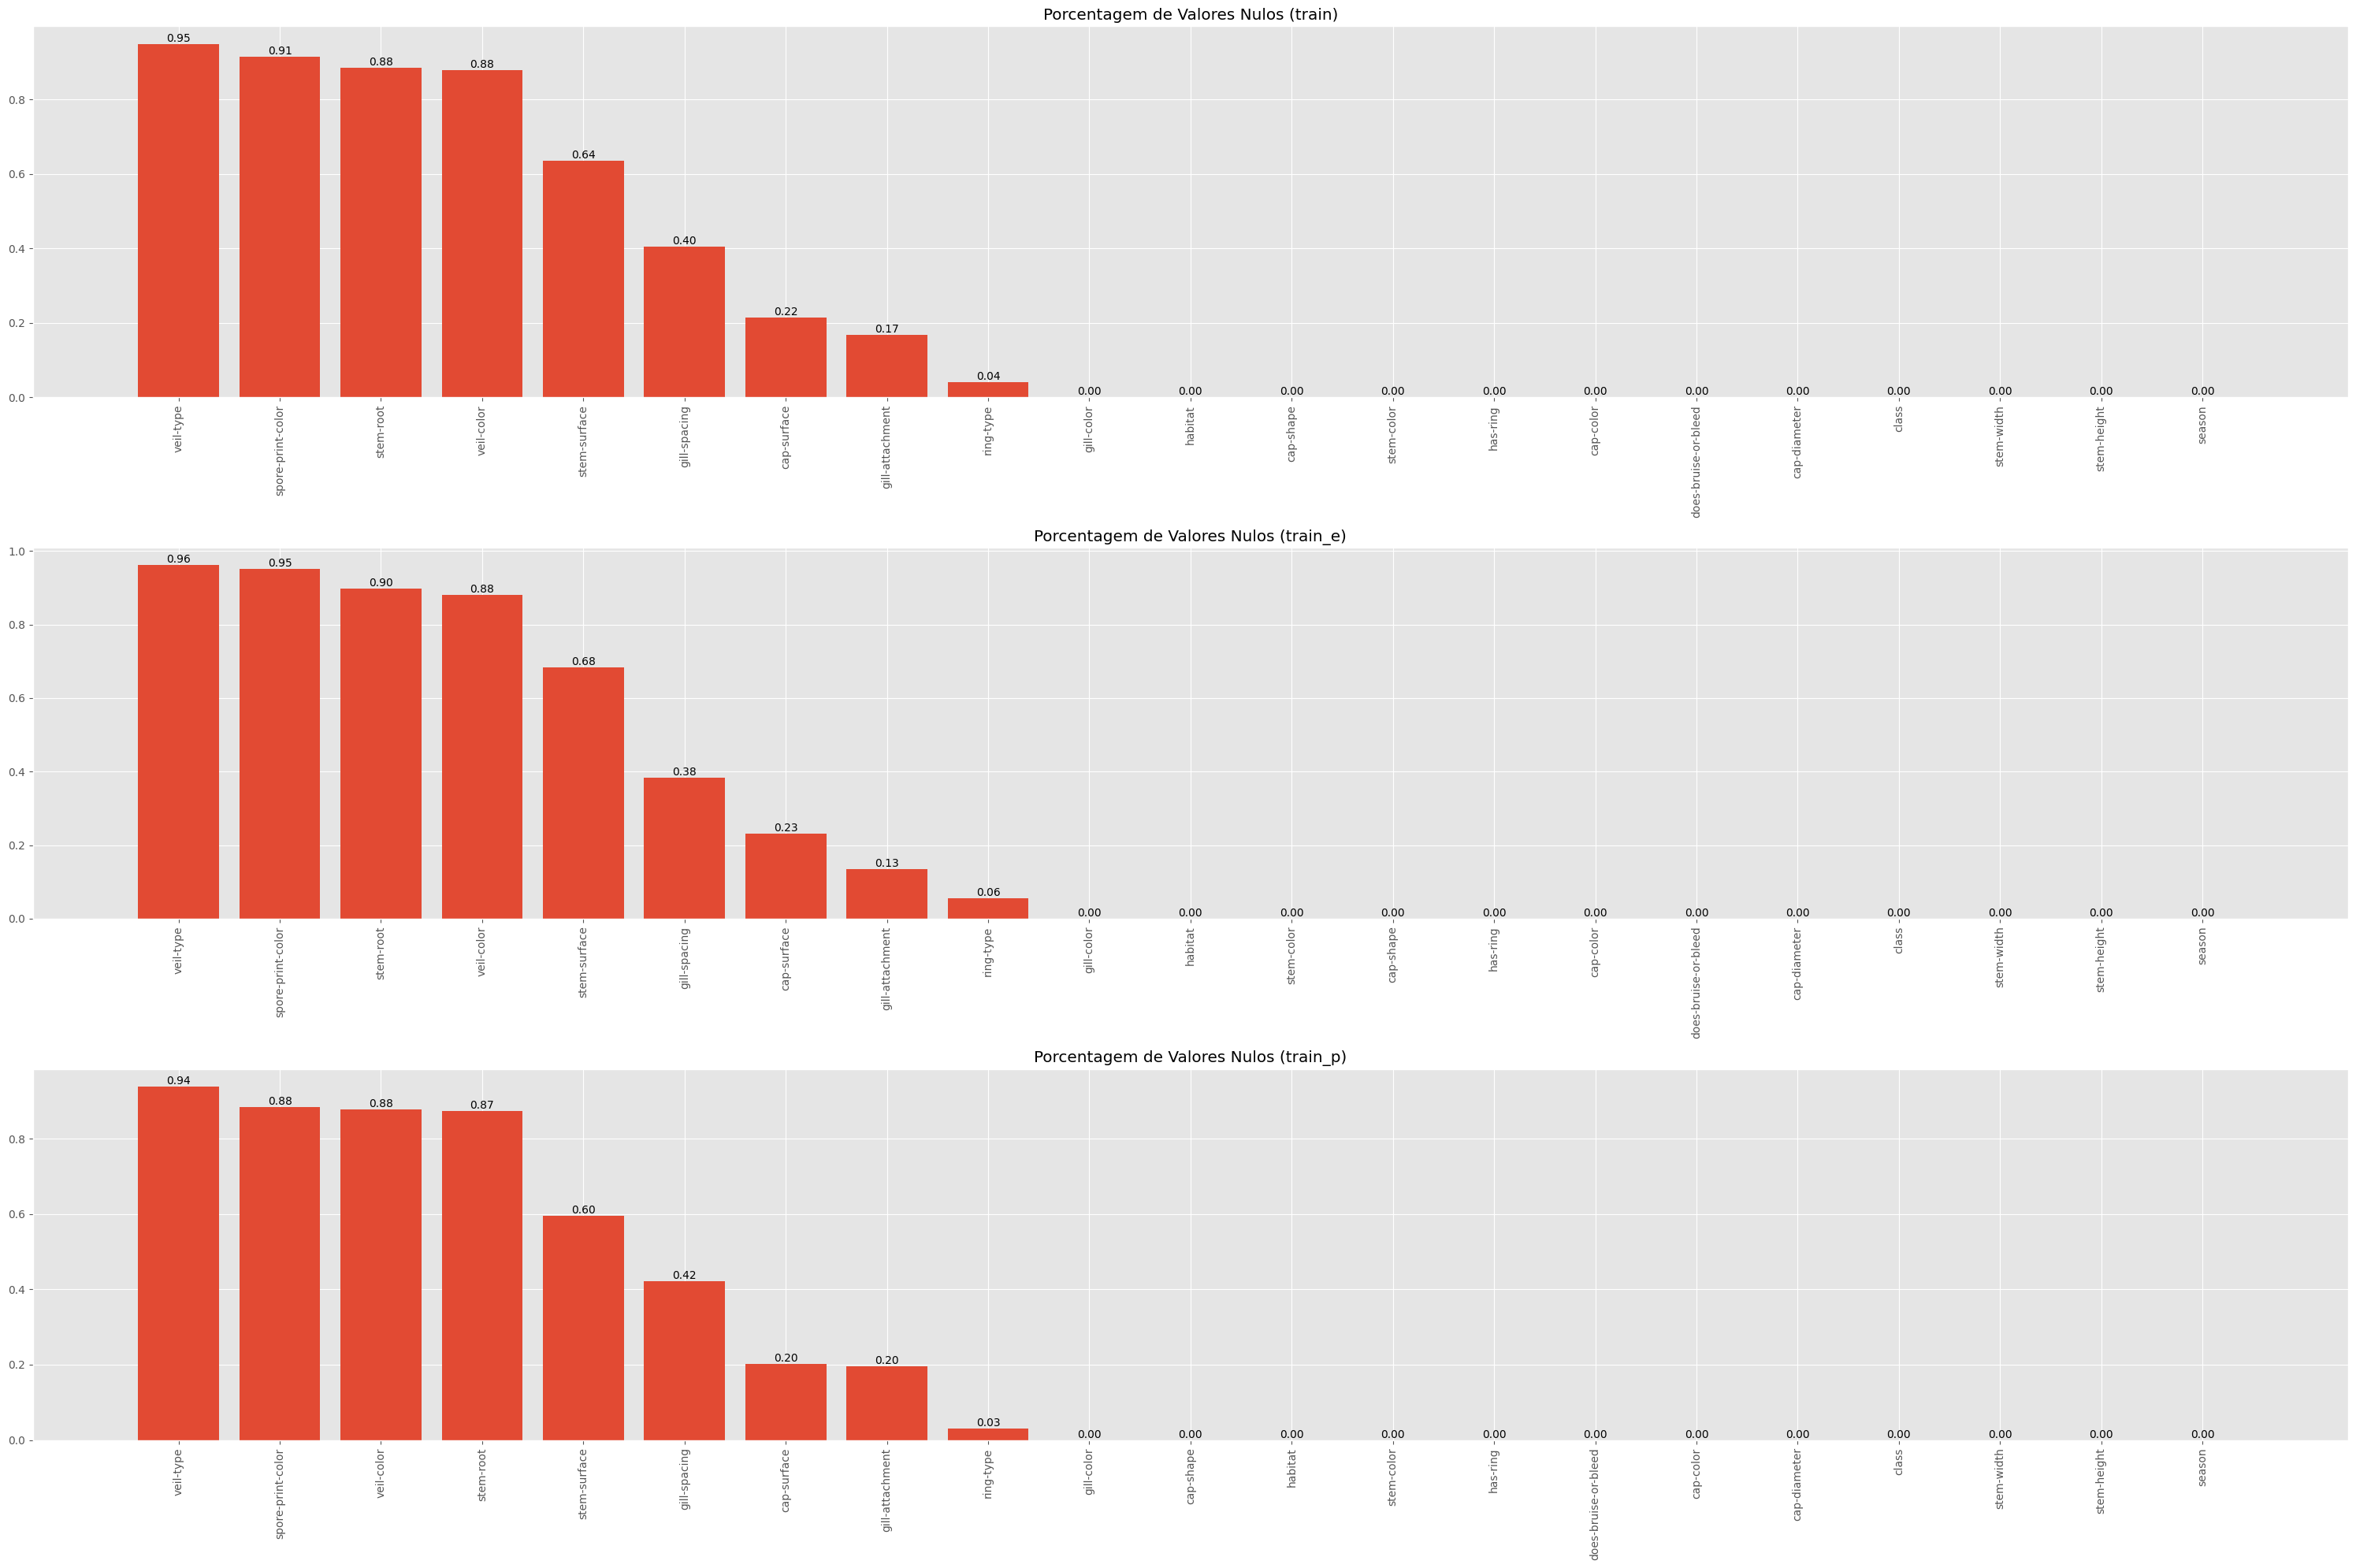

In [ ]:
# Calcula a porcentagem de valores nulos
valor_nul = (train.isnull().sum() / train.shape[0]).sort_values(ascending=False)
valor_nul_e = (train_e.isnull().sum() / train_e.shape[0]).sort_values(ascending=False)
valor_nul_p = (train_p.isnull().sum() / train_p.shape[0]).sort_values(ascending=False)

# Cria os subplots
fig, axes = plt.subplots(3, 1, figsize=(30, 20))

# Subplot para 'train'
axes[0].bar(valor_nul.index, valor_nul.values)
axes[0].set_title("Porcentagem de Valores Nulos (train)")
axes[0].tick_params(axis="x", rotation=90)
for index, value in enumerate(valor_nul.values):
    axes[0].text(index, value, f"{value:.2f}", ha="center", va="bottom")

# Subplot para 'train_e'
axes[1].bar(valor_nul_e.index, valor_nul_e.values)
axes[1].set_title("Porcentagem de Valores Nulos (train_e)")
axes[1].tick_params(axis="x", rotation=90)
for index, value in enumerate(valor_nul_e.values):
    axes[1].text(index, value, f"{value:.2f}", ha="center", va="bottom")

# Subplot para 'train_p'
axes[2].bar(valor_nul_p.index, valor_nul_p.values)
axes[2].set_title("Porcentagem de Valores Nulos (train_p)")
axes[2].tick_params(axis="x", rotation=90)
for index, value in enumerate(valor_nul_p.values):
    axes[2].text(index, value, f"{value:.2f}", ha="center", va="bottom")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe os gráficos
plt.show()

**Selecionando as colunas com mais valores faltantes**

Selecionando as colunas com mais de `40%` de valores faltantes. Olhando as linhas, verificamos que as colunas juntas tem 5 valores faltantes em `46%` das vezes, `27%` com 4 valores nulos e todas as 6 linhas nulas `17%`.

Isso demonstra que `90%` das vezes, essas colunas na mesma linha tem mais de 4 valores nulos. Por terem muitos valores nulos e com pouca informação, essas colunas serão excluidas:

- veil-type
- spore-print-color
- stem-root
- veil-color
- stem-surface
- gill-spacing'

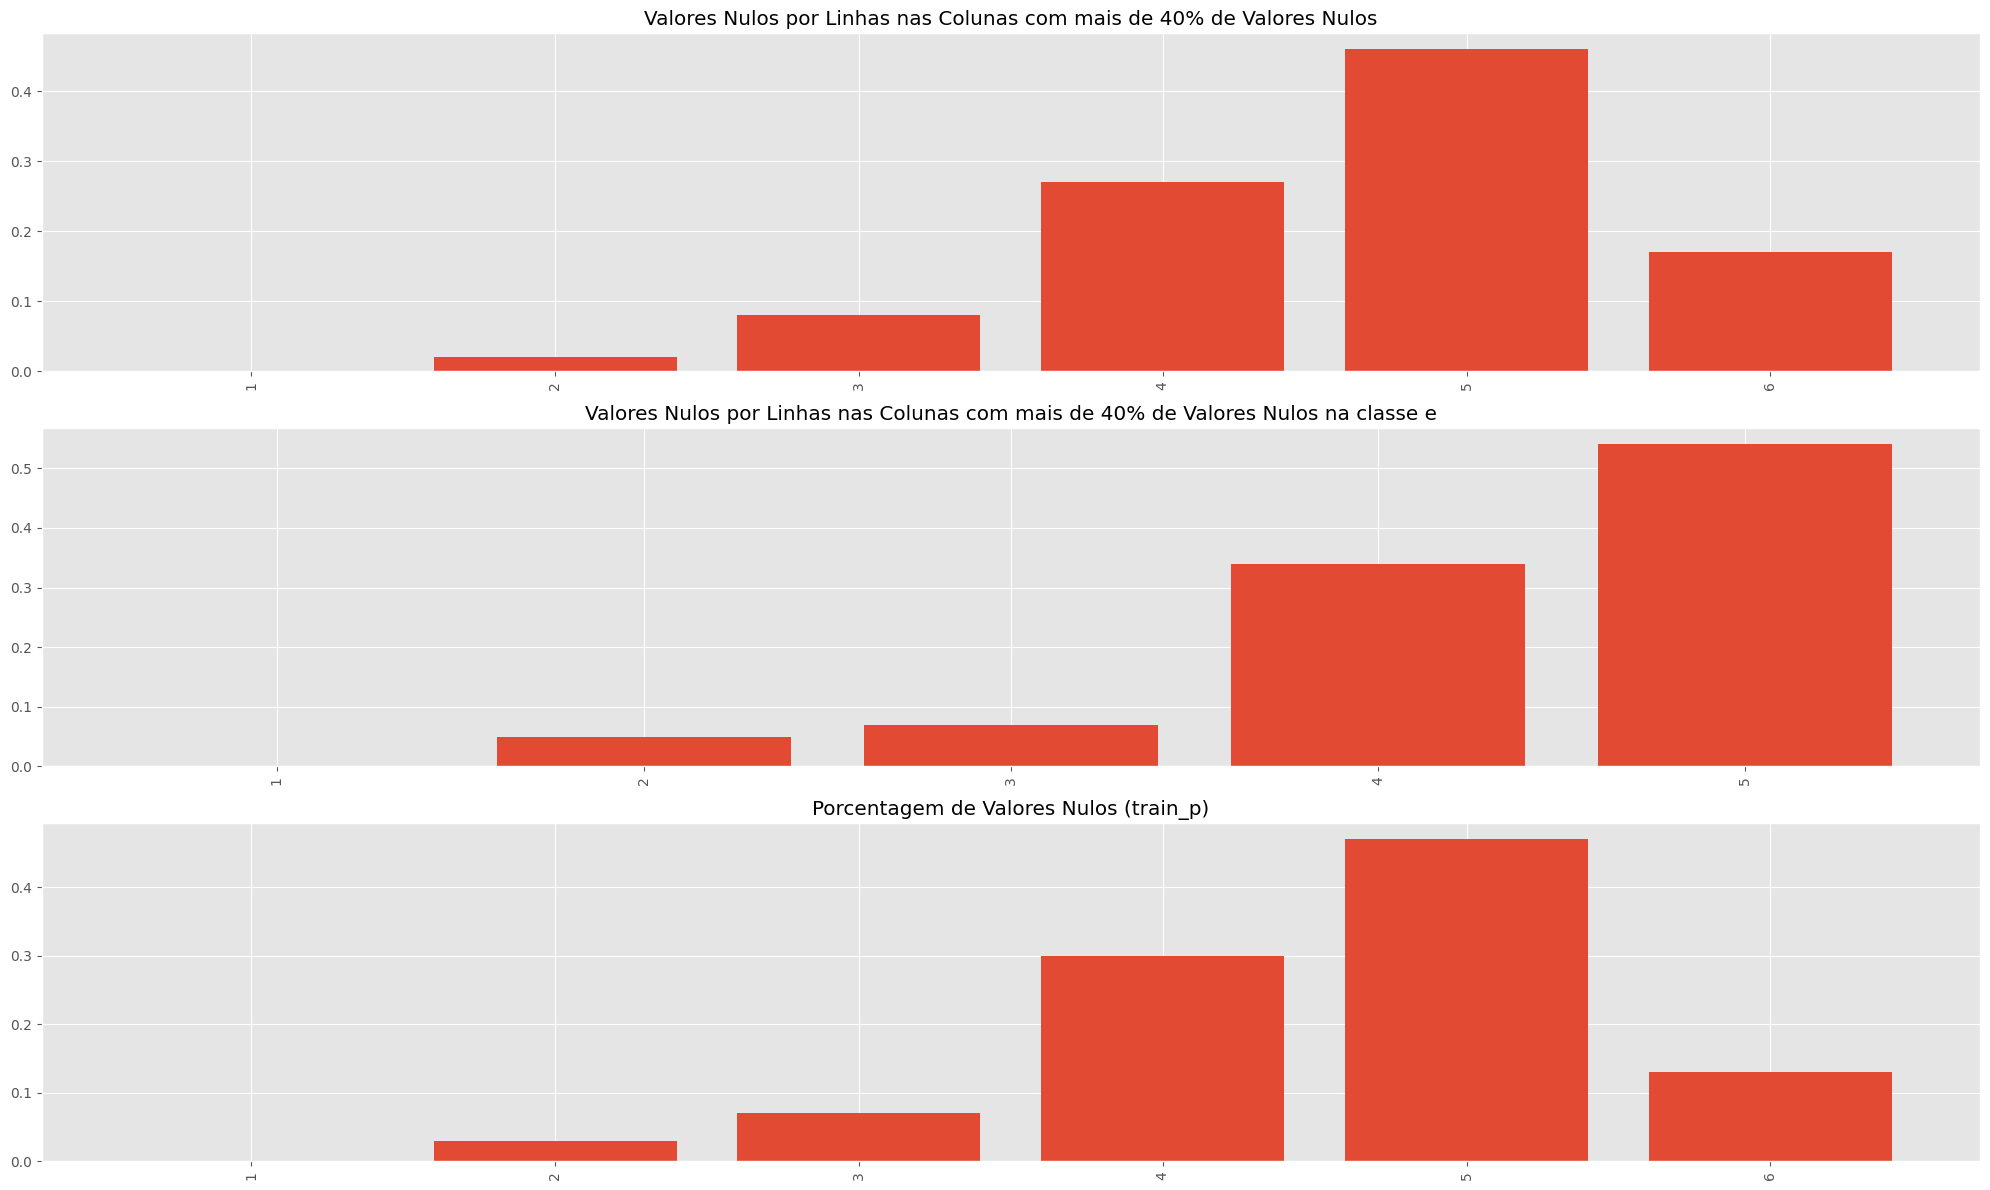

In [ ]:
# A maioria das colunas que tem mais de 40% de valores nulos, essa ocorrencia ocorre juntamente na mesma linha
valores_nulos_por_linha = (
    train[valor_nul[valor_nul > 0.4].index.values].isnull().sum(axis=1).value_counts()
)
valores_nulos_por_linha_e = (
    train_e[valor_nul_e[valor_nul_e > 0.4].index.values]
    .isnull()
    .sum(axis=1)
    .value_counts()
)
valores_nulos_por_linha_p = (
    train_p[valor_nul_p[valor_nul_p > 0.4].index.values]
    .isnull()
    .sum(axis=1)
    .value_counts()
)

## transfoemando em porcentagem
valores_nulos_por_linha_porcent = round(valores_nulos_por_linha / train.shape[0], 2)
valores_nulos_por_linha_porcent_e = round(
    valores_nulos_por_linha_e / train_e.shape[0], 2
)
valores_nulos_por_linha_porcent_p = round(
    valores_nulos_por_linha_p / train_p.shape[0], 2
)

## criando o grafico
fig, axes = plt.subplots(3, 1, figsize=(20, 12))
axes[0].bar(
    valores_nulos_por_linha_porcent.index, valores_nulos_por_linha_porcent.values
)
axes[0].set_title(
    "Valores Nulos por Linhas nas Colunas com mais de 40% de Valores Nulos"
)
axes[0].tick_params(axis="x", rotation=90)


axes[1].bar(
    valores_nulos_por_linha_porcent_e.index, valores_nulos_por_linha_porcent_e.values
)
axes[1].set_title(
    "Valores Nulos por Linhas nas Colunas com mais de 40% de Valores Nulos na classe e"
)
axes[1].tick_params(axis="x", rotation=90)


axes[2].bar(
    valores_nulos_por_linha_porcent_p.index, valores_nulos_por_linha_porcent_p.values
)
axes[2].set_title("Porcentagem de Valores Nulos (train_p)")
axes[2].tick_params(axis="x", rotation=90)

plt.tight_layout()

plt.show()

In [ ]:
# Remove as colunas 'veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface', 'gill-spacing'
columns_drop = [
    "veil-type",
    "spore-print-color",
    "stem-root",
    "veil-color",
    "stem-surface",
    "gill-spacing",
]

train.drop(columns_drop, axis=1, inplace=True)

**Verificando quantos valores unicos tem em cada coluna**

As 3 primeiras colunas são numericas não importando a quantidade de valores unicos. Ja algumas colunas categoricas tem muitas classes, `cap-surface` por exemplo tem 70 valores unicos.

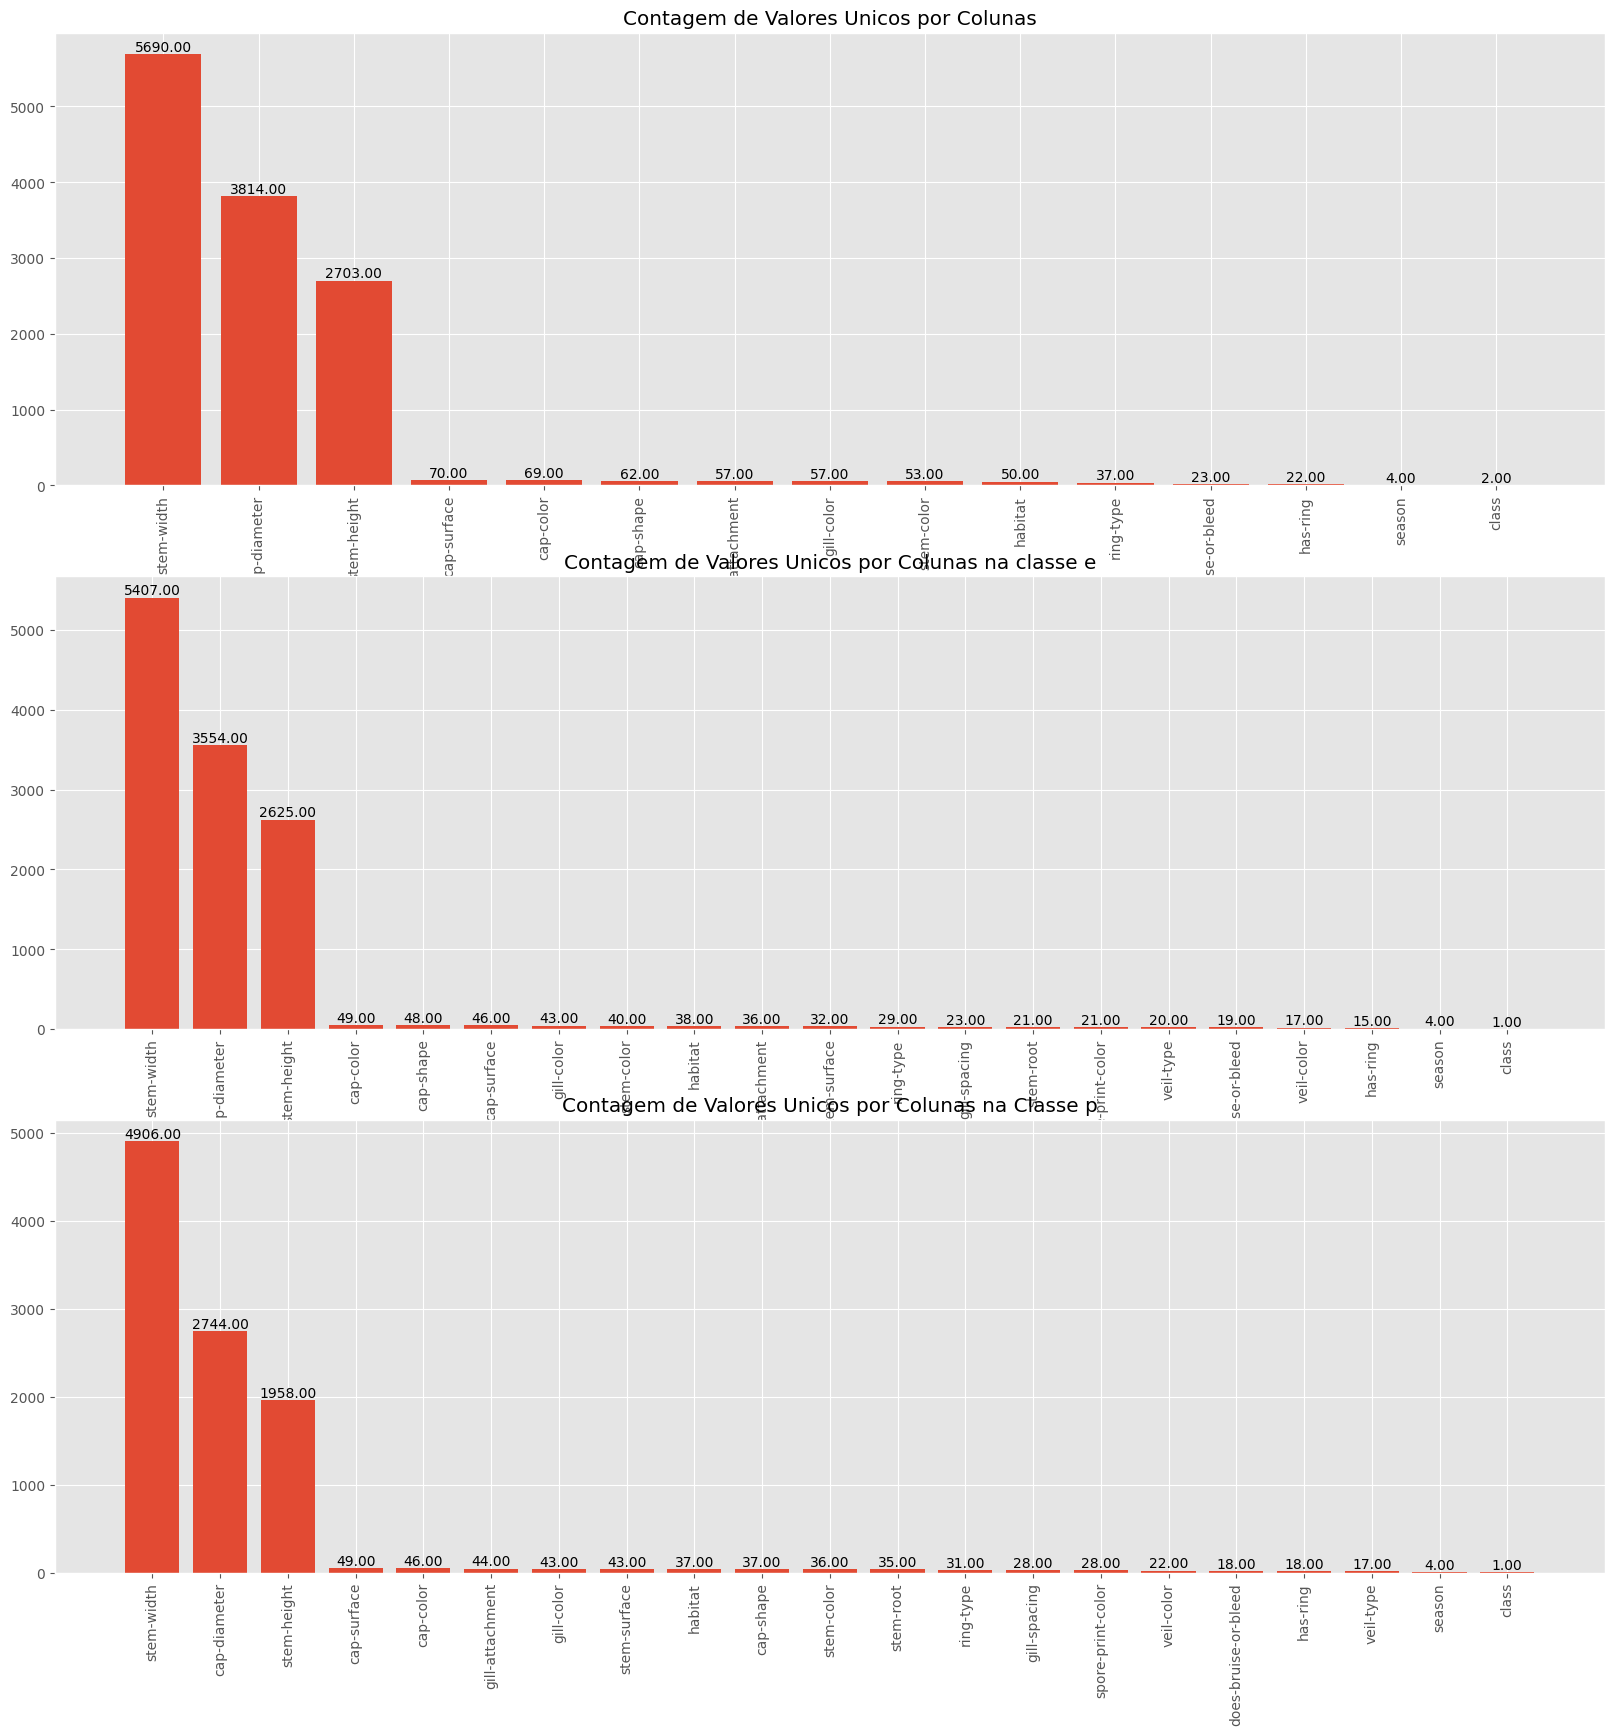

In [ ]:
train_nunique = train.nunique().sort_values(ascending=False)
train_nunique_e = train_e.nunique().sort_values(ascending=False)
train_nunique_p = train_p.nunique().sort_values(ascending=False)

fig, axes = plt.subplots(3, 1, figsize=(20, 20))

axes[0].bar(train_nunique.index, train_nunique.values)
axes[0].set_title("Contagem de Valores Unicos por Colunas")
axes[0].tick_params(axis="x", rotation=90)
for index, value in enumerate(train_nunique.values):
    axes[0].text(index, value, f"{value:.2f}", ha="center", va="bottom")

axes[1].bar(train_nunique_e.index, train_nunique_e.values)
axes[1].set_title("Contagem de Valores Unicos por Colunas na classe e")
axes[1].tick_params(axis="x", rotation=90)
for index, value in enumerate(train_nunique_e.values):
    axes[1].text(index, value, f"{value:.2f}", ha="center", va="bottom")


axes[2].bar(train_nunique_p.index, train_nunique_p.values)
axes[2].set_title("Contagem de Valores Unicos por Colunas na Classe p")
axes[2].tick_params(axis="x", rotation=90)
for index, value in enumerate(train_nunique_p.values):
    axes[2].text(index, value, f"{value:.2f}", ha="center", va="bottom")

**Verificando valores numericos**

Primeiro plotamos o histograma e depois um boxplot.

Com o histograma verificamos que as distribuições das colunas numericas não são normalmente distribuidas. Elas tem uma distribuição assimétrica para a esquerda.

Analisando o boxplot, observamos que as caixas são bastante largas, indicando que os valores das colunas numéricas estão concentrados entre o 1º e o 3º quartil. Além disso, percebemos que a média e a mediana não diferem muito nas colunas `cap-diameter` e `stem-height`. No entanto, na coluna `stem-width`, há uma diferença maior entre a média e a mediana, com uma discrepância de 13%. Essa diferença é ainda mais acentuada na classe `p`, onde chega a 26,95%. Isso pode indicar que a classe `p` tem uma maior quantidade de outliers.

```
cap-diameter: Diferença entre media e mediana dados train: 8.84 %, Diferença entre media e mediana na classe e: 8.70 %, Diferença entre media e mediana na classe p: 16.86 %
stem-height: Diferença entre media e mediana dados train: 7.37 %, Diferença entre media e mediana na classe e: 6.70 %, Diferença entre media e mediana na classe p: 9.57 %
stem-width: Diferença entre media e mediana dados train: 13.55 %, Diferença entre media e mediana na classe e: 5.02 %, Diferença entre media e mediana na classe p: 26.95 %
```

Analisando a porcentagem de outliers por coluna, observamos que a coluna com mais outliers é `stem-height`, com 4,63%. Esses valores extremos podem ser um preditor para a classe `p`, indicando que, quanto mais extremos os valores, mais venenosos podem ser.

```
Explorando a porcentagem de outliers na coluna cap-diameter
cap-diameter: 2.44%
cap-diameter_e: 1.91%
cap-diameter_p: 3.09%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna stem-height
stem-height: 4.25%
stem-height_e: 4.74%
stem-height_p: 3.58%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna stem-width
stem-width: 2.16%
stem-width_e: 1.06%
stem-width_p: 4.63%
```

<Figure size 1000x1000 with 0 Axes>

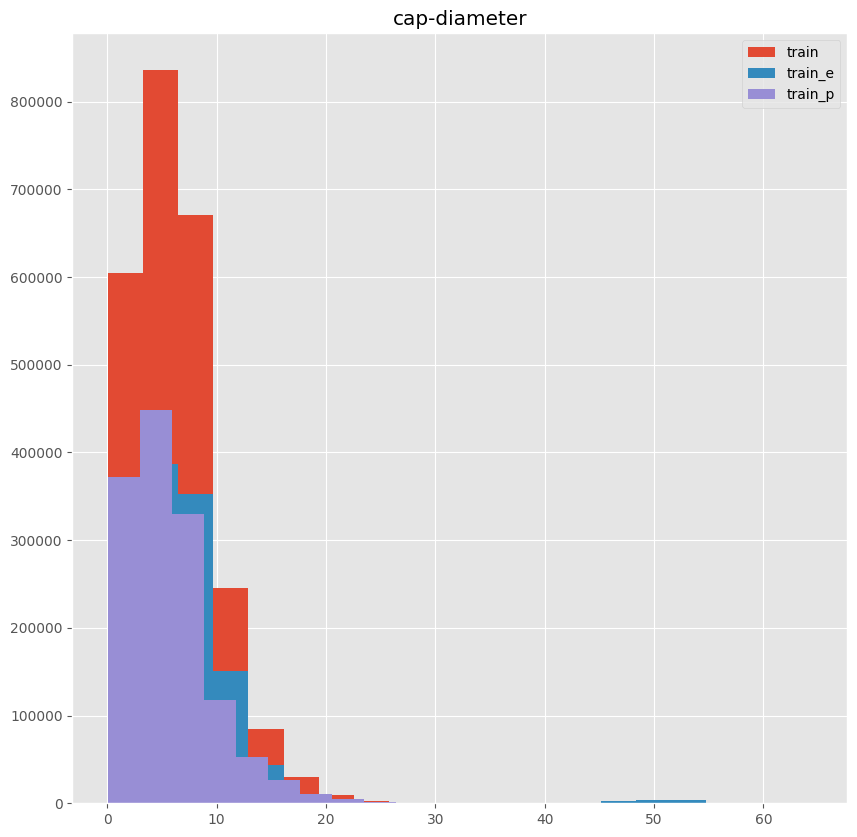

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

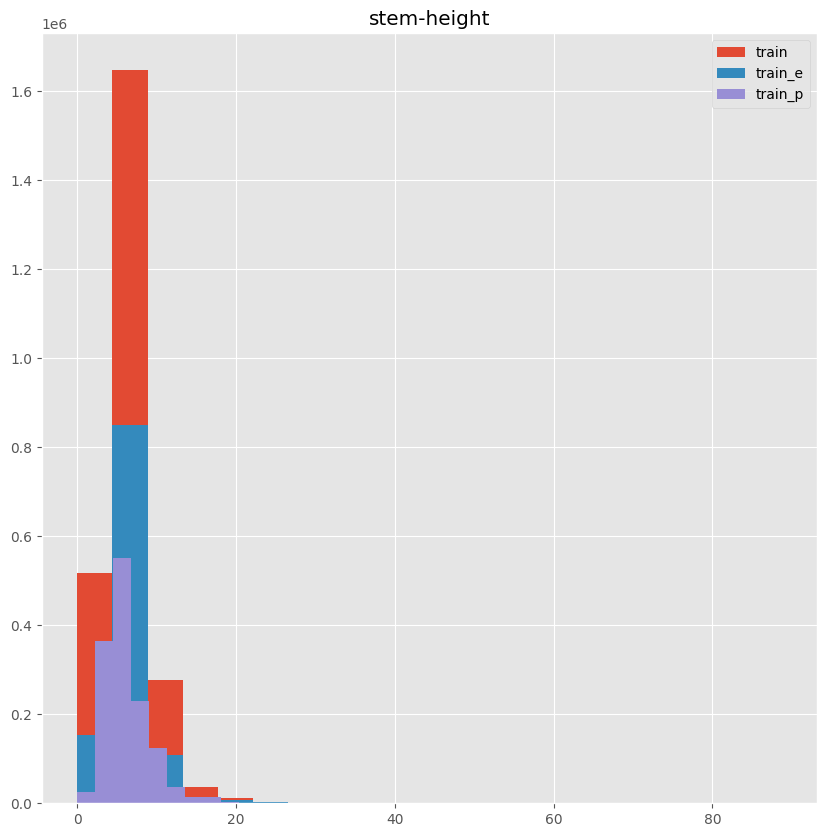

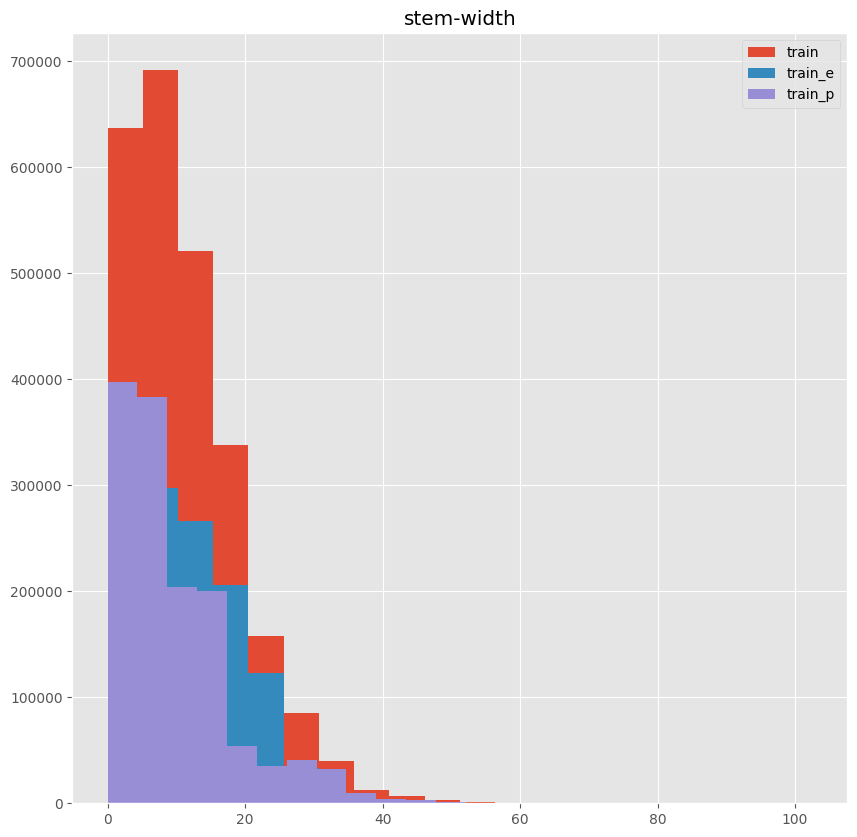

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [ ]:
## plot histograma dos valores numericos
for col in train.columns:
    plt.figure(figsize=(10, 10))
    if train[col].dtype == "float64":
        train[col].hist(bins=20)
        train_e[col].hist(bins=20)
        train_p[col].hist(bins=20)
        plt.title(col)
        plt.legend(["train", "train_e", "train_p"])
        plt.show()
        plt.close()

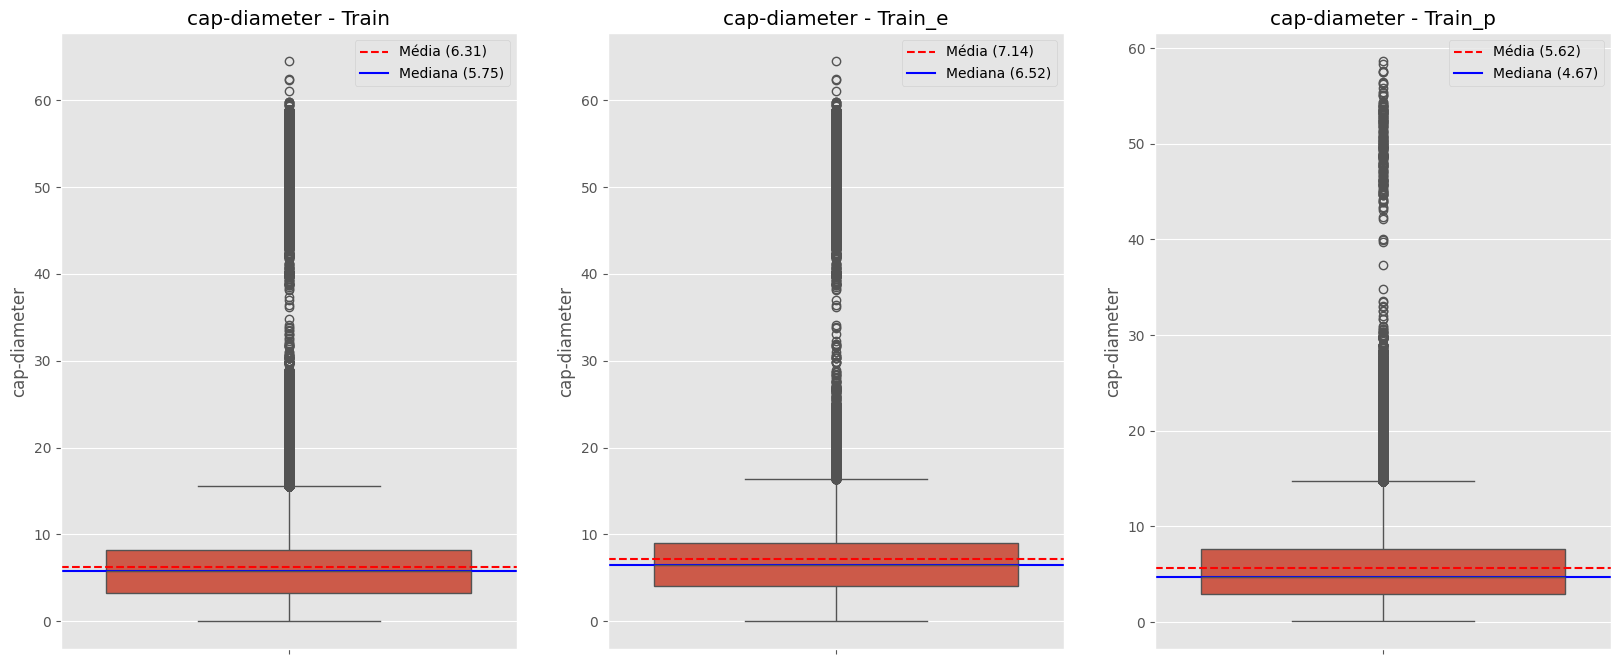

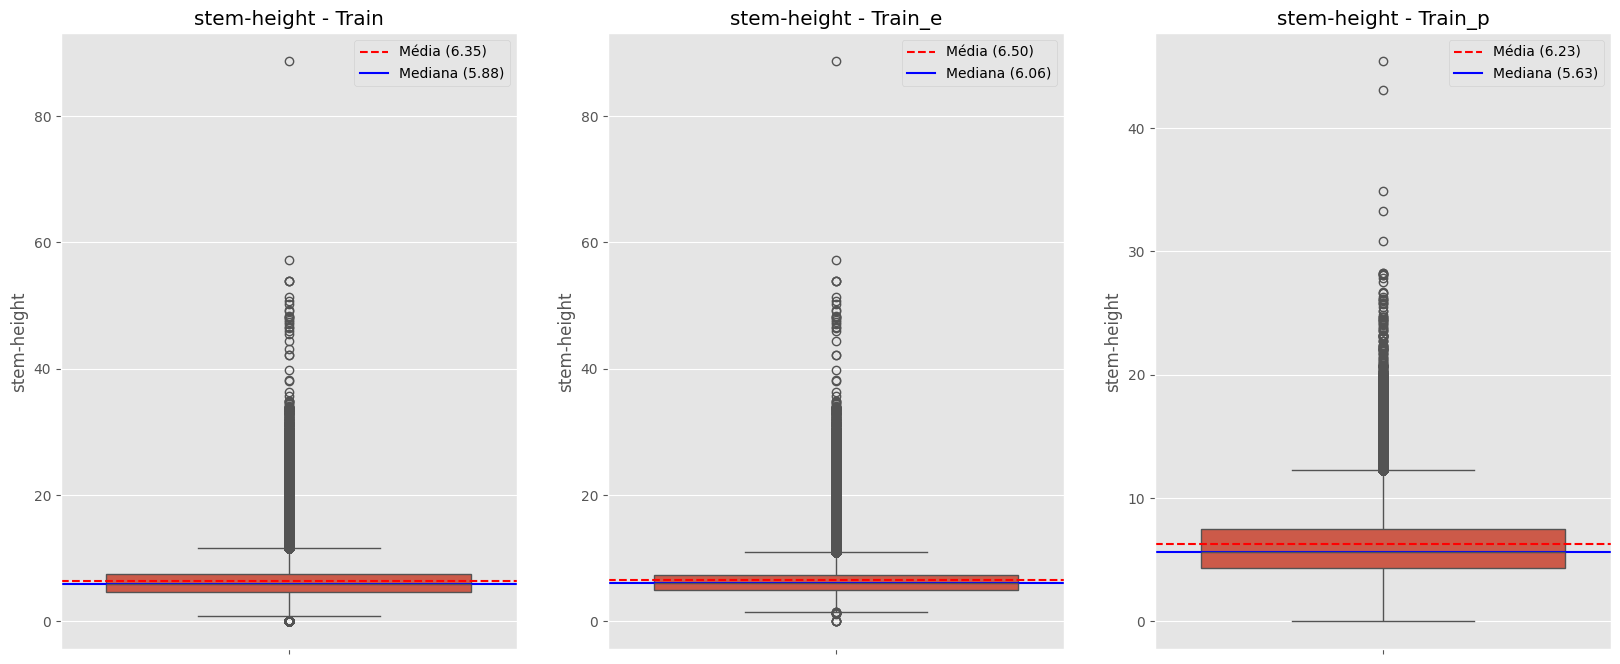

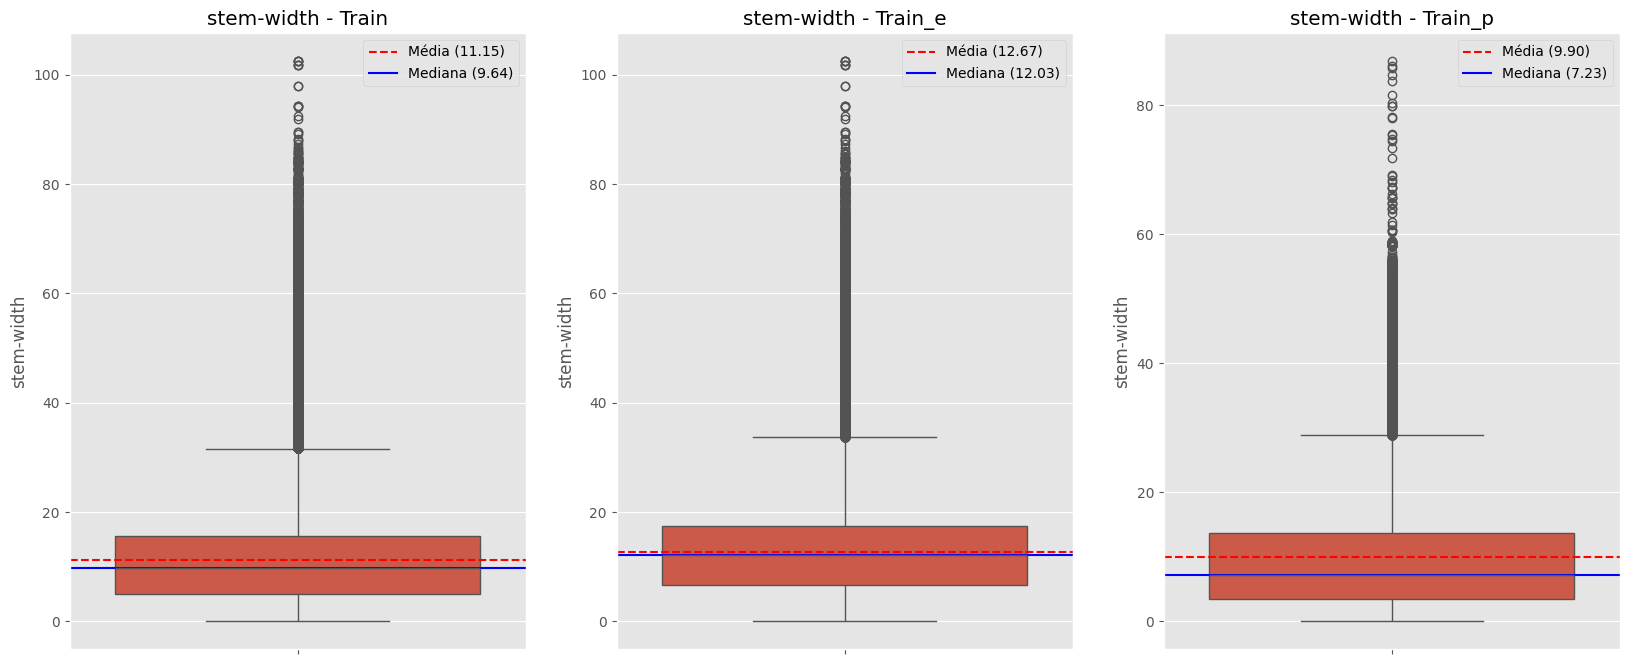

In [ ]:
for col in train.columns:
    if train[col].dtype == "float64":
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))
        mean_value = train[col].mean()
        mean_value_e = train_e[col].mean()
        mean_value_p = train_p[col].mean()
        median_value = train[col].median()
        median_value_e = train_e[col].median()
        median_value_p = train_p[col].median()

        sns.boxplot(train[col], ax=axes[0], showfliers=True)
        axes[0].set_title(f"{col} - Train")
        axes[0].axhline(
            y=mean_value, color="red", linestyle="--", label=f"Média ({mean_value:.2f})"
        )
        axes[0].axhline(
            y=median_value,
            color="blue",
            linestyle="-",
            label=f"Mediana ({median_value:.2f})",
        )
        axes[0].legend()

        sns.boxplot(train_e[col], ax=axes[1], showfliers=True)
        axes[1].set_title(f"{col} - Train_e")
        axes[1].axhline(
            y=mean_value_e,
            color="red",
            linestyle="--",
            label=f"Média ({mean_value_e:.2f})",
        )
        axes[1].axhline(
            y=median_value_e,
            color="blue",
            linestyle="-",
            label=f"Mediana ({median_value_e:.2f})",
        )
        axes[1].legend()

        sns.boxplot(train_p[col], ax=axes[2], showfliers=True)
        axes[2].set_title(f"{col} - Train_p")
        axes[2].axhline(
            y=mean_value_p,
            color="red",
            linestyle="--",
            label=f"Média ({mean_value_p:.2f})",
        )
        axes[2].axhline(
            y=median_value_p,
            color="blue",
            linestyle="-",
            label=f"Mediana ({median_value_p:.2f})",
        )
        axes[2].legend()

        plt.show()

**Visualizando 5 transformacoes para as colunas numericas**

- StandardScaler()
- MinMaxScaler()
- BoxCoxTransformer()
- LogCpTransformer()
- YeoJohnsonTransformer()

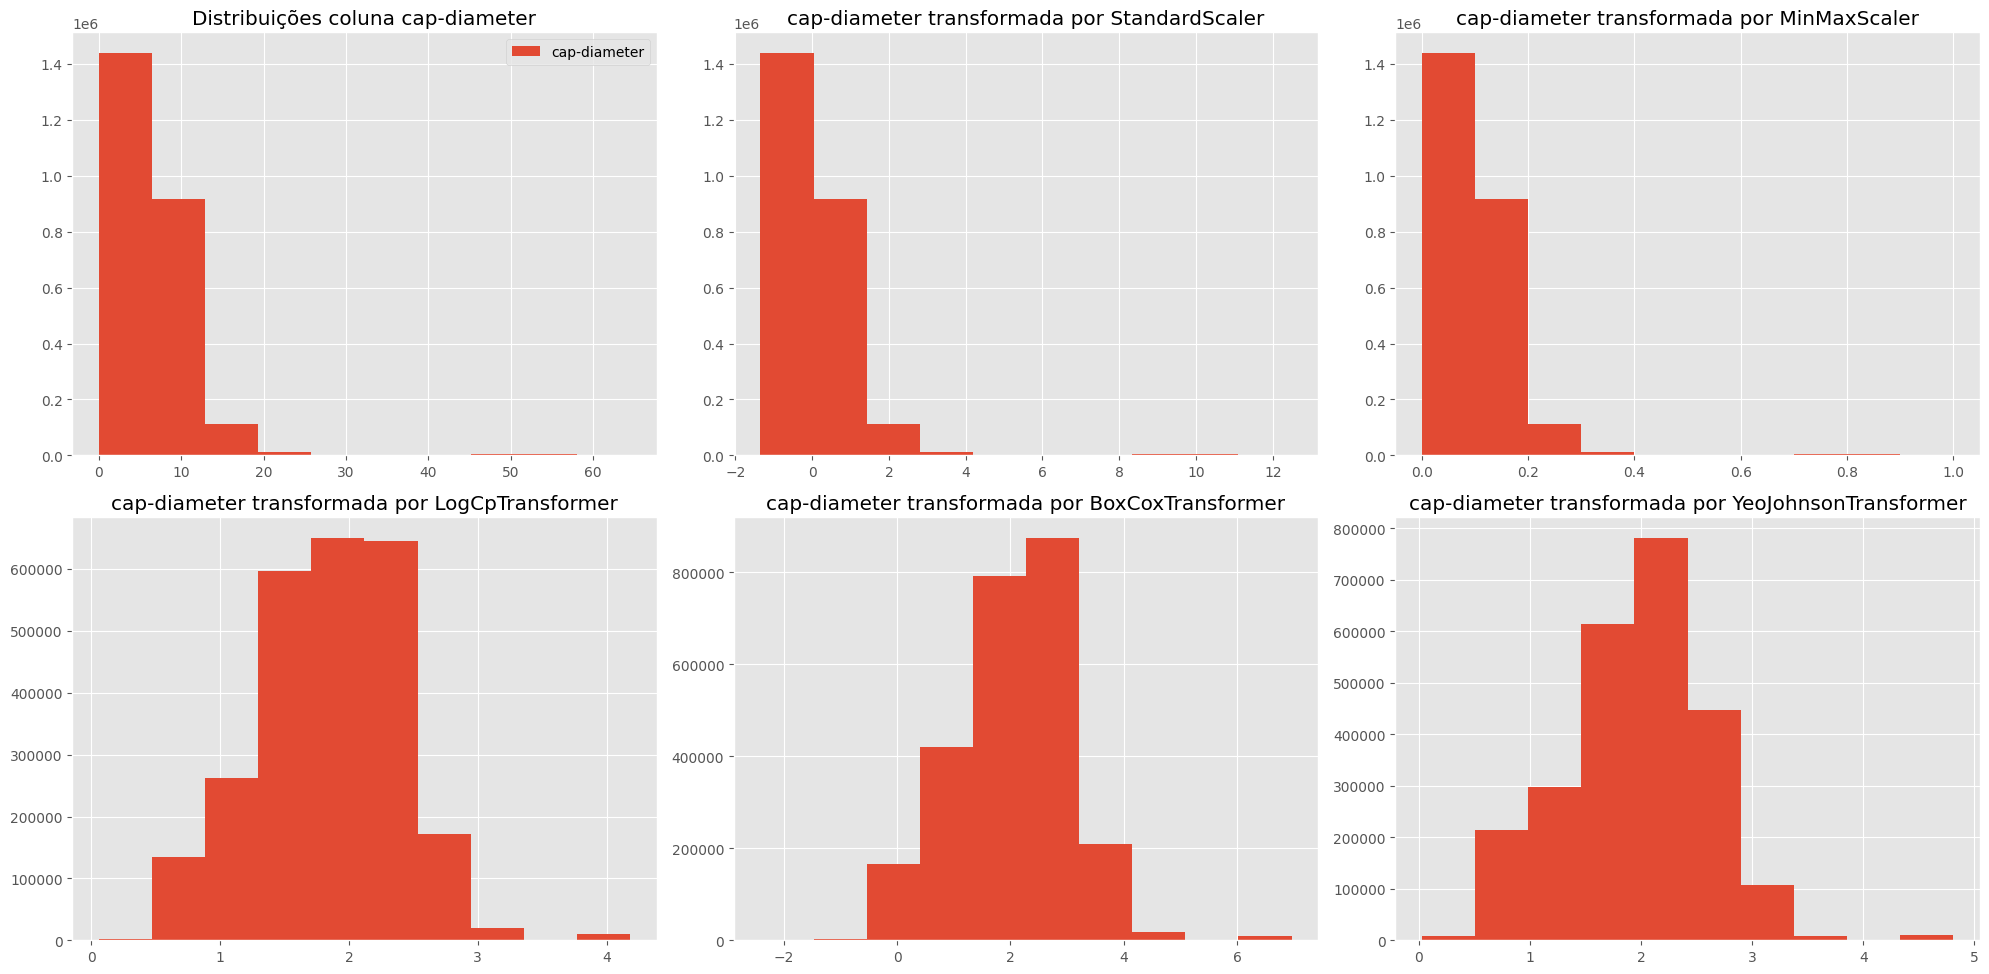

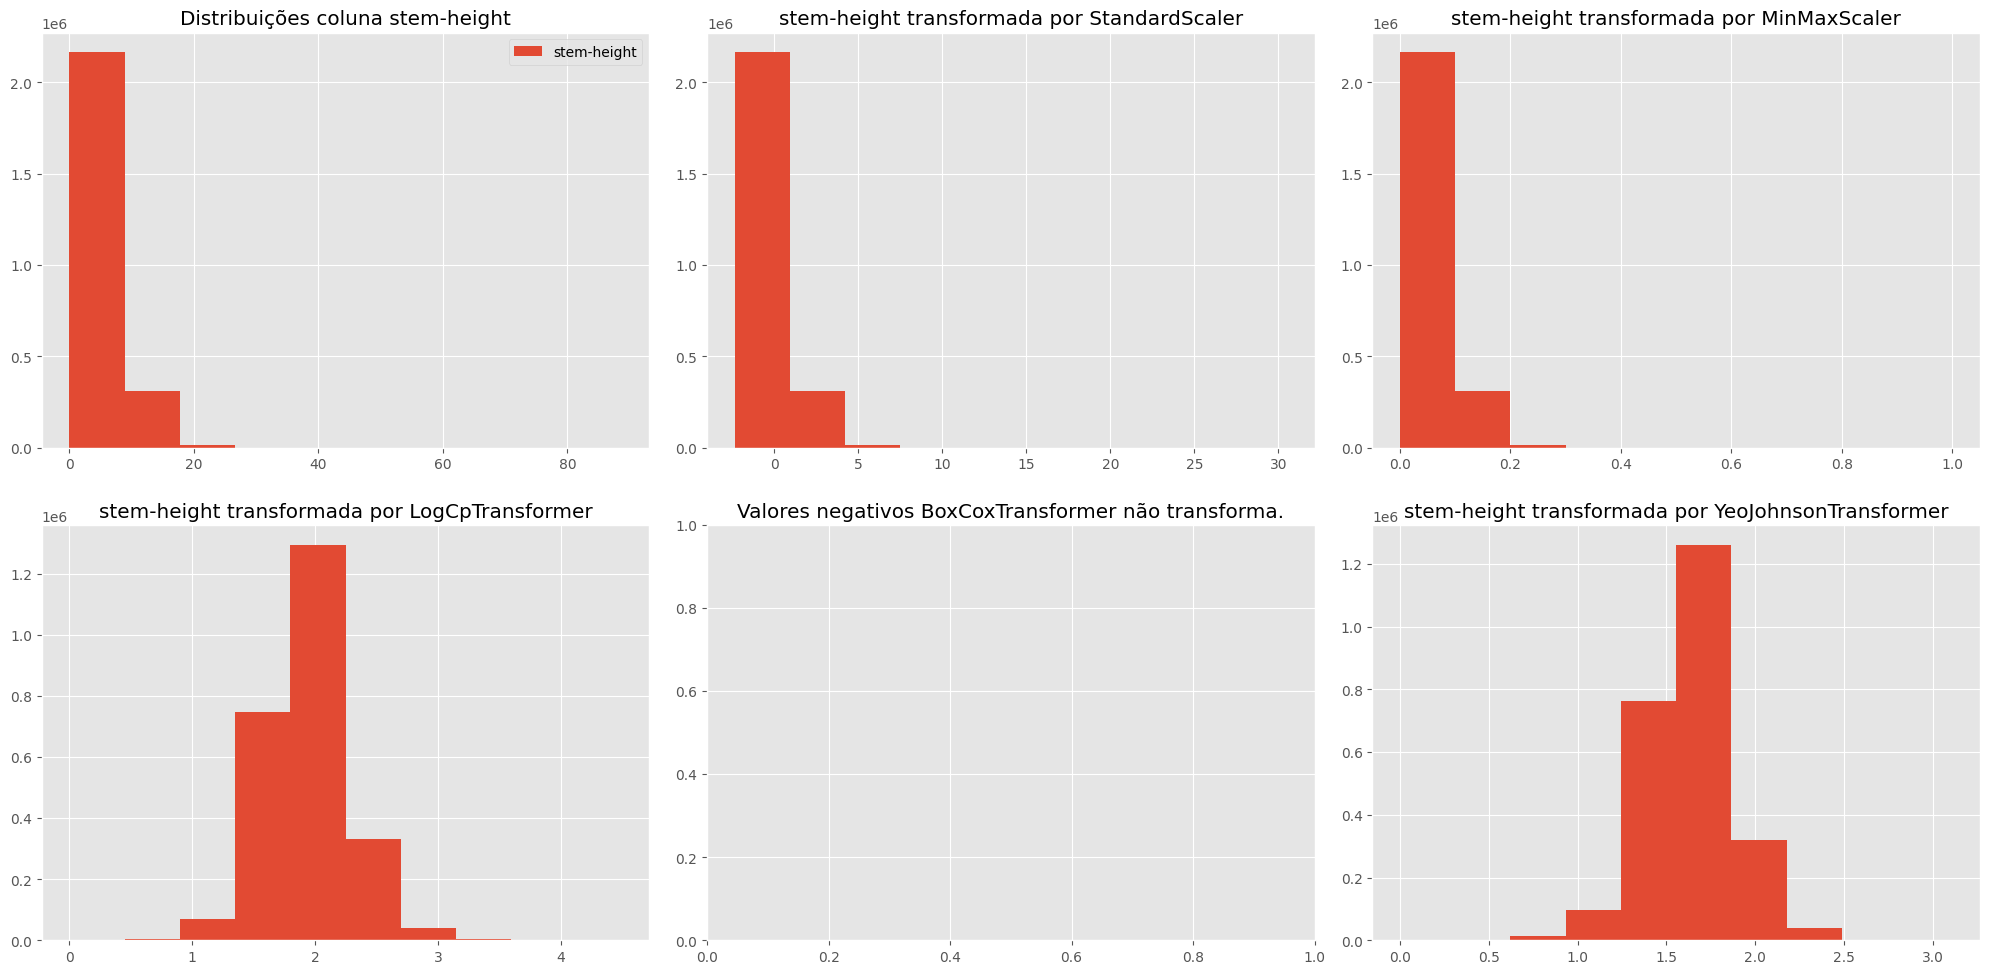

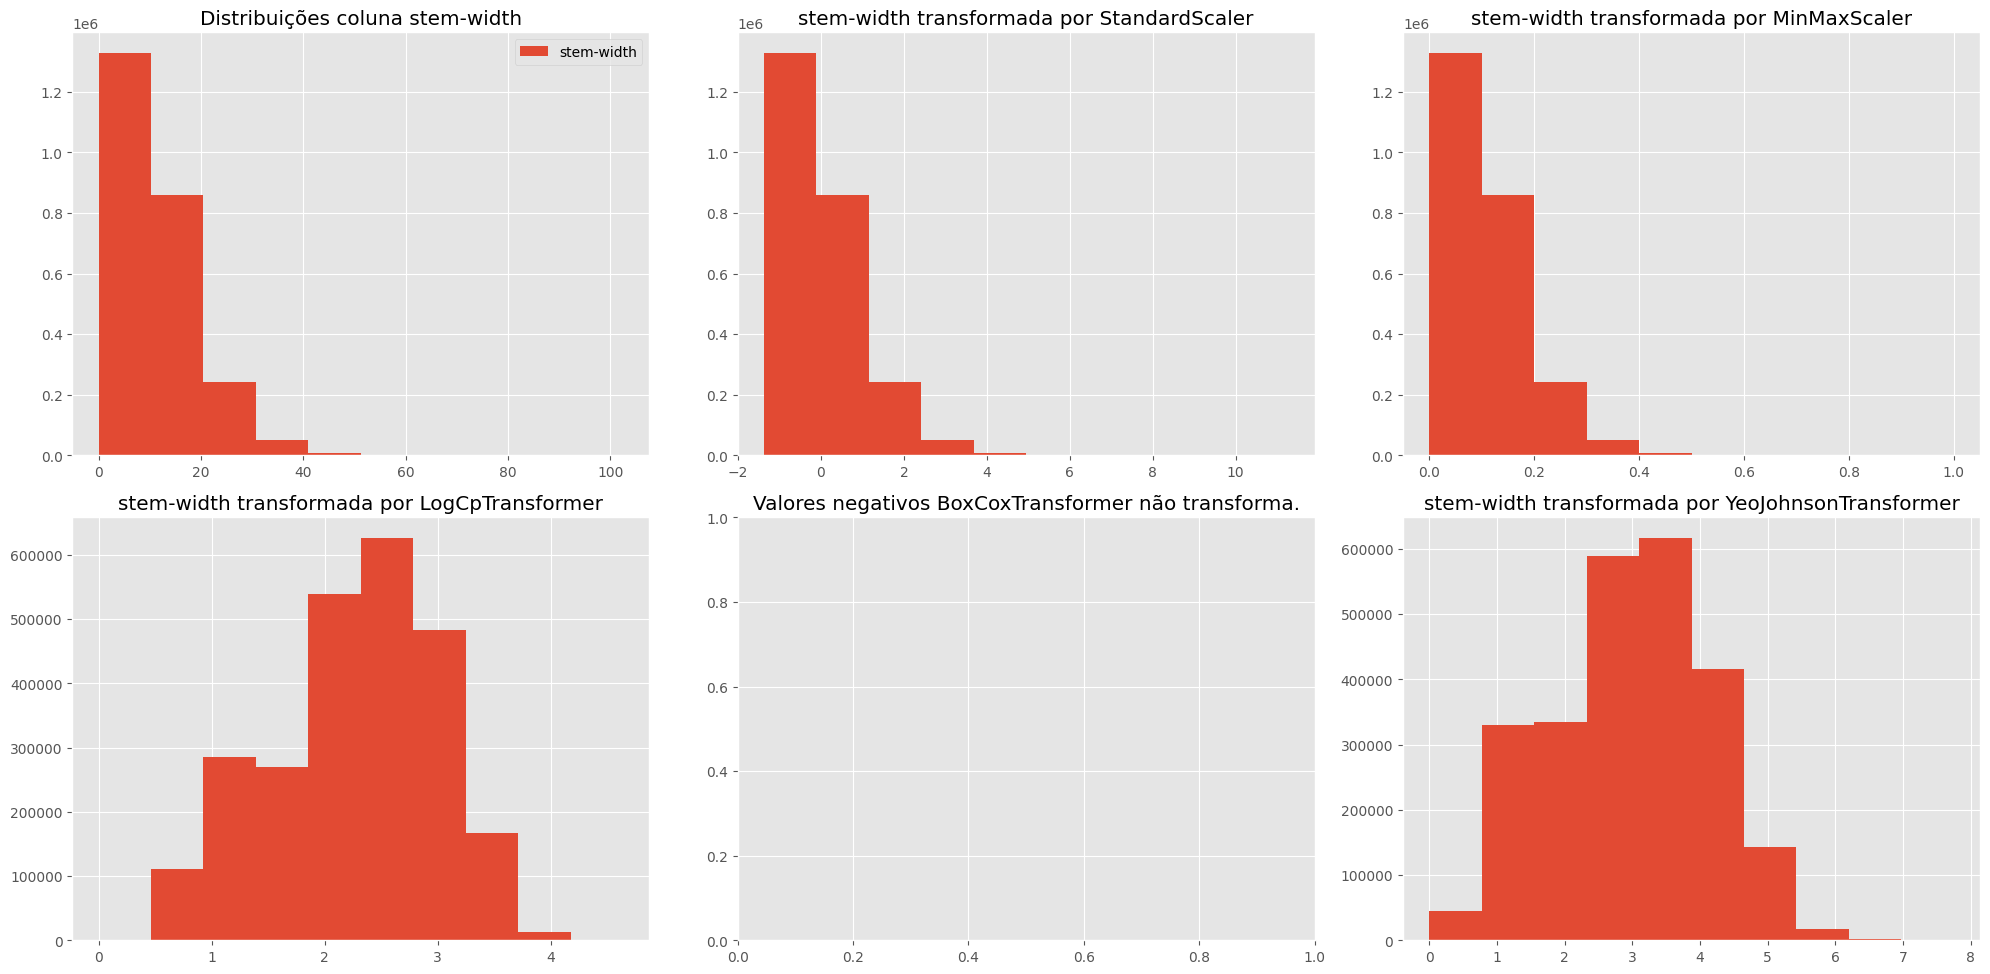

In [ ]:
train_numerical_sem_nan = train.copy()
float_cols = train_numerical_sem_nan.select_dtypes(include=["float64", "int64"]).columns
imputer = SimpleImputer(strategy="median")
train_numerical_sem_nan[float_cols] = imputer.fit_transform(train_numerical_sem_nan[float_cols])
col_numeric = ['cap-diameter', 'stem-height', 'stem-width']
for col in col_numeric:
    stand = StandardScaler()
    norm = MinMaxScaler()
    box = BoxCoxTransformer()
    log = LogCpTransformer()
    jonson = YeoJohnsonTransformer()

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    axes[0][0].hist(train_numerical_sem_nan[col], label=col)
    axes[0][0].set_title(f'Distribuições coluna {col}')
    axes[0][0].legend()

    axes[0][1].hist(stand.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_stand')
    axes[0][1].set_title(f'{col} transformada por StandardScaler')

    axes[0][2].hist(norm.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_norm')
    axes[0][2].set_title(f'{col} transformada por MinMaxScaler')

    axes[1][0].hist(log.fit_transform(train_numerical_sem_nan[[col]]), label=f'{col}_log')
    axes[1][0].set_title(f'{col} transformada por LogCpTransformer')

    try:
        axes[1][1].hist(box.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_box')
        axes[1][1].set_title(f'{col} transformada por BoxCoxTransformer')

    except ValueError:
        axes[1][1].set_title('Valores negativos BoxCoxTransformer não transforma.')

    axes[1][2].hist(jonson.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_jonson')
    axes[1][2].set_title(f'{col} transformada por YeoJohnsonTransformer')

    plt.tight_layout()
    plt.show()

In [ ]:
# difernca percentual entre a media e a mediana
for col in train.columns:
    if train[col].dtype == "float64":
        mean_value = train[col].mean()
        mean_value_e = train_e[col].mean()
        mean_value_p = train_p[col].mean()

        median_value = train[col].median()
        median_value_e = train_e[col].median()
        median_value_p = train_p[col].median()

        diff_mean_median = (mean_value - median_value) / mean_value * 100
        diff_mean_median_e = (mean_value_e - median_value_e) / mean_value_e * 100
        diff_mean_median_p = (mean_value_p - median_value_p) / mean_value_p * 100

        print(
            f"{col}: Diferença entre media e mediana dados train: {diff_mean_median:.2f} %, Diferença entre media e mediana na classe e: {diff_mean_median_e:.2f} %, Diferença entre media e mediana na classe p: {diff_mean_median_p:.2f} %"
        )

cap-diameter: Diferença entre media e mediana dados train: 8.84 %, Diferença entre media e mediana na classe e: 8.70 %, Diferença entre media e mediana na classe p: 16.86 %
stem-height: Diferença entre media e mediana dados train: 7.37 %, Diferença entre media e mediana na classe e: 6.70 %, Diferença entre media e mediana na classe p: 9.57 %
stem-width: Diferença entre media e mediana dados train: 13.55 %, Diferença entre media e mediana na classe e: 5.02 %, Diferença entre media e mediana na classe p: 26.95 %


In [ ]:
# Porcentagem de outliers
for col in train.columns:
    if train[col].dtype == "float64":
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        upper_bound, lower_bound
        out_train = train[
            (train[col] < lower_bound) | (train[col] > upper_bound)
        ].shape[0]

        Q1_e = train_e[col].quantile(0.25)
        Q3_e = train_e[col].quantile(0.75)
        IQR_e = Q3_e - Q1_e
        lower_bound_e = Q1_e - 1.5 * IQR_e
        upper_bound_e = Q3_e + 1.5 * IQR_e
        out_train_e = train_e[
            (train_e[col] < lower_bound_e) | (train_e[col] > upper_bound_e)
        ].shape[0]

        Q1_p = train_p[col].quantile(0.25)
        Q3_p = train_p[col].quantile(0.75)
        IQR_p = Q3_p - Q1_p
        lower_bound_p = Q1_p - 1.5 * IQR_p
        upper_bound_p = Q3_p + 1.5 * IQR_p
        out_train_p = train_p[
            (train_p[col] < lower_bound_p) | (train_p[col] > upper_bound_p)
        ].shape[0]

        print(f"Explorando a porcentagem de outliers na coluna {col}")
        print(f"{col}: {out_train/train.shape[0]:.2%}")
        print(f"{col}_e: {out_train_e/train_e.shape[0]:.2%}")
        print(f"{col}_p: {out_train_p/train_p.shape[0]:.2%}")

        print("-------------------------------------------------------------")

Explorando a porcentagem de outliers na coluna cap-diameter
cap-diameter: 2.44%
cap-diameter_e: 1.91%
cap-diameter_p: 3.09%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna stem-height
stem-height: 4.25%
stem-height_e: 4.74%
stem-height_p: 3.58%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna stem-width
stem-width: 2.16%
stem-width_e: 1.06%
stem-width_p: 4.63%
-------------------------------------------------------------


**Verificando as categorias em cada coluna**

Ao analisar as colunas categóricas, observamos que muitas variáveis aparecem com frequência nas mesmas colunas. Por exemplo, na coluna `cap-shape`, a variável X ocorre em 46% das vezes. A coluna `does-bruise-or-bleed` possui a variável `f` como a mais frequente, aparecendo em 82% dos dados de treino.

Além disso, algumas colunas apresentam uma mudança na variável mais frequente dependendo da classe. Por exemplo, na coluna `stem-color`, a variável mais frequente na classe `e` é a variável `w`, ocorrendo em 49% das vezes, enquanto na classe `p`, a variável predominante é `n`, com `36%`.

Verificando os valores acumulados das porcentagens, notamos que em quase todas as colunas, 5 ou 6 variáveis representam `90%` dos valores. Uma das únicas colunas com uma distribuição mais uniforme entre as variáveis é `cap-surface`, onde as 10 primeiras variáveis representam `78%` dos dados.

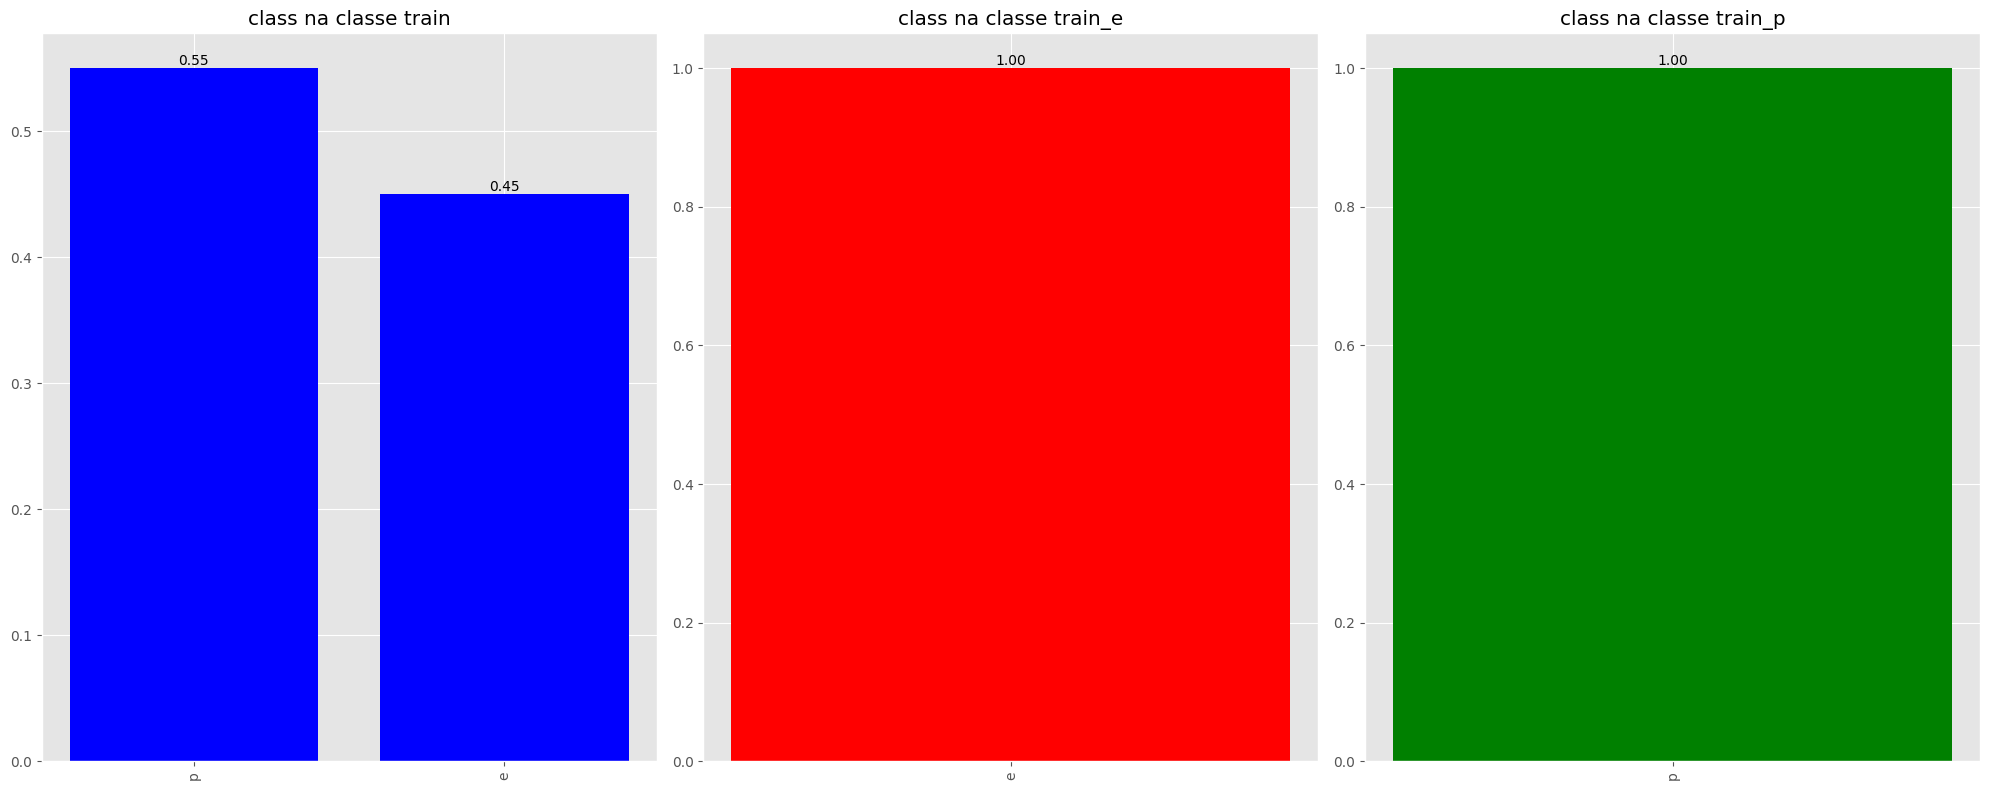

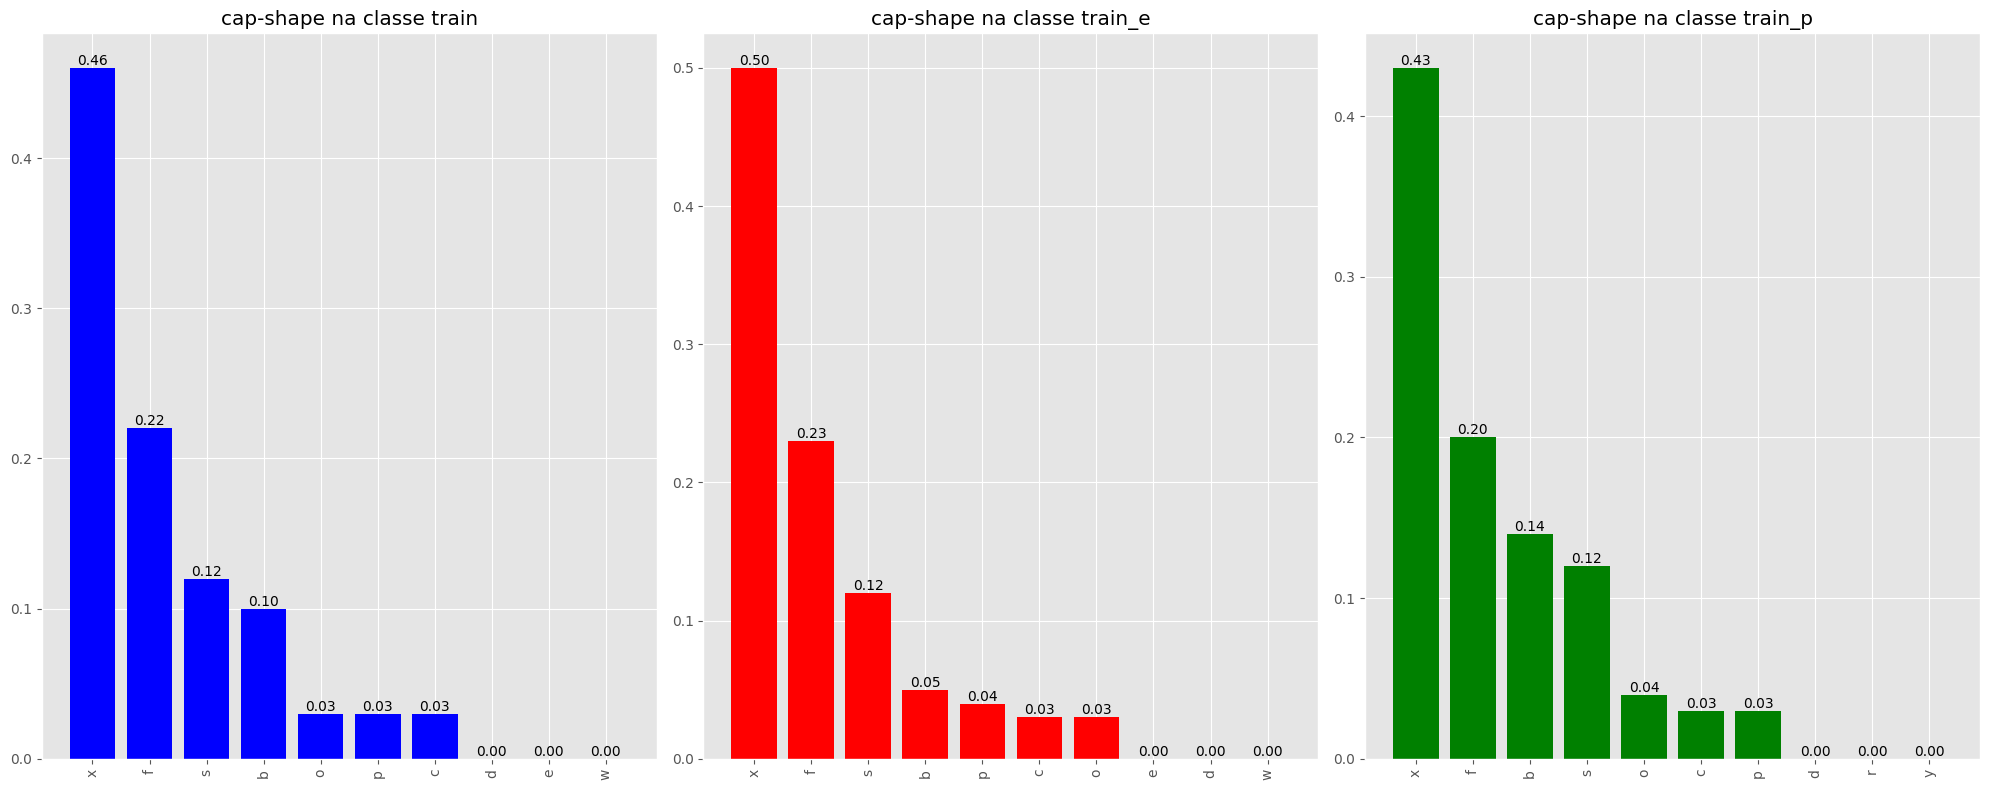

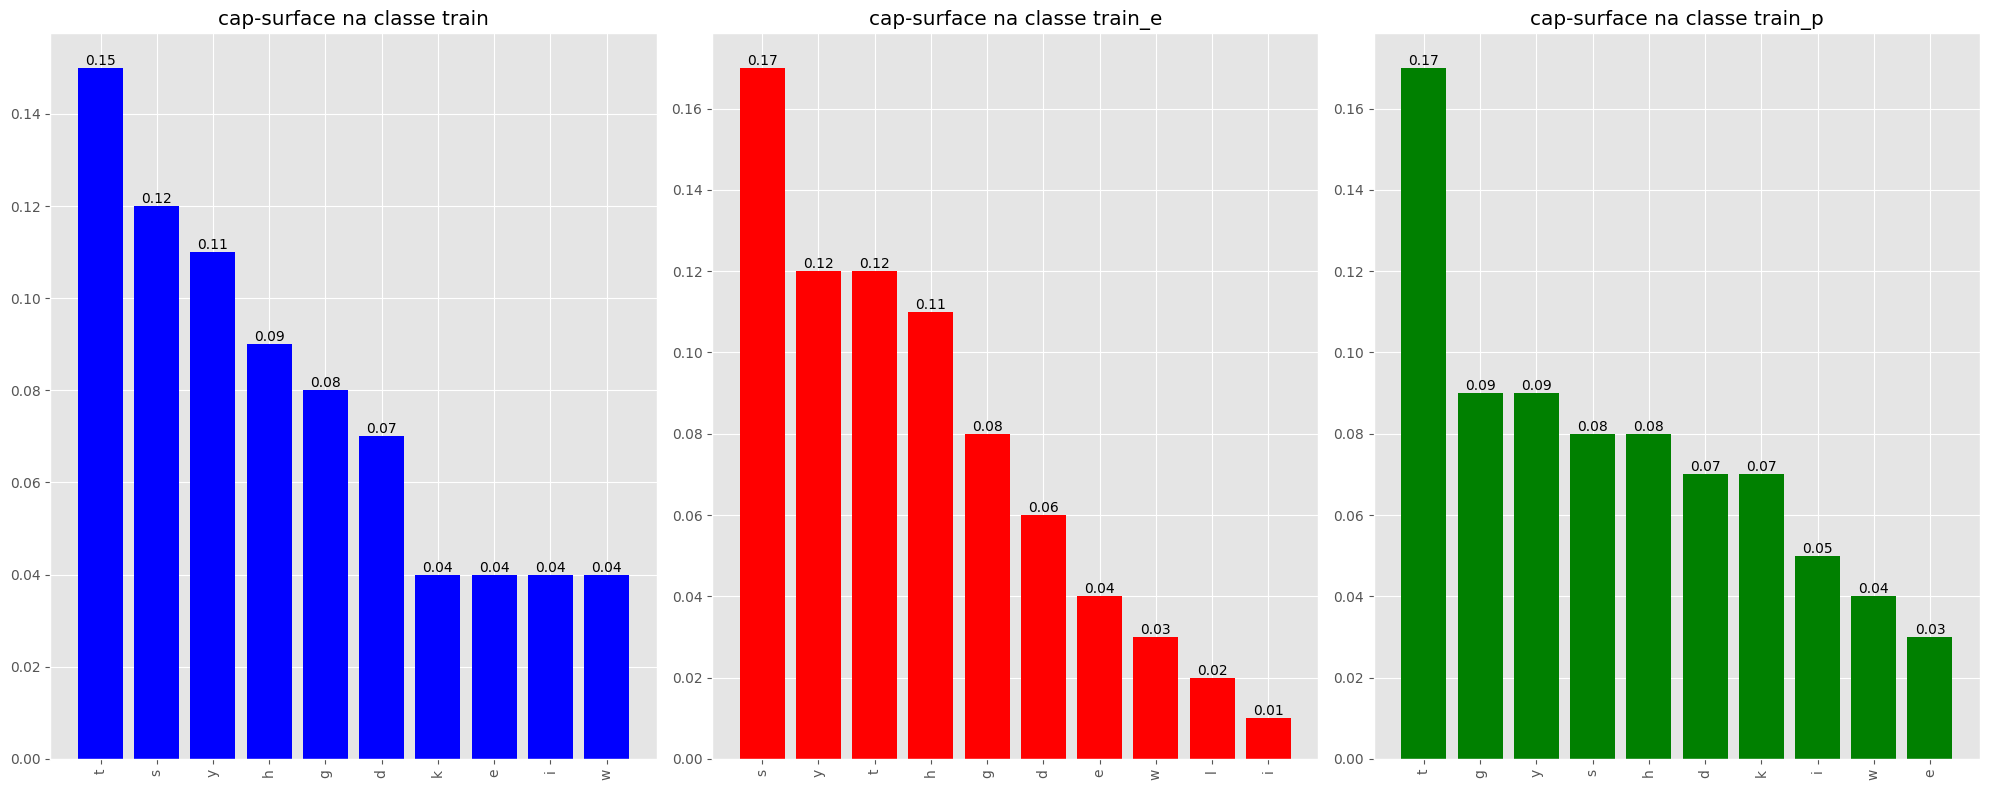

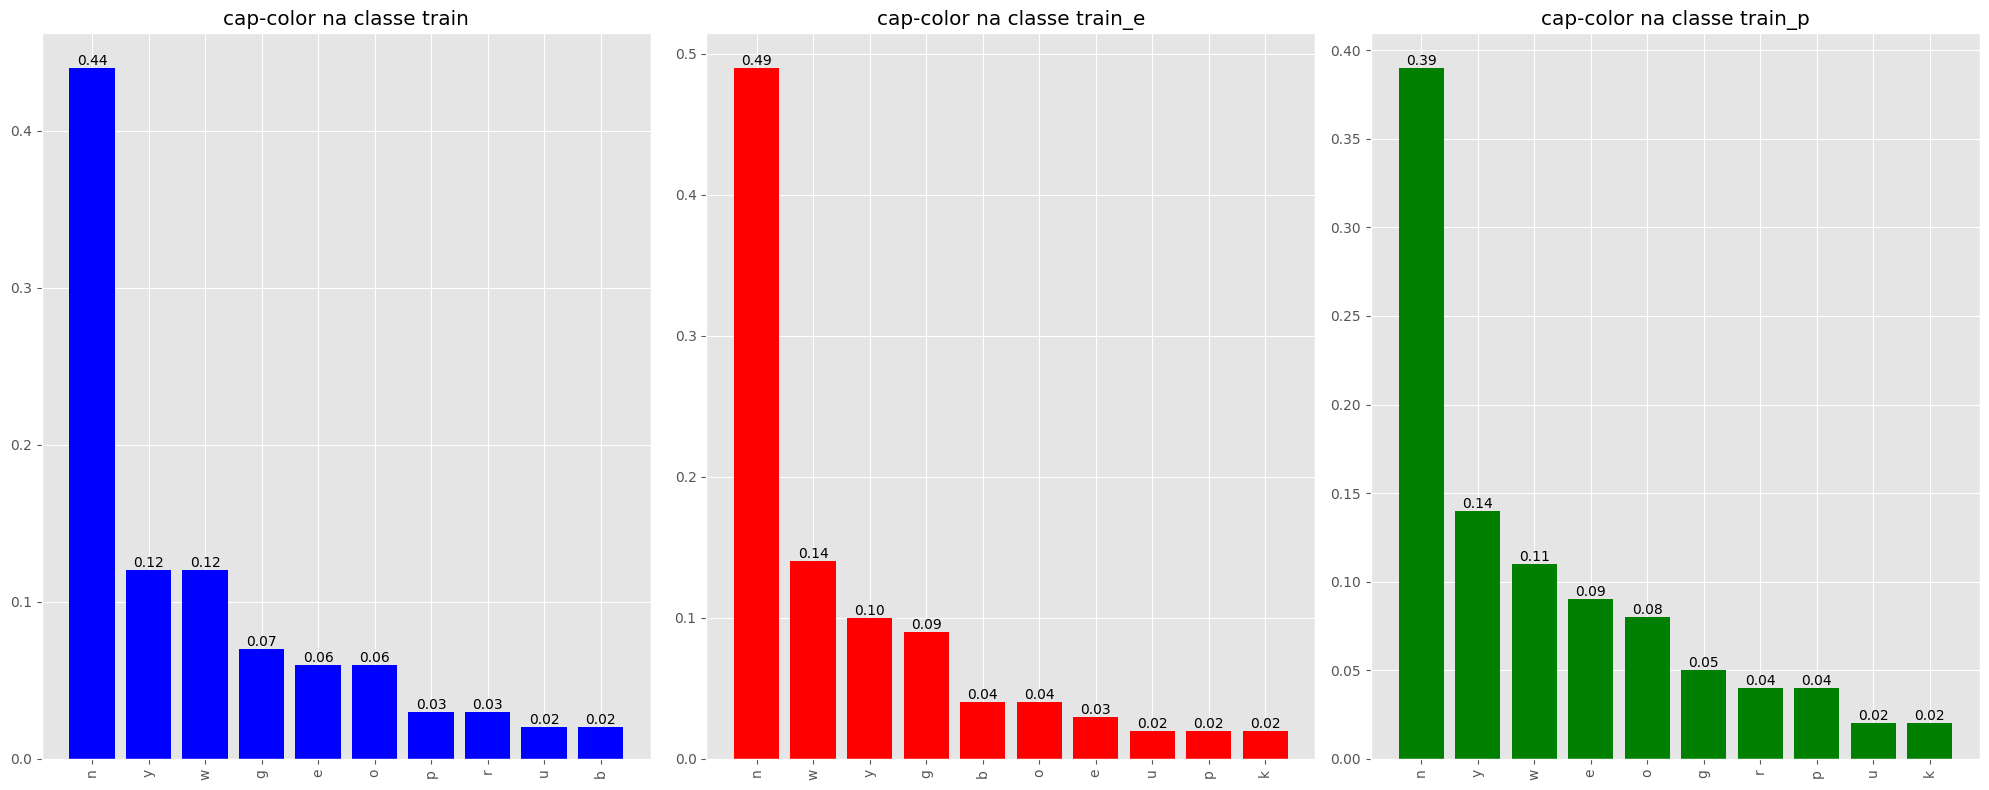

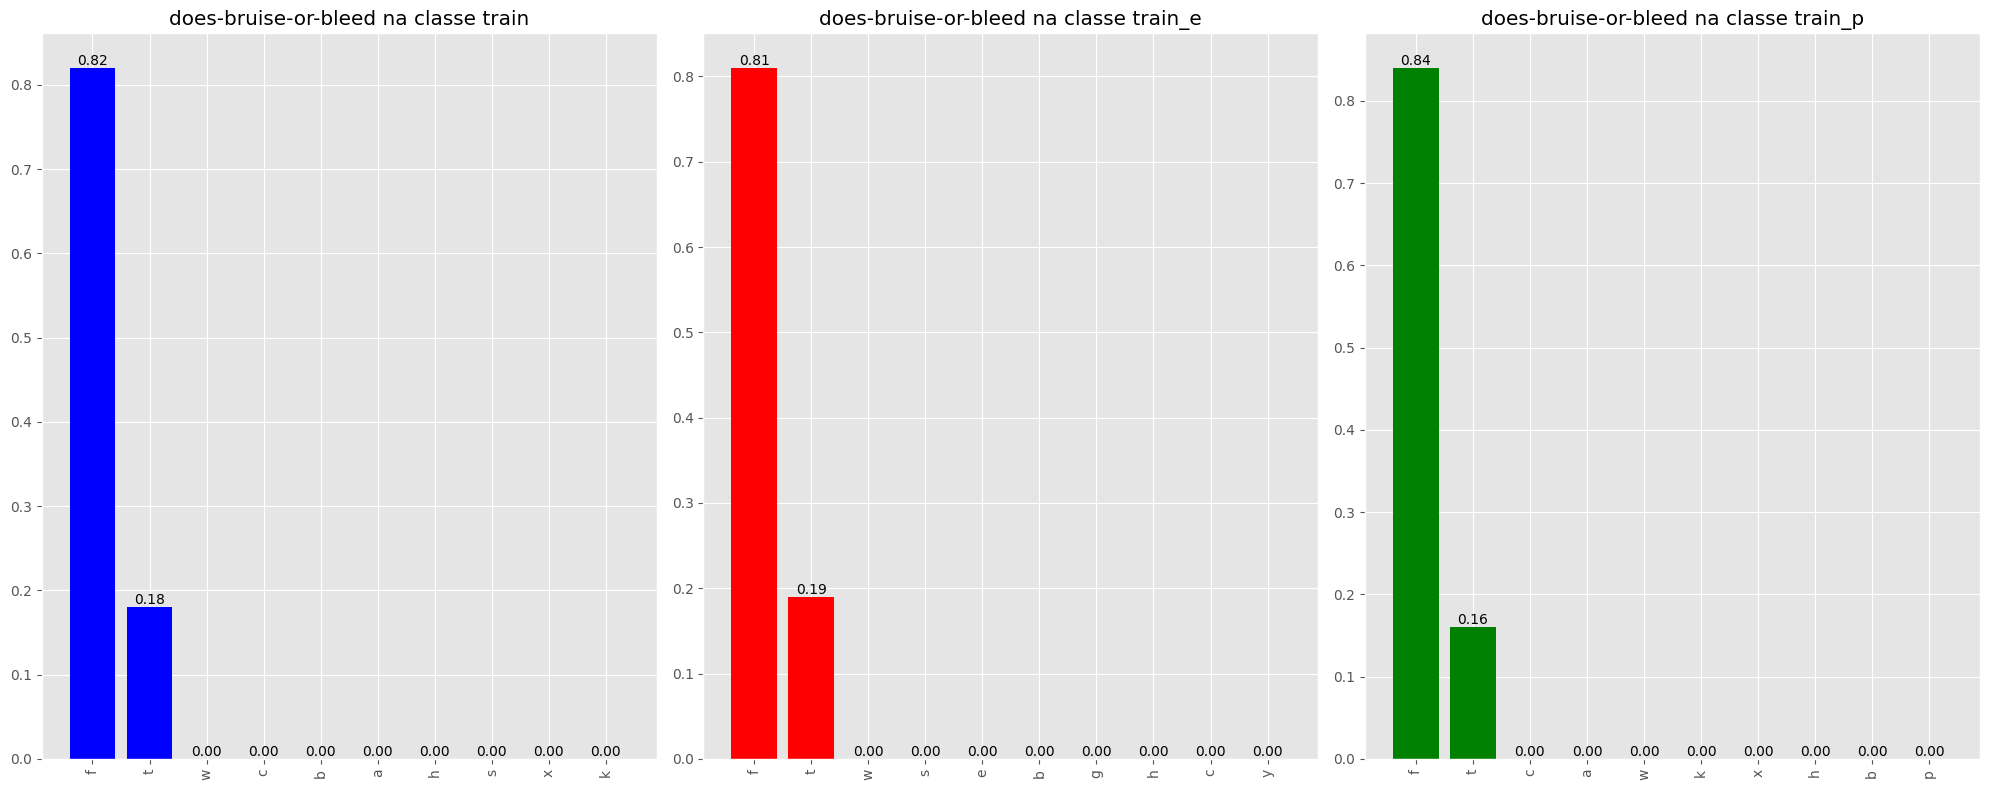

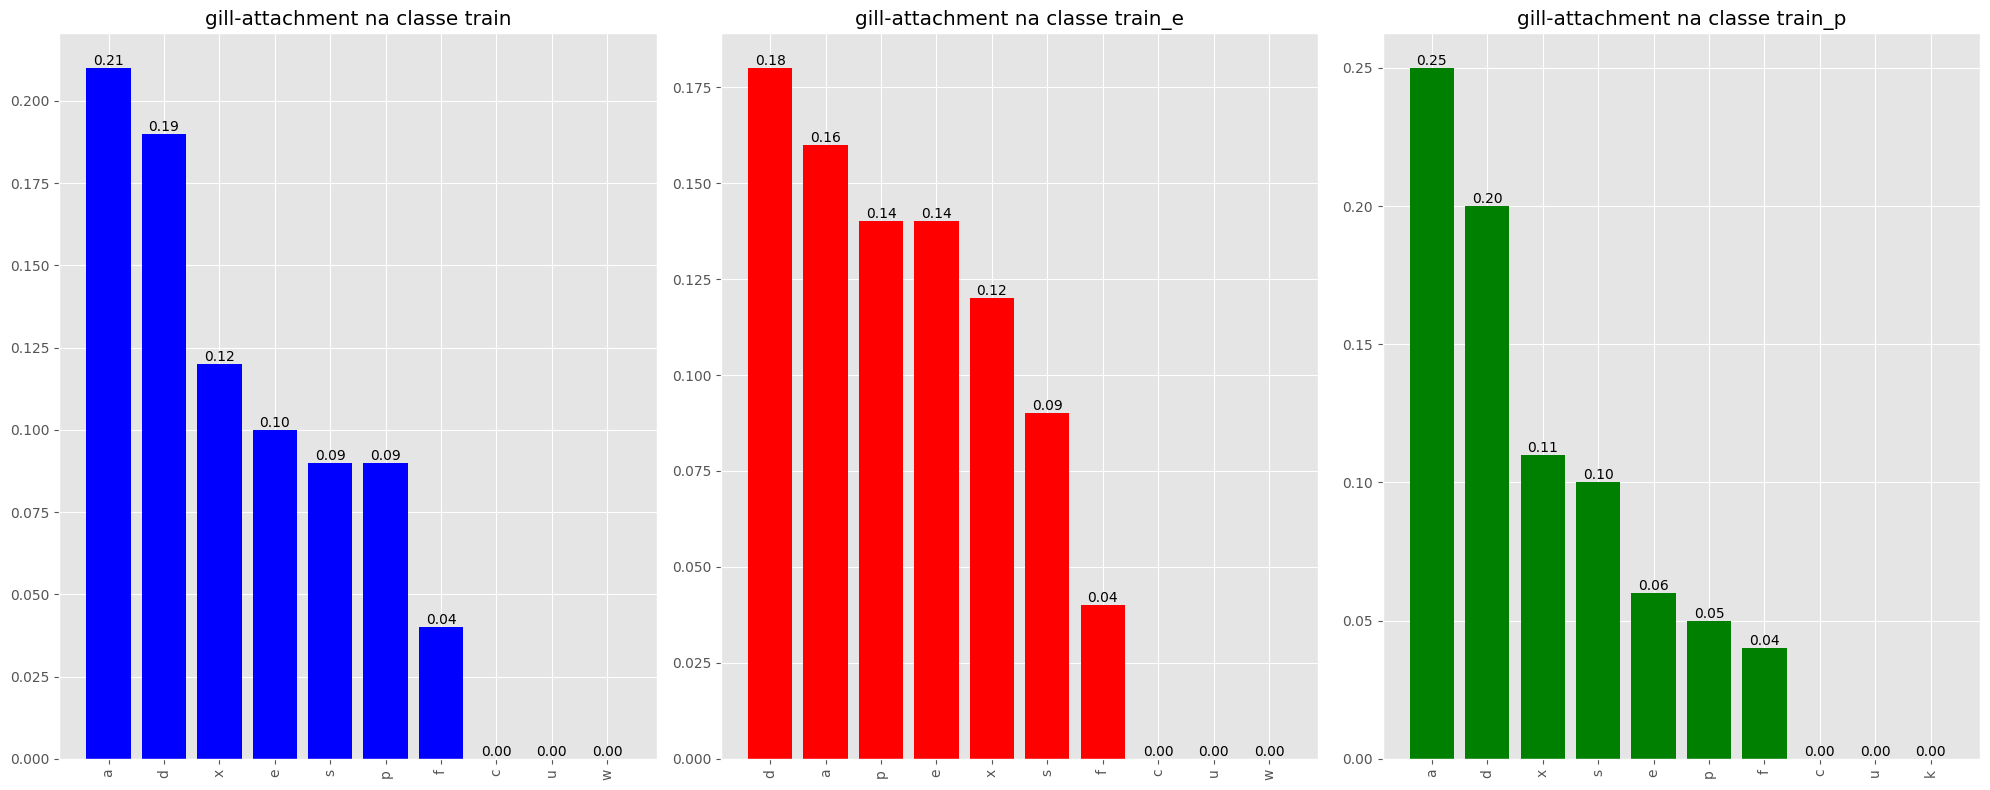

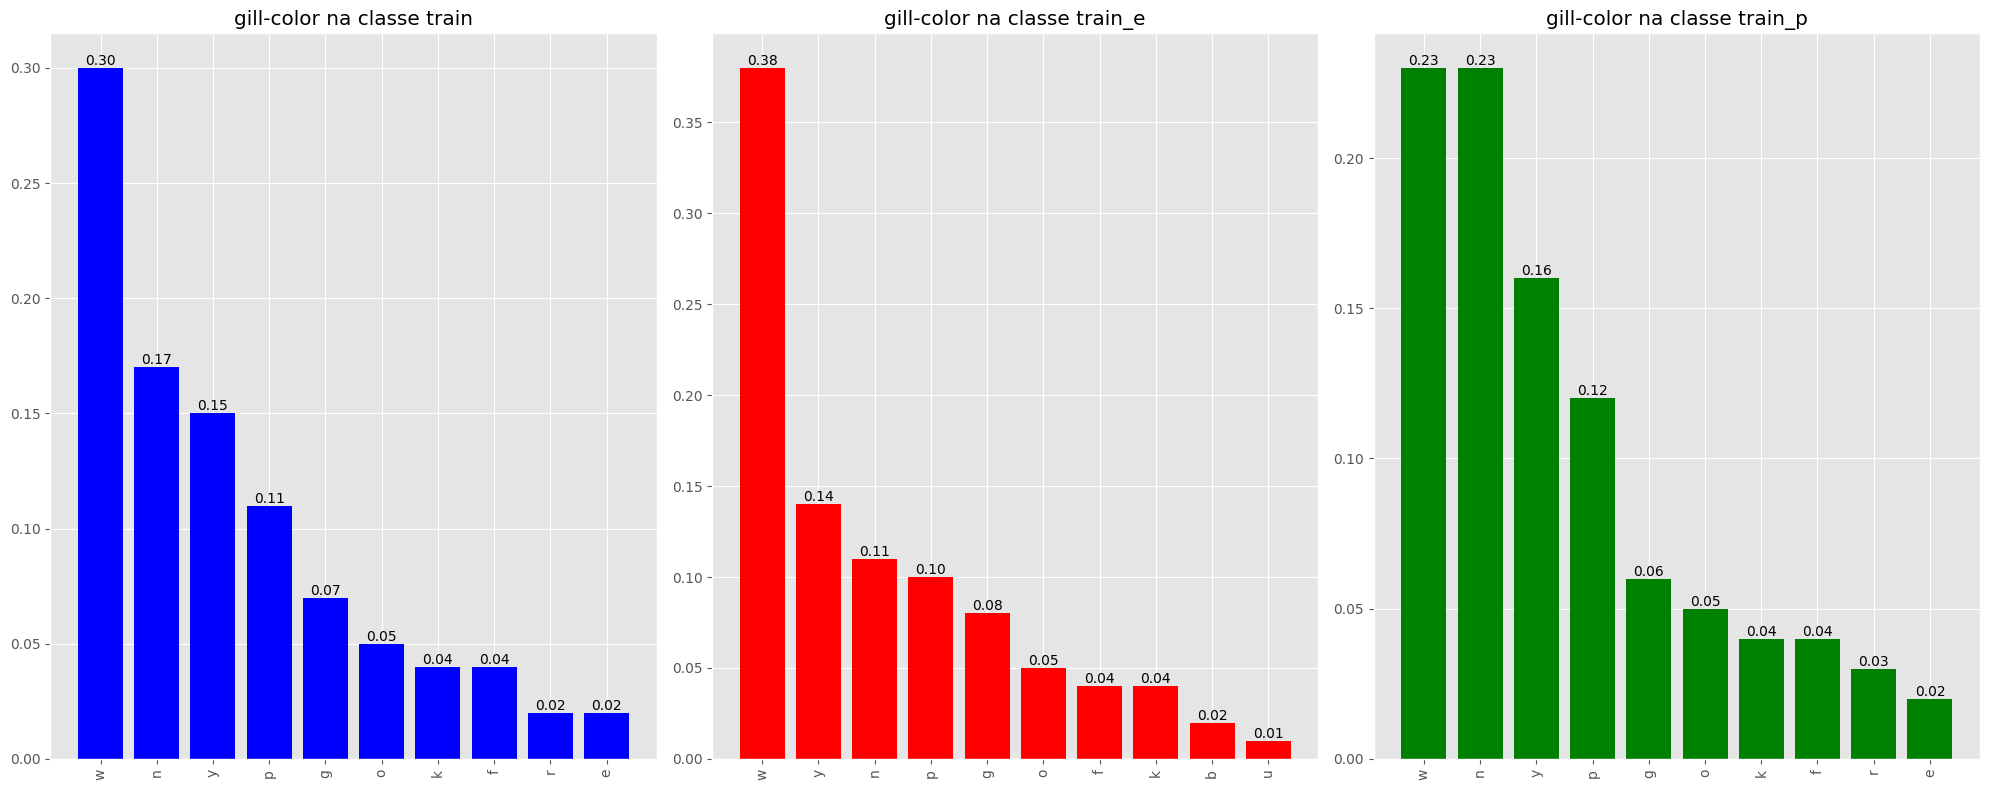

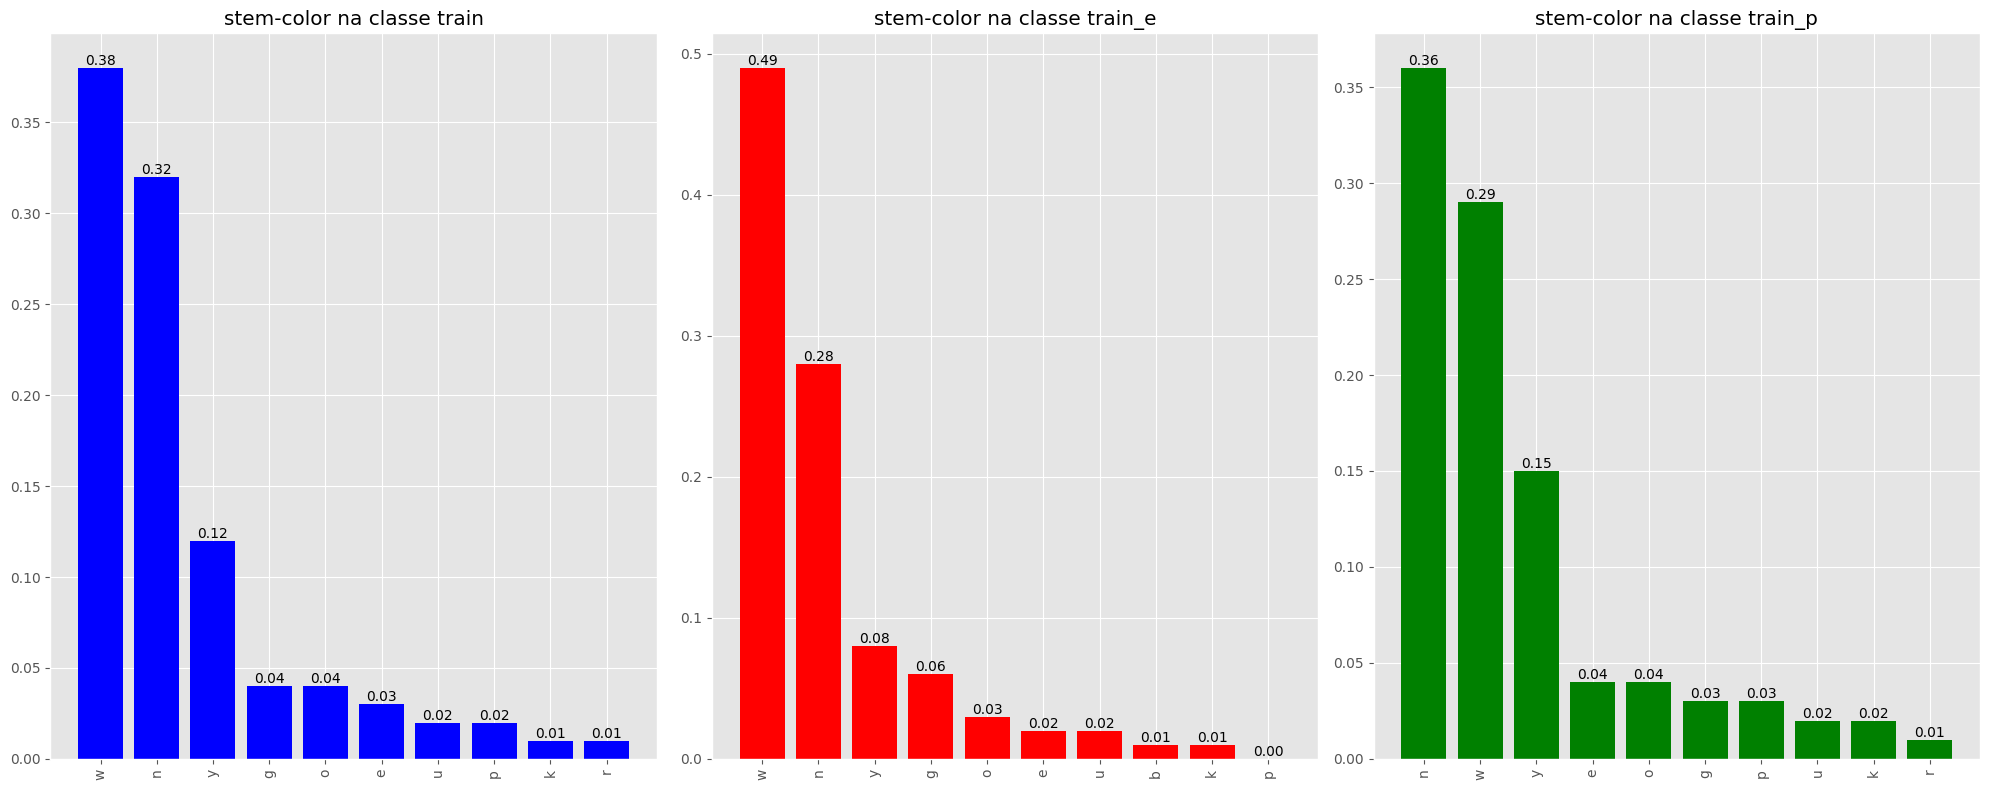

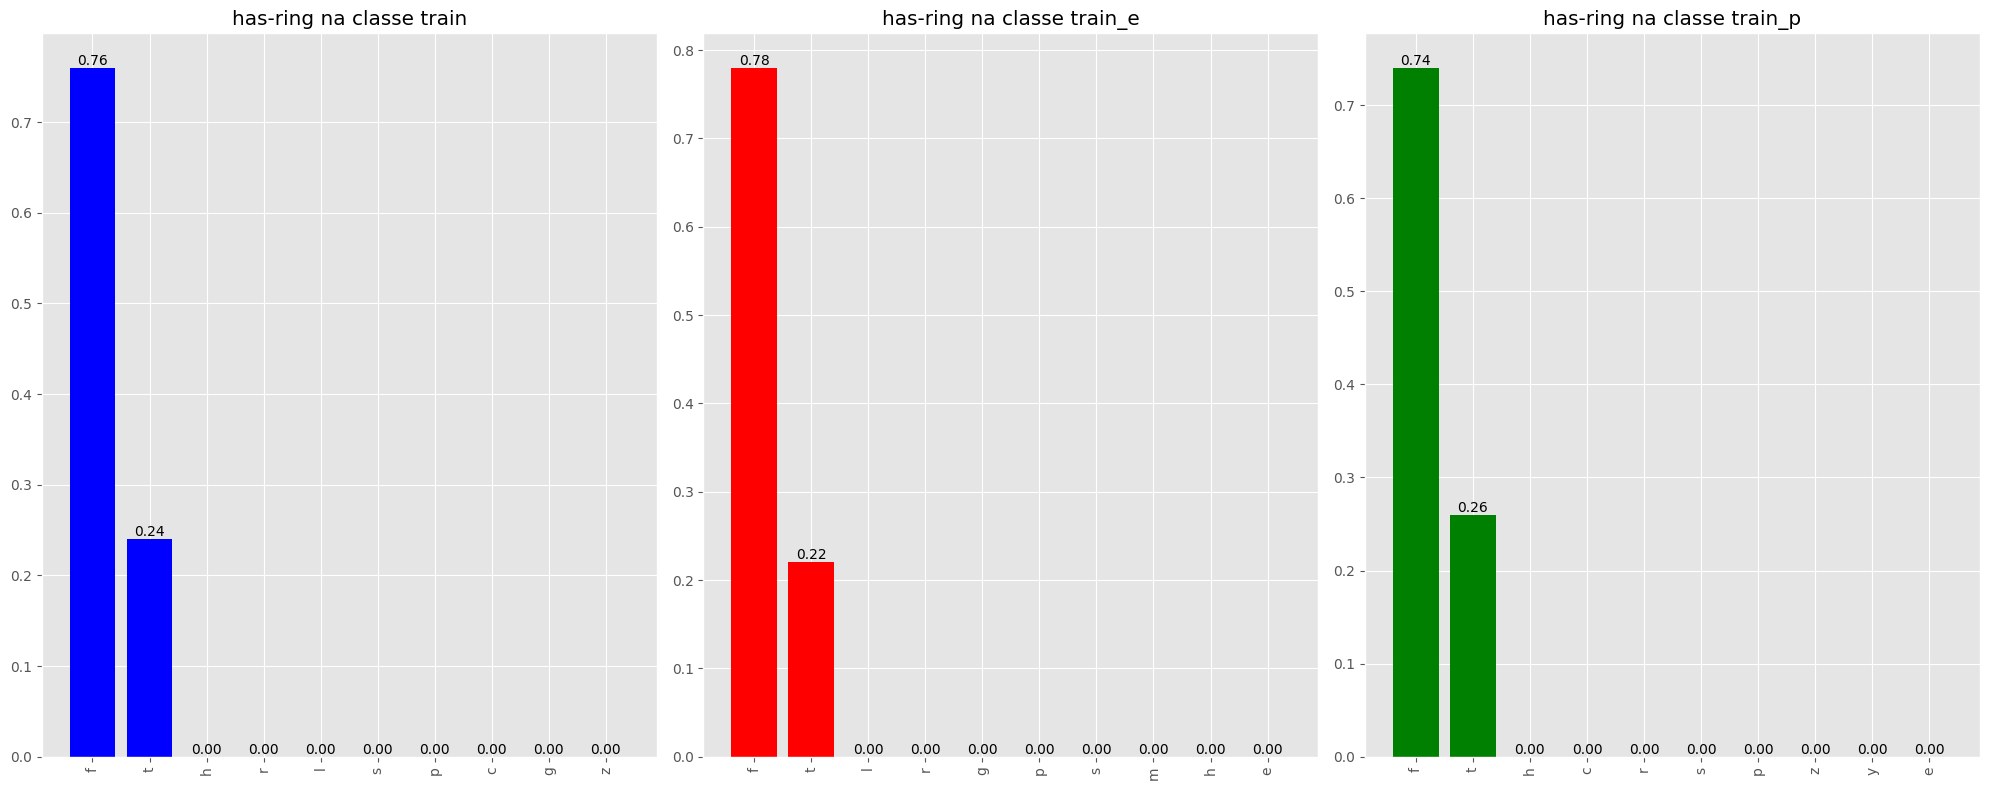

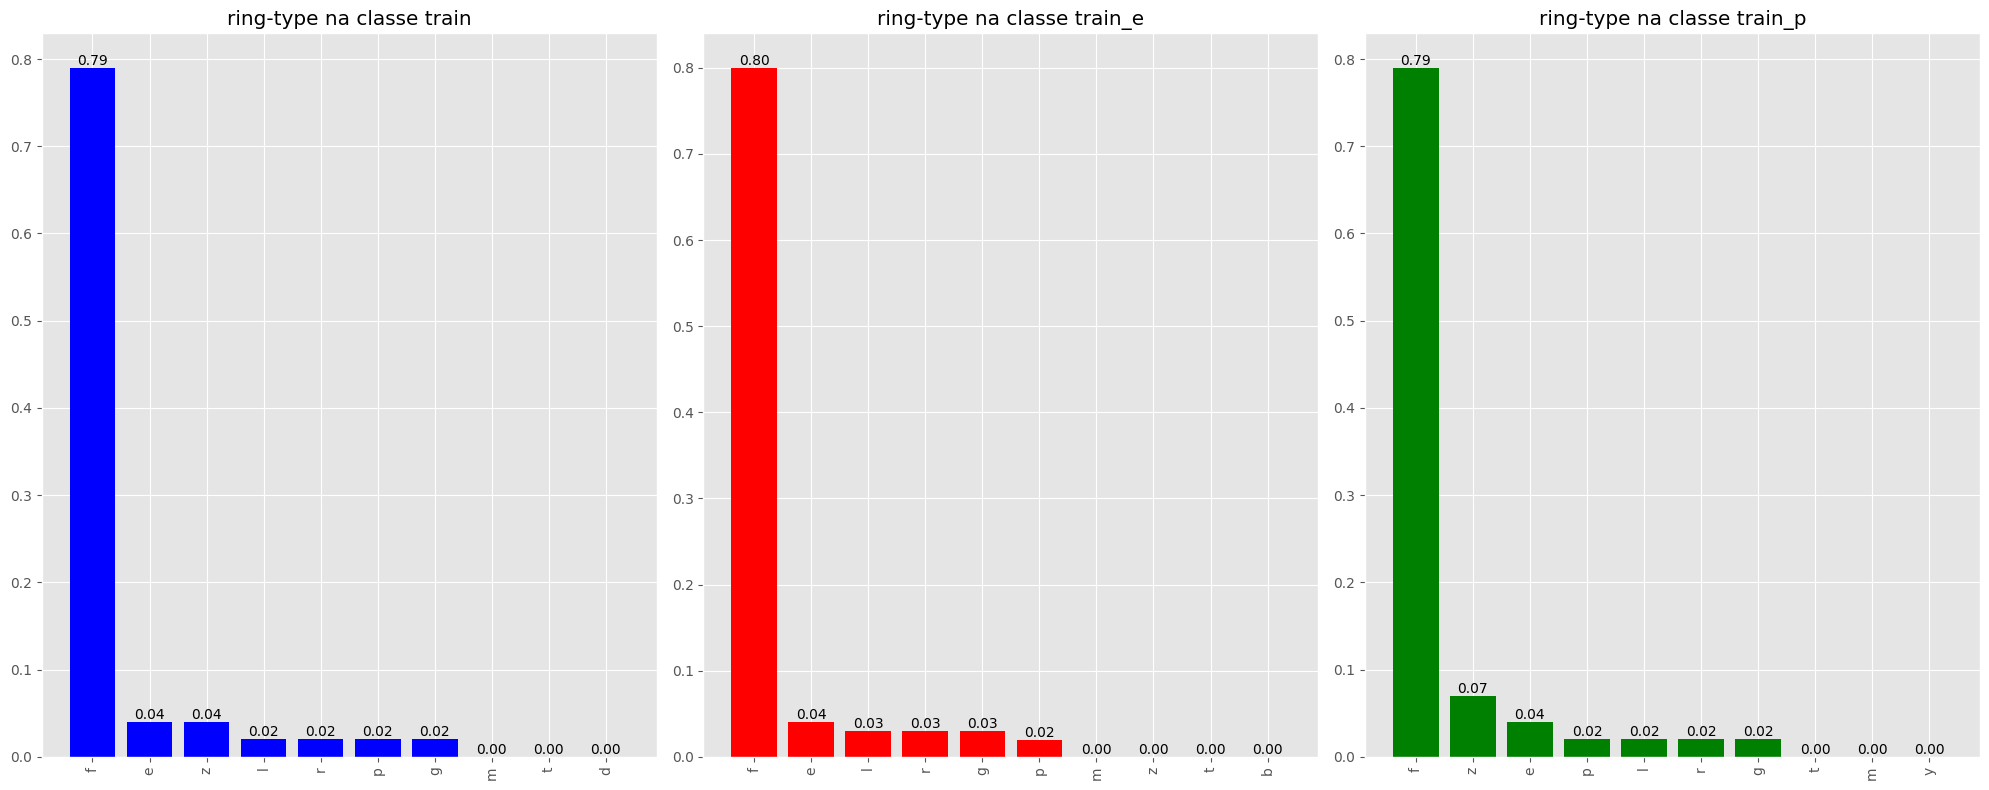

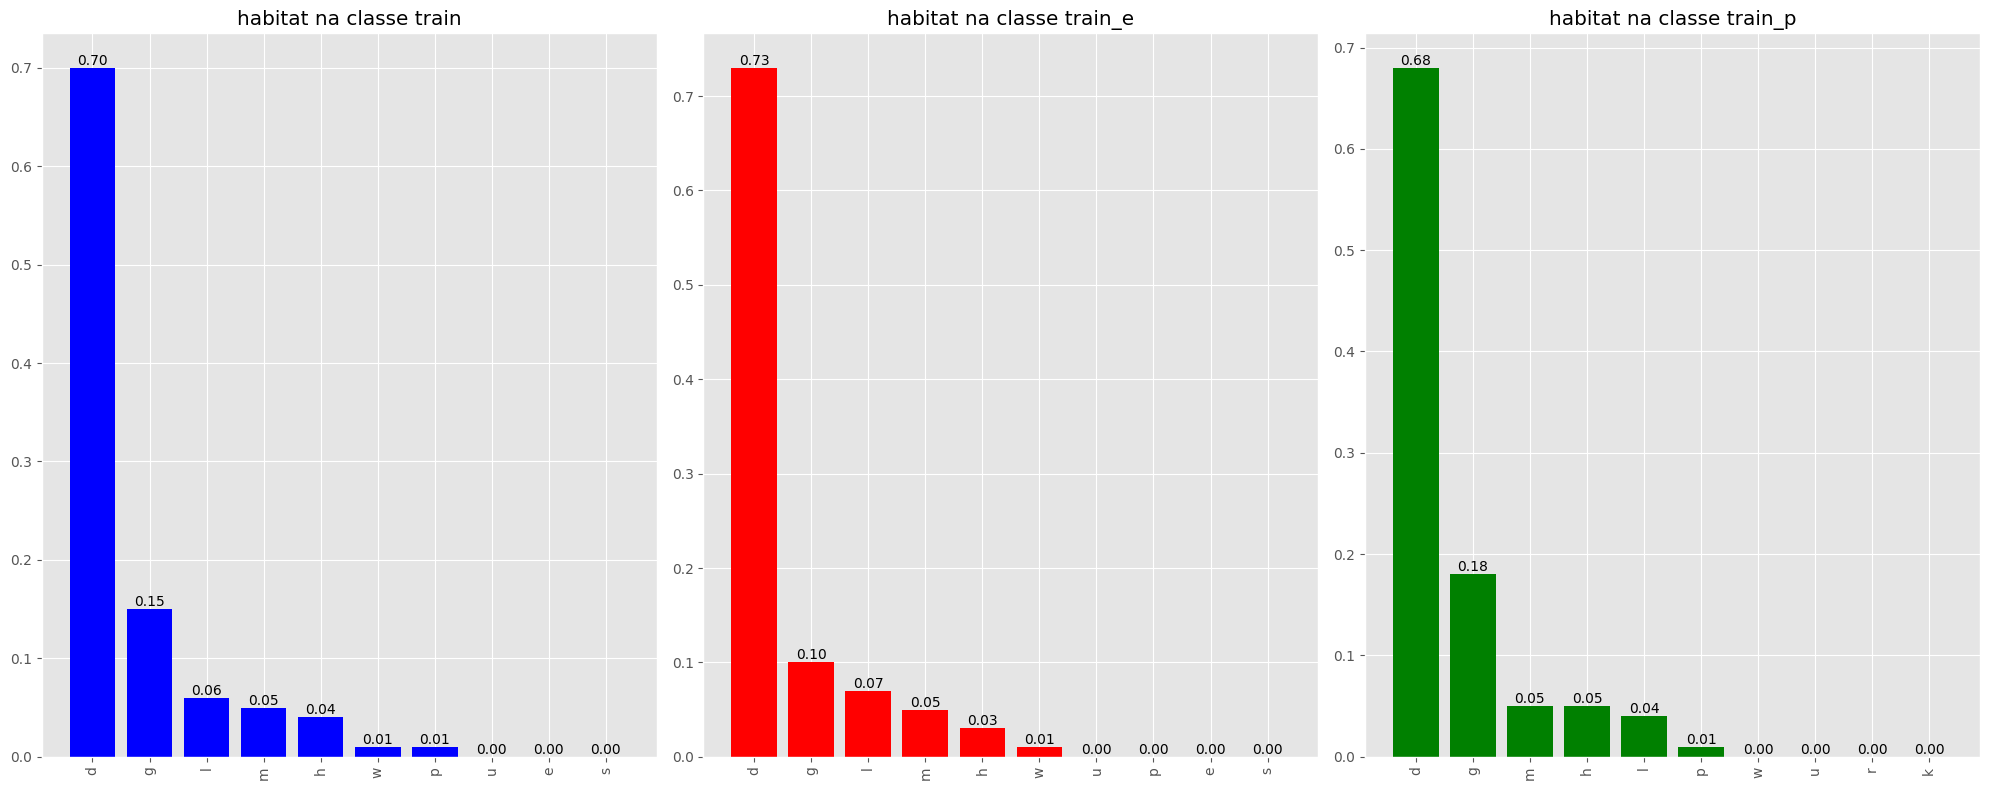

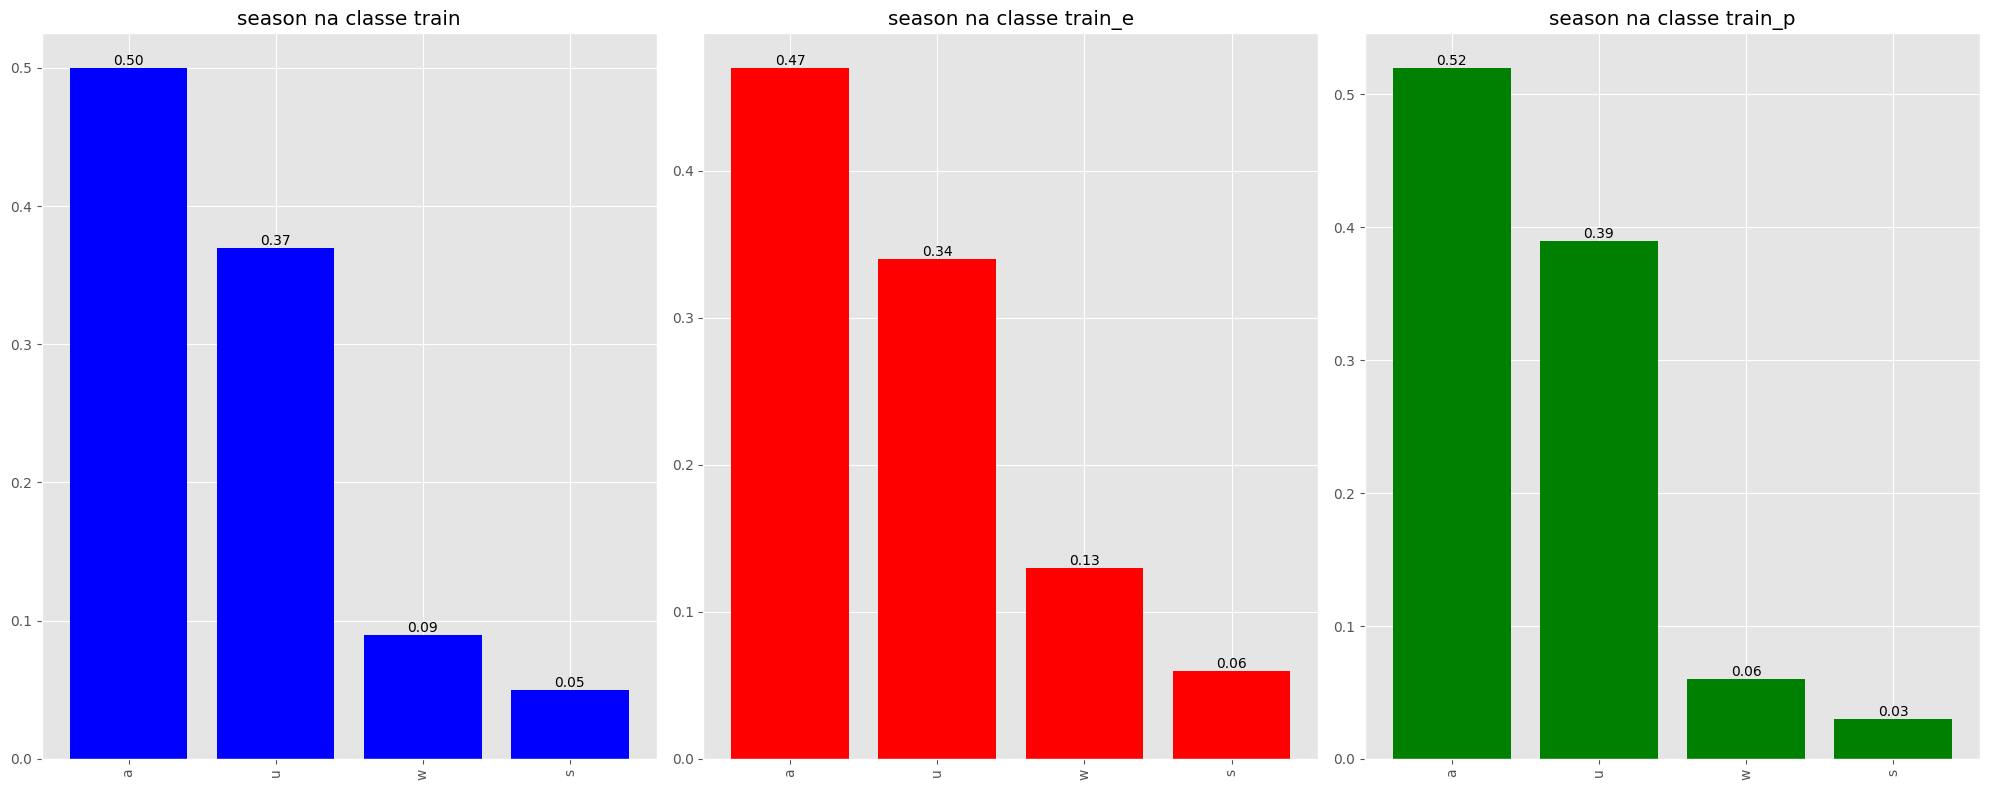

In [ ]:
for col in train.columns:
    if train[col].dtype != "float64":
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))

        train_class = (
            round(train[col].value_counts() / train.shape[0], 2)
            .head(10)
            .sort_values(ascending=False)
        )
        train_class_e = (
            round(train_e[col].value_counts() / train_e.shape[0], 2)
            .head(10)
            .sort_values(ascending=False)
        )
        train_class_p = (
            round(train_p[col].value_counts() / train_p.shape[0], 2)
            .head(10)
            .sort_values(ascending=False)
        )

        axes[0].bar(train_class.index, train_class.values, color="blue", label="train")
        axes[0].set_title(f"{col} na classe train")
        axes[0].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_class.values):
            axes[0].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        axes[1].bar(
            train_class_e.index, train_class_e.values, color="red", label="train_e"
        )
        axes[1].set_title(f"{col} na classe train_e")
        axes[1].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_class_e.values):
            axes[1].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        axes[2].bar(
            train_class_p.index, train_class_p.values, color="green", label="train_p"
        )
        axes[2].set_title(f"{col} na classe train_p")
        axes[2].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_class_p.values):
            axes[2].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        plt.tight_layout()
        plt.show()

**Nos proximos graficos faremos a soma acumulada das porcentagens das categorias**

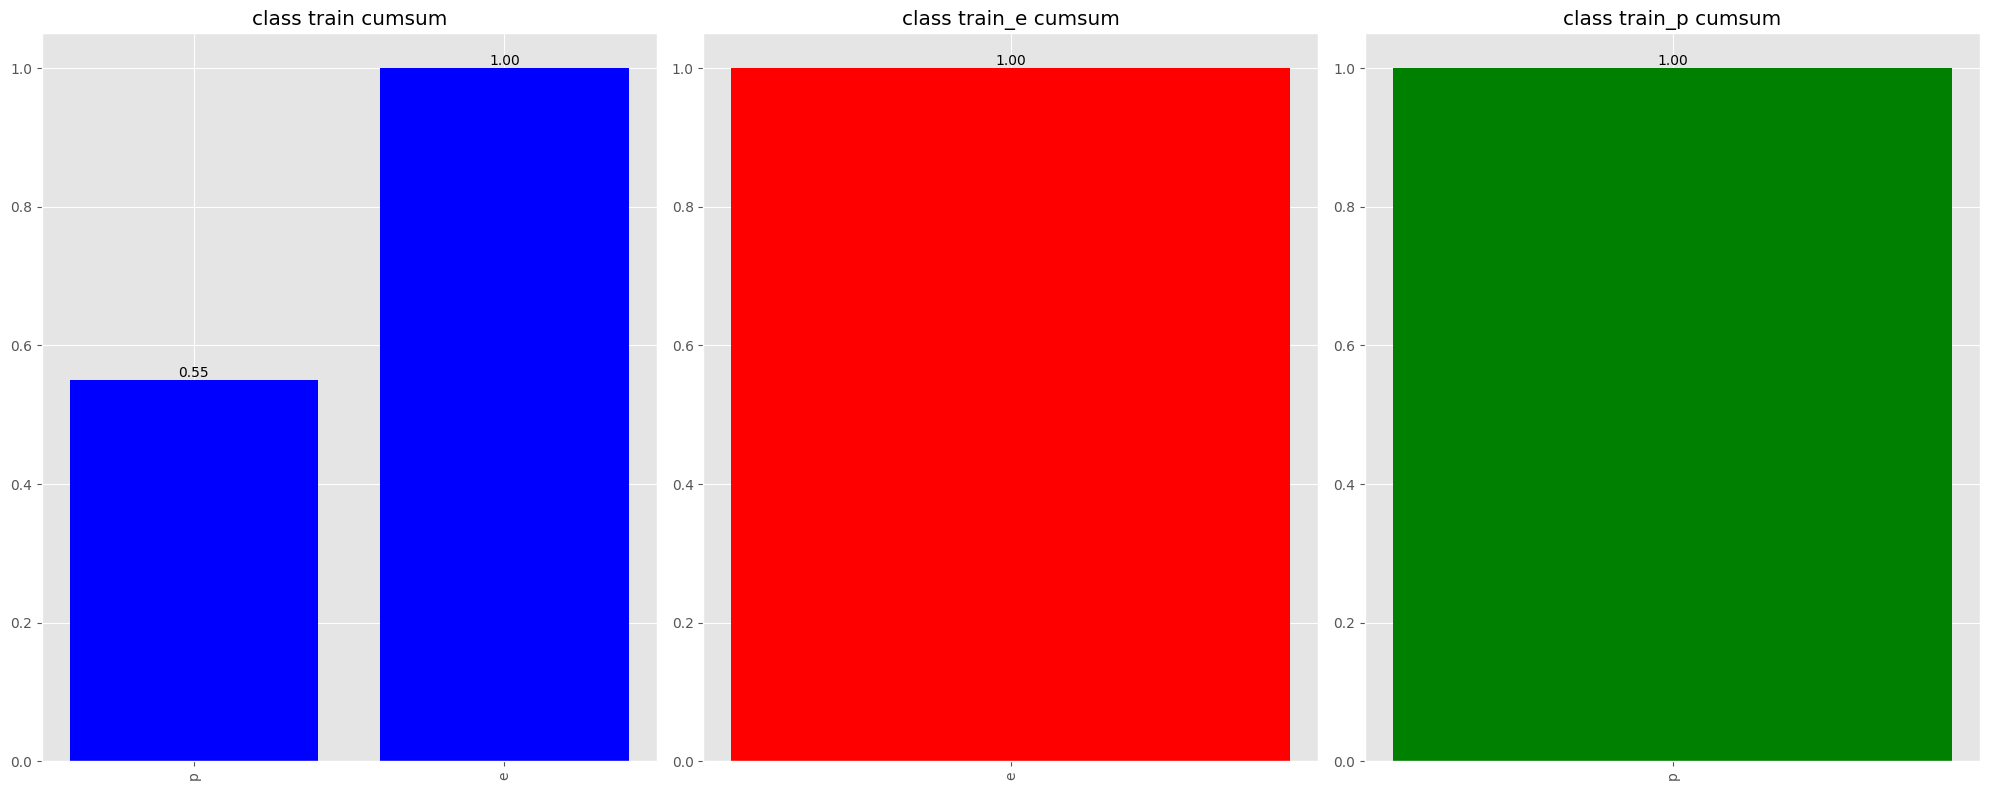

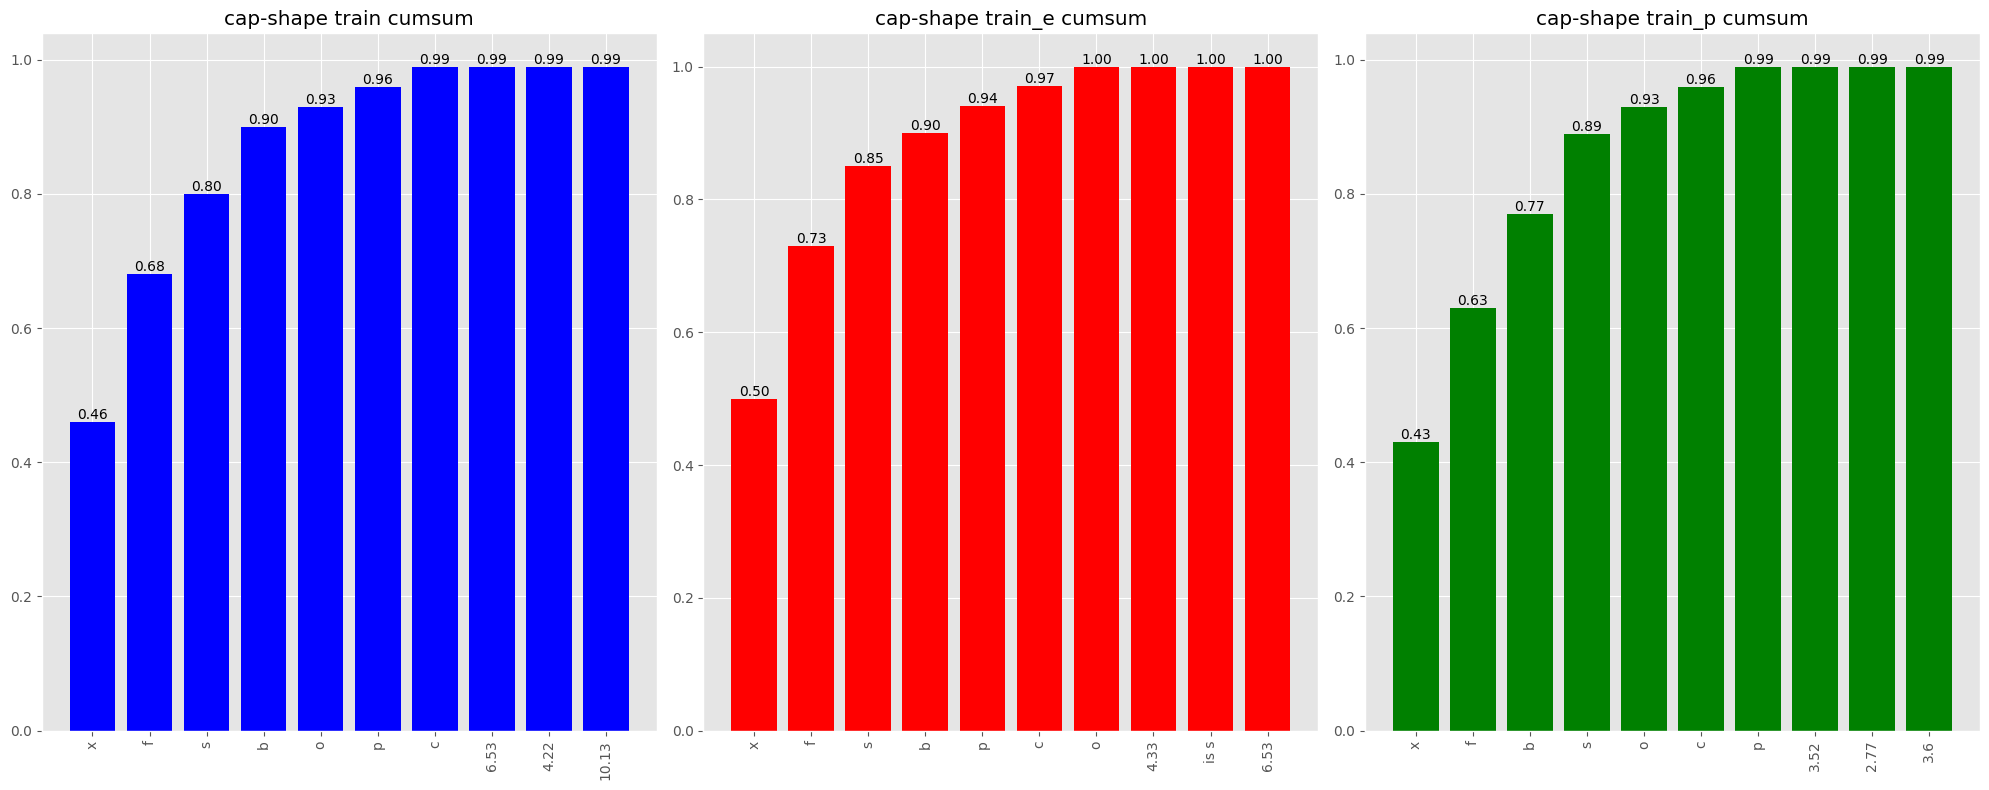

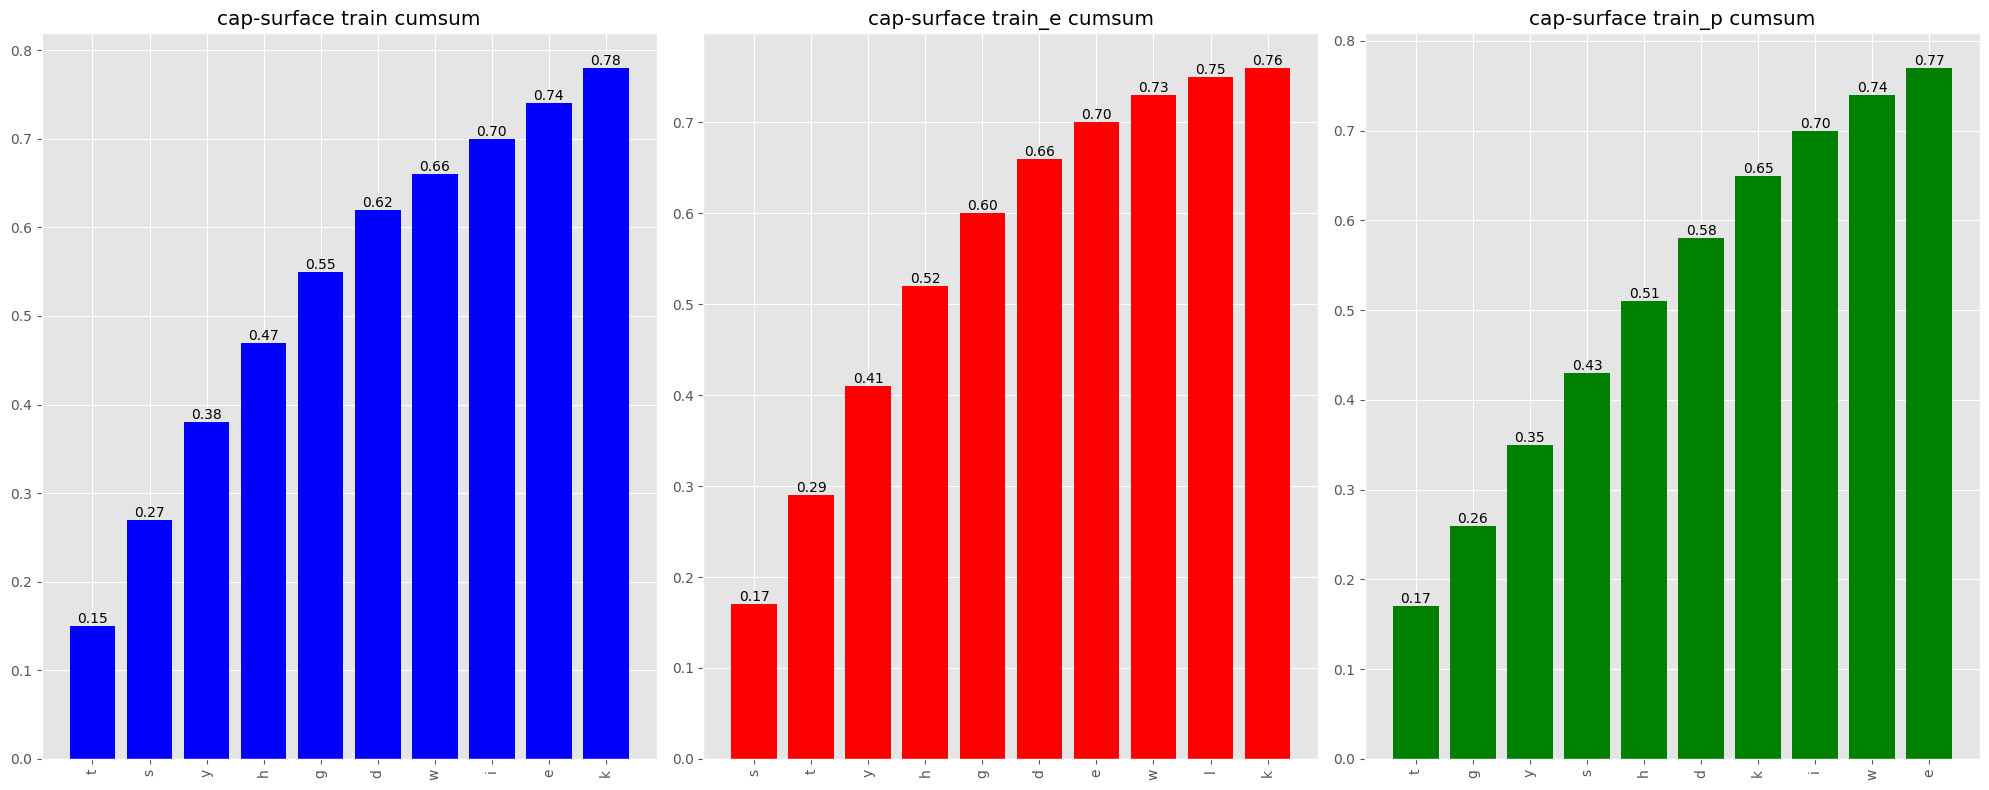

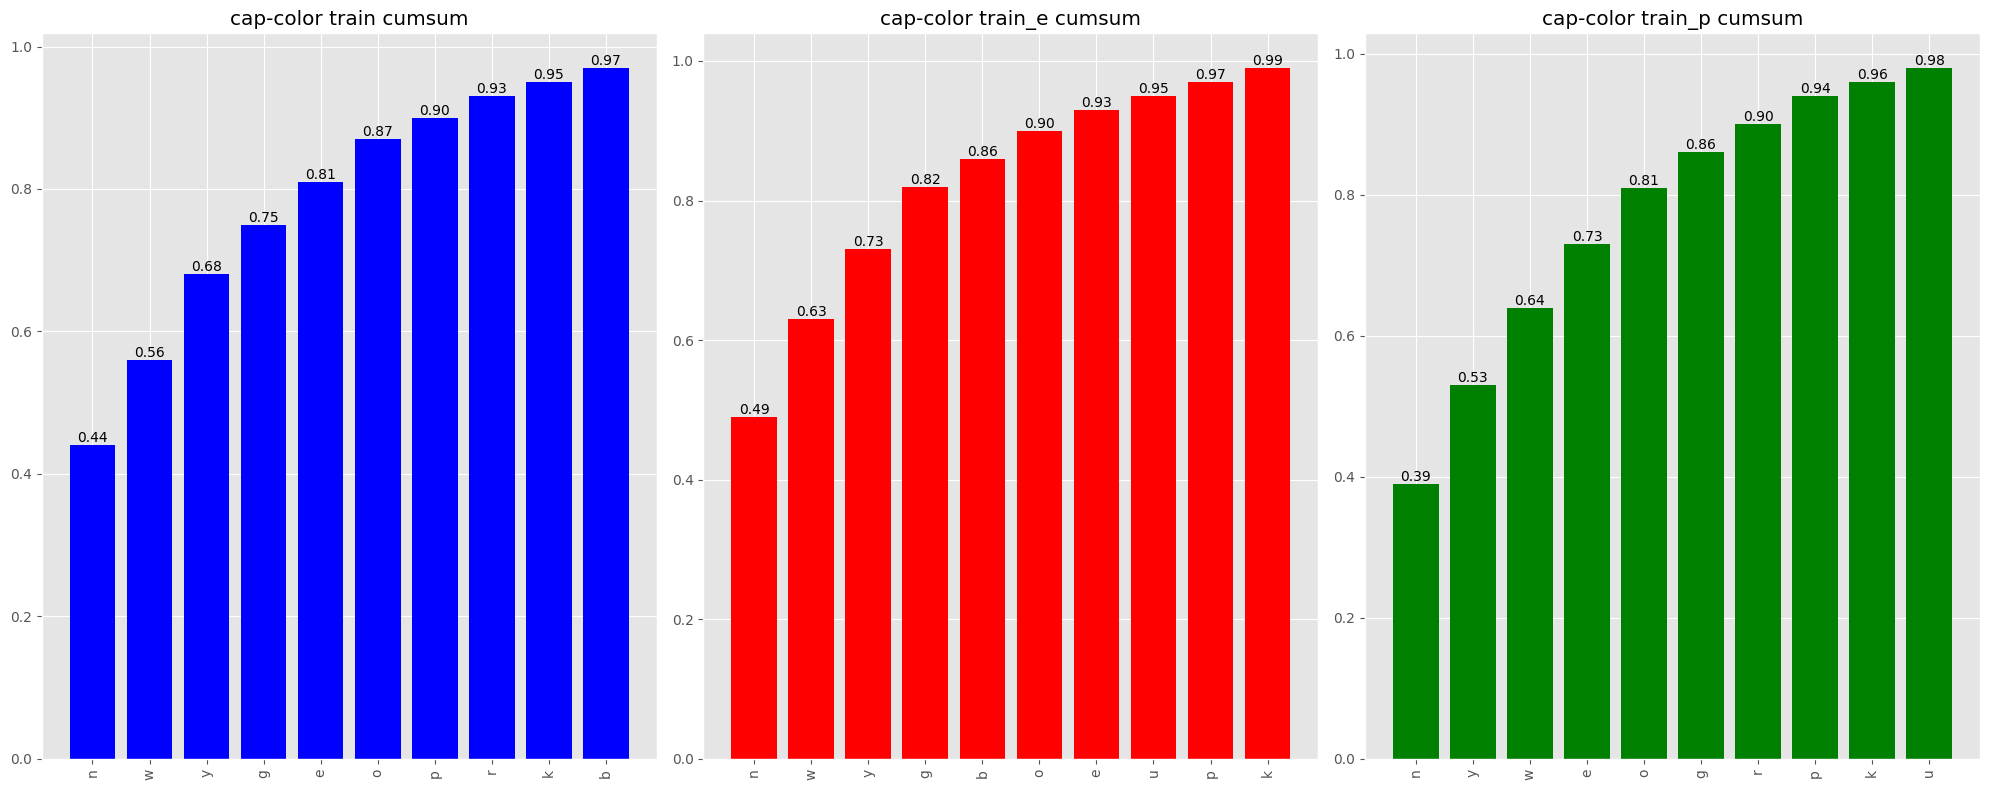

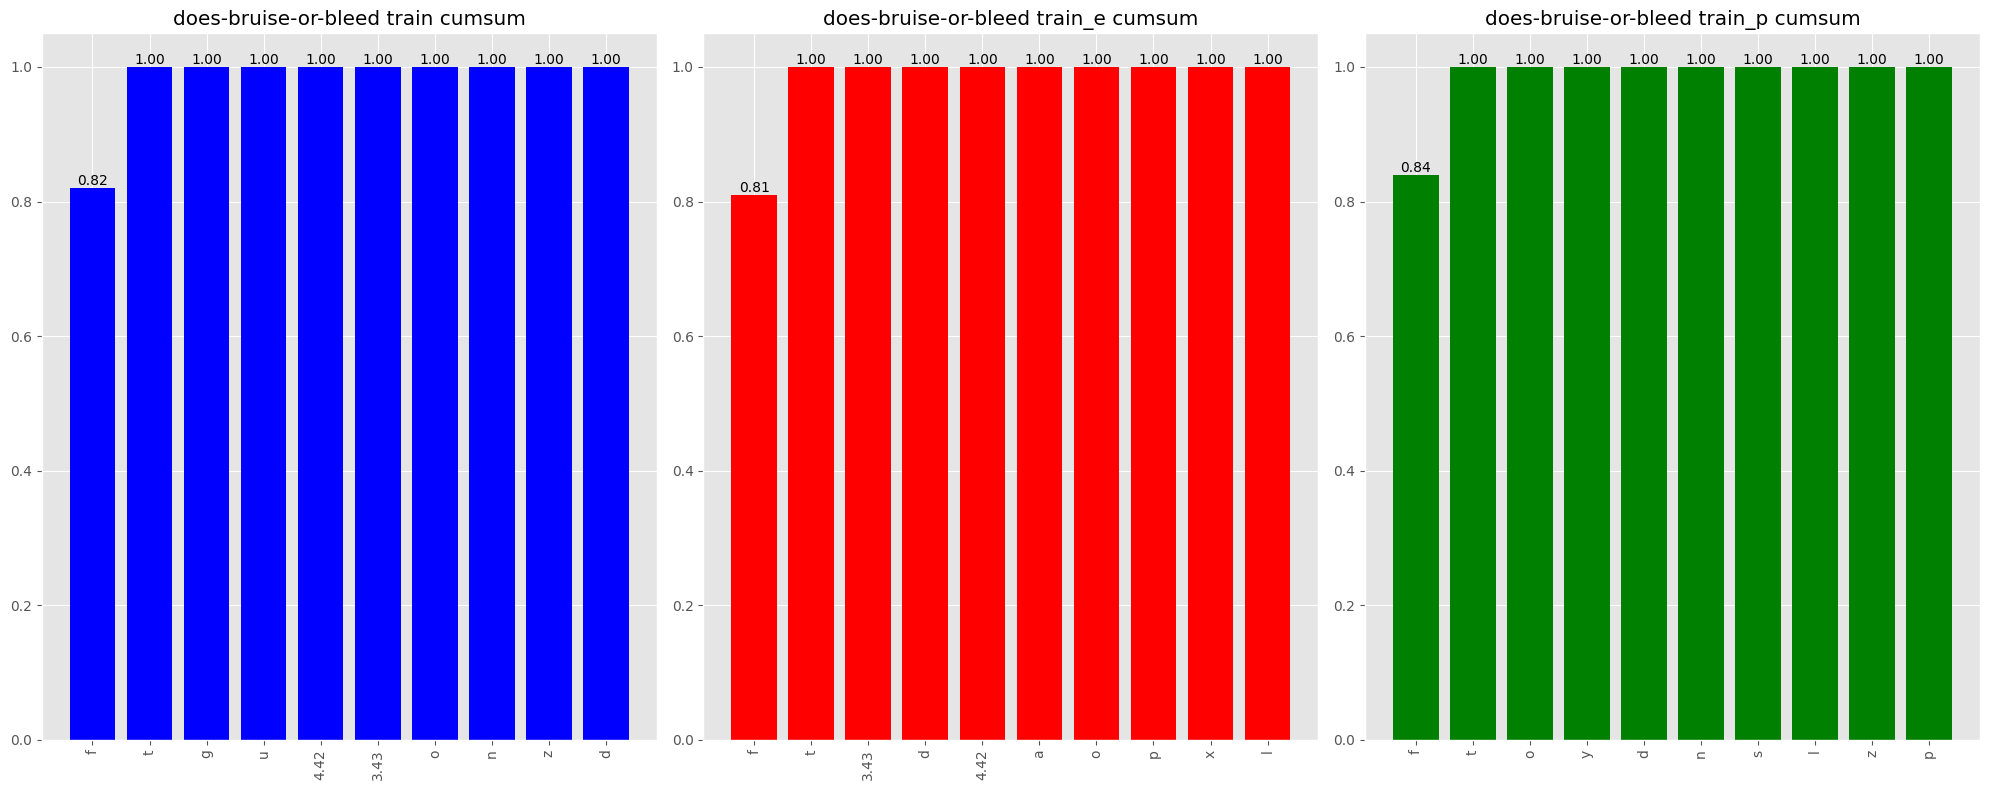

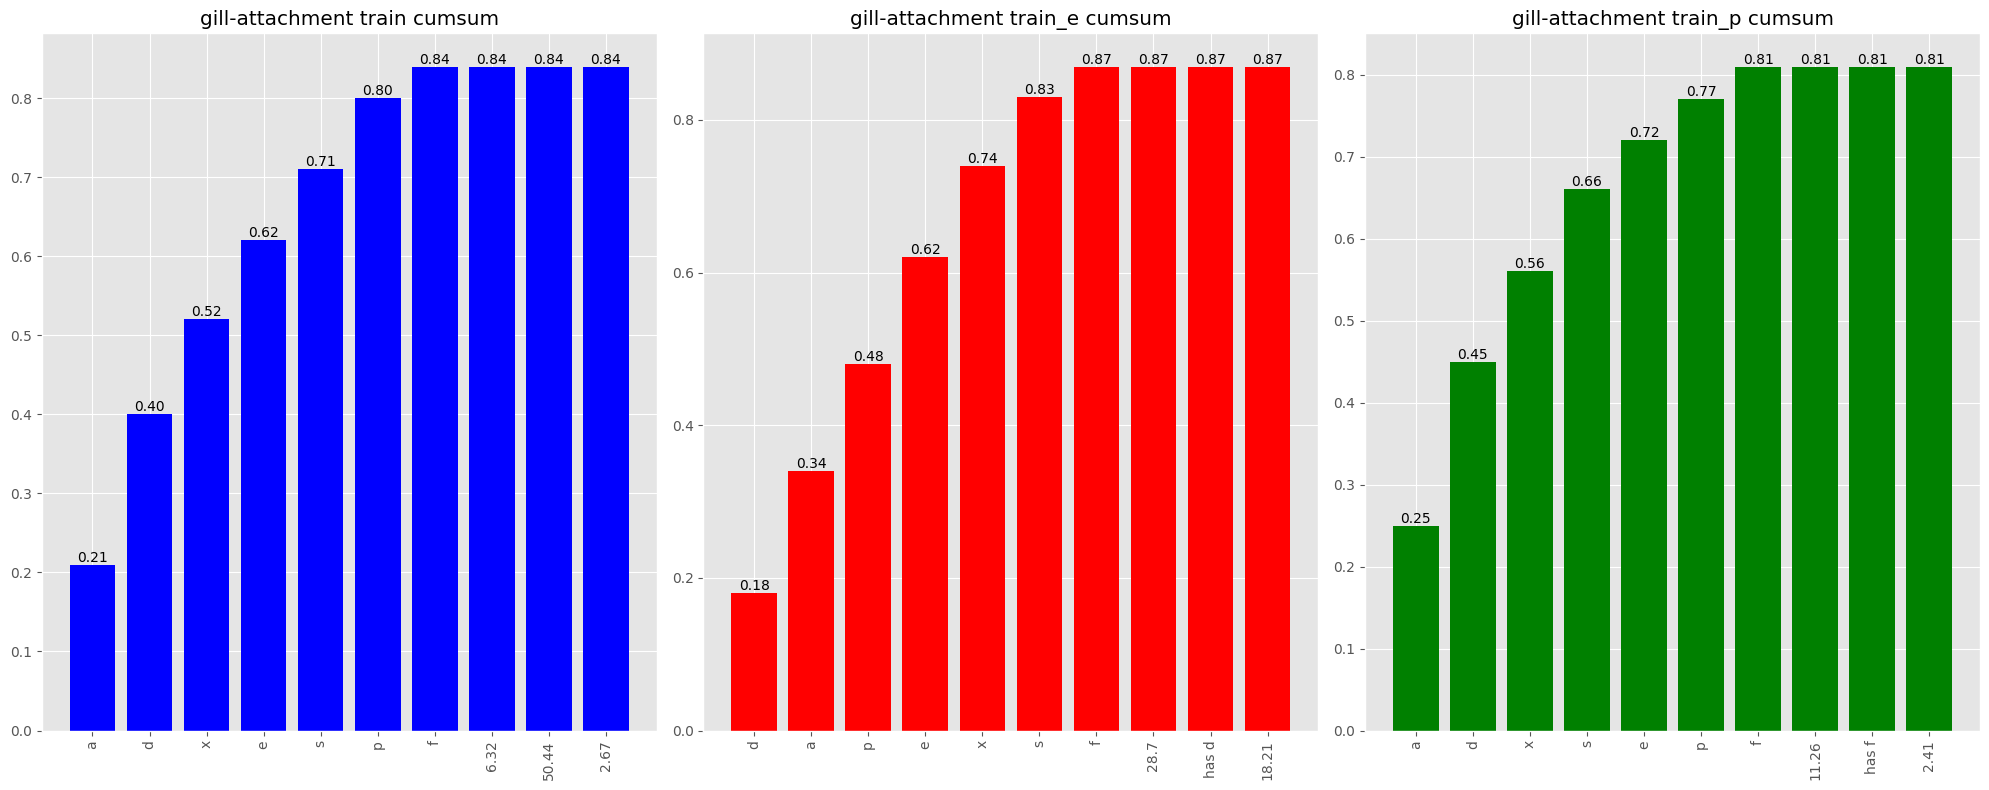

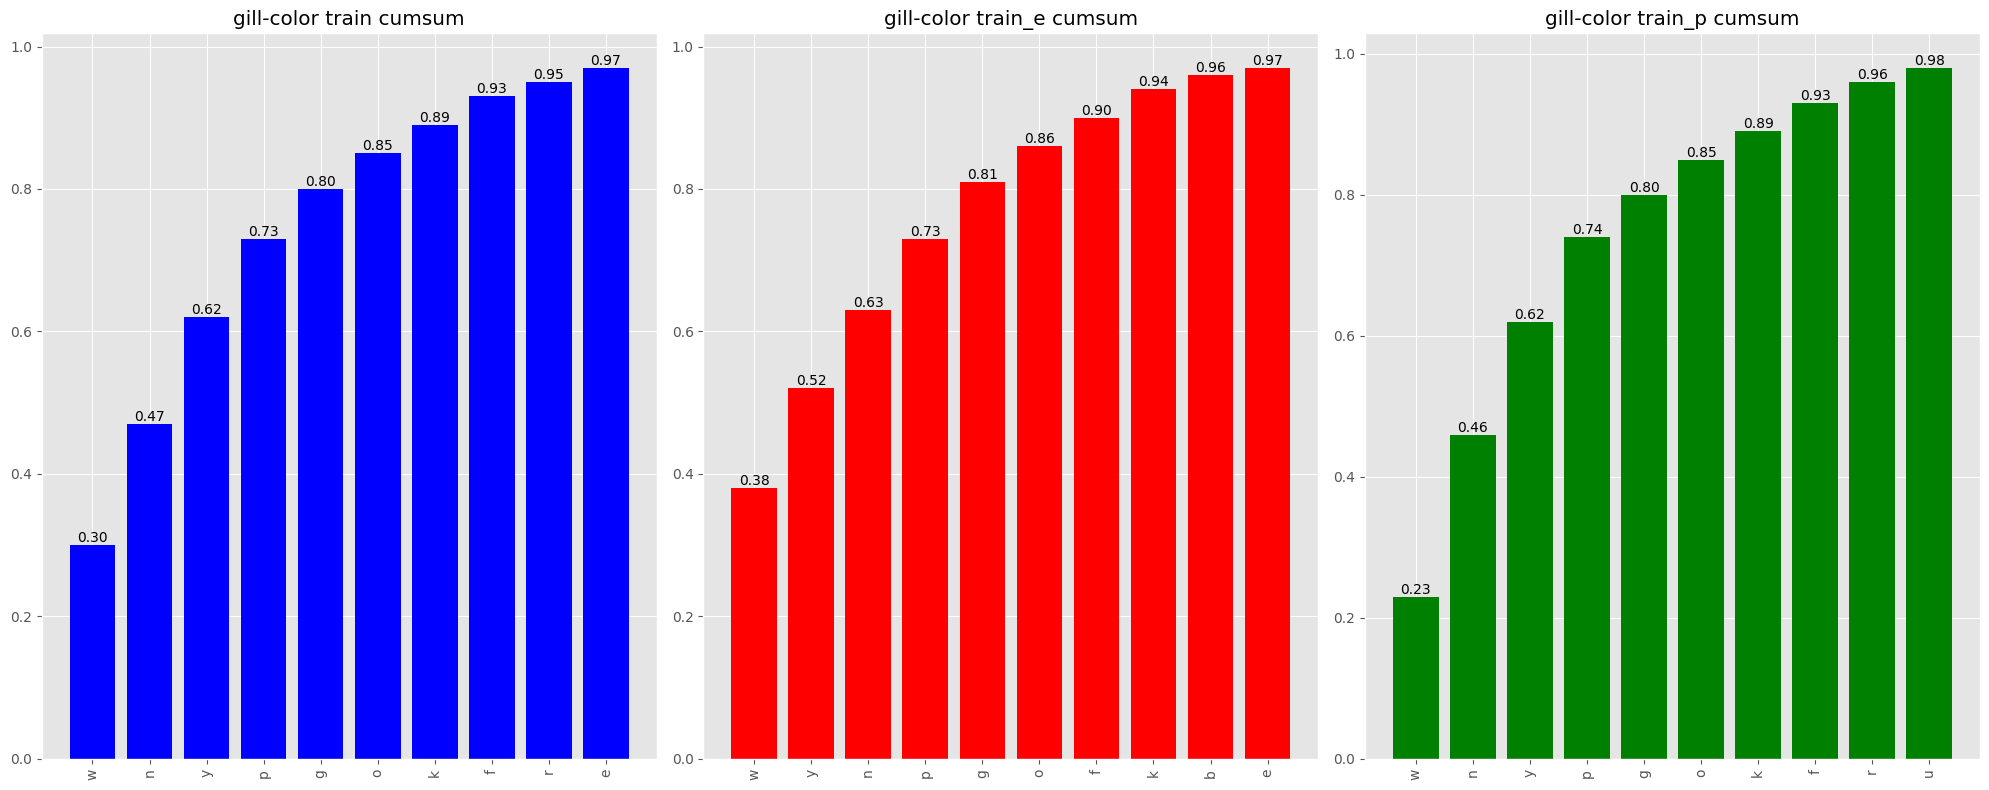

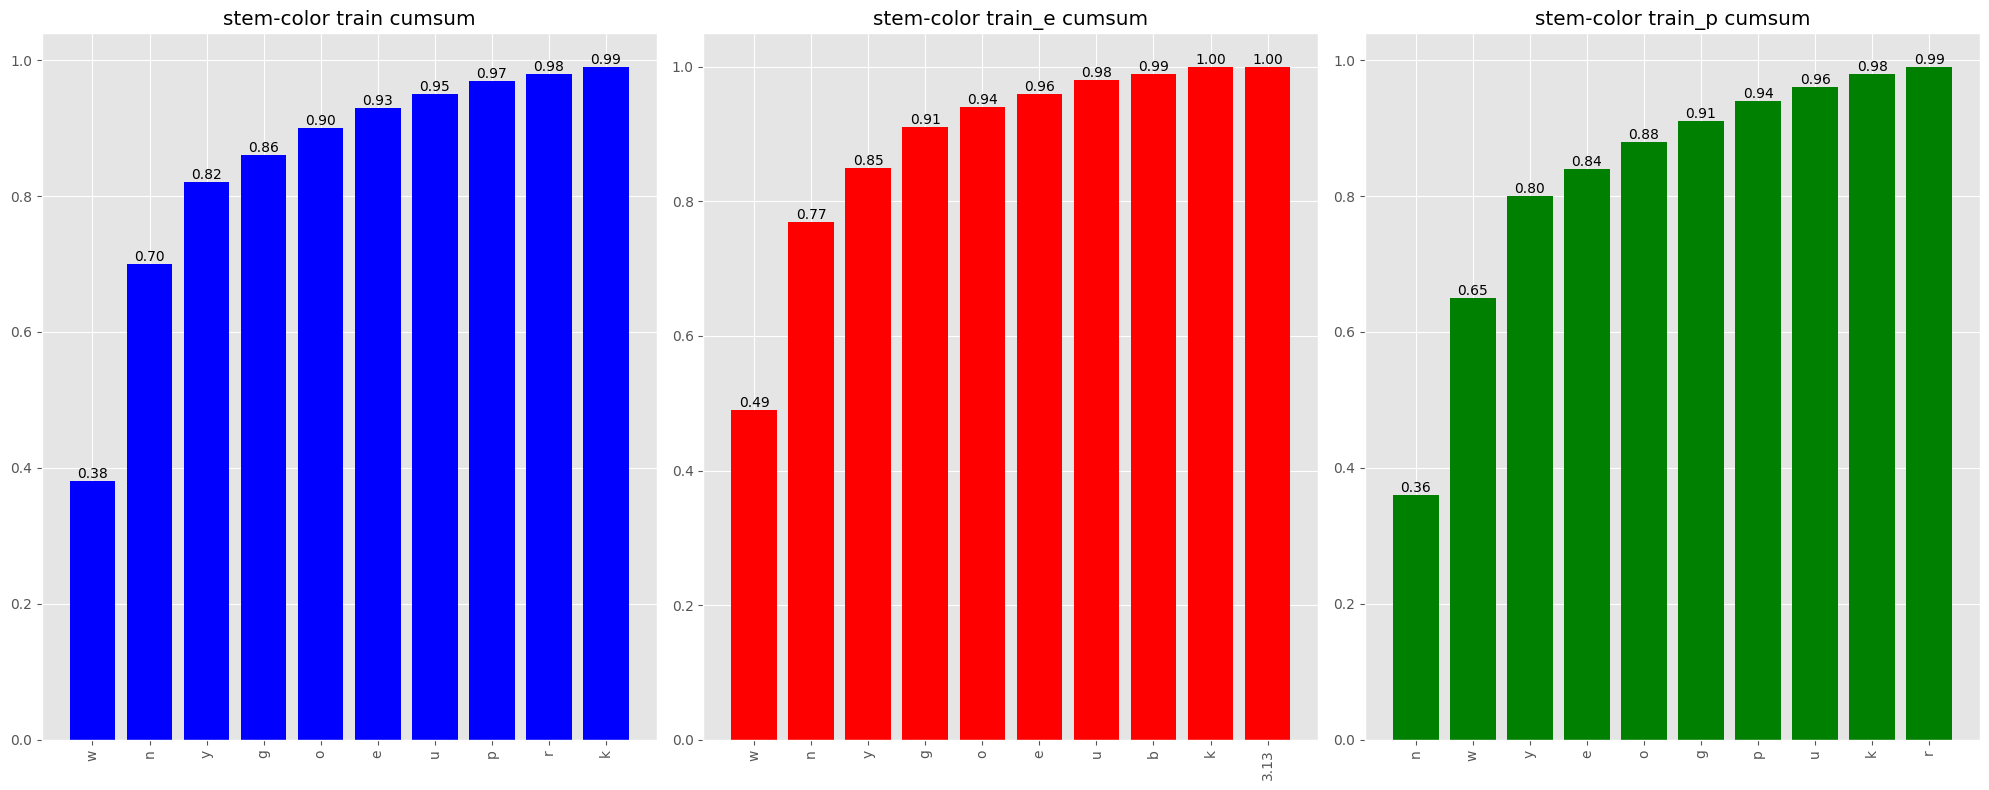

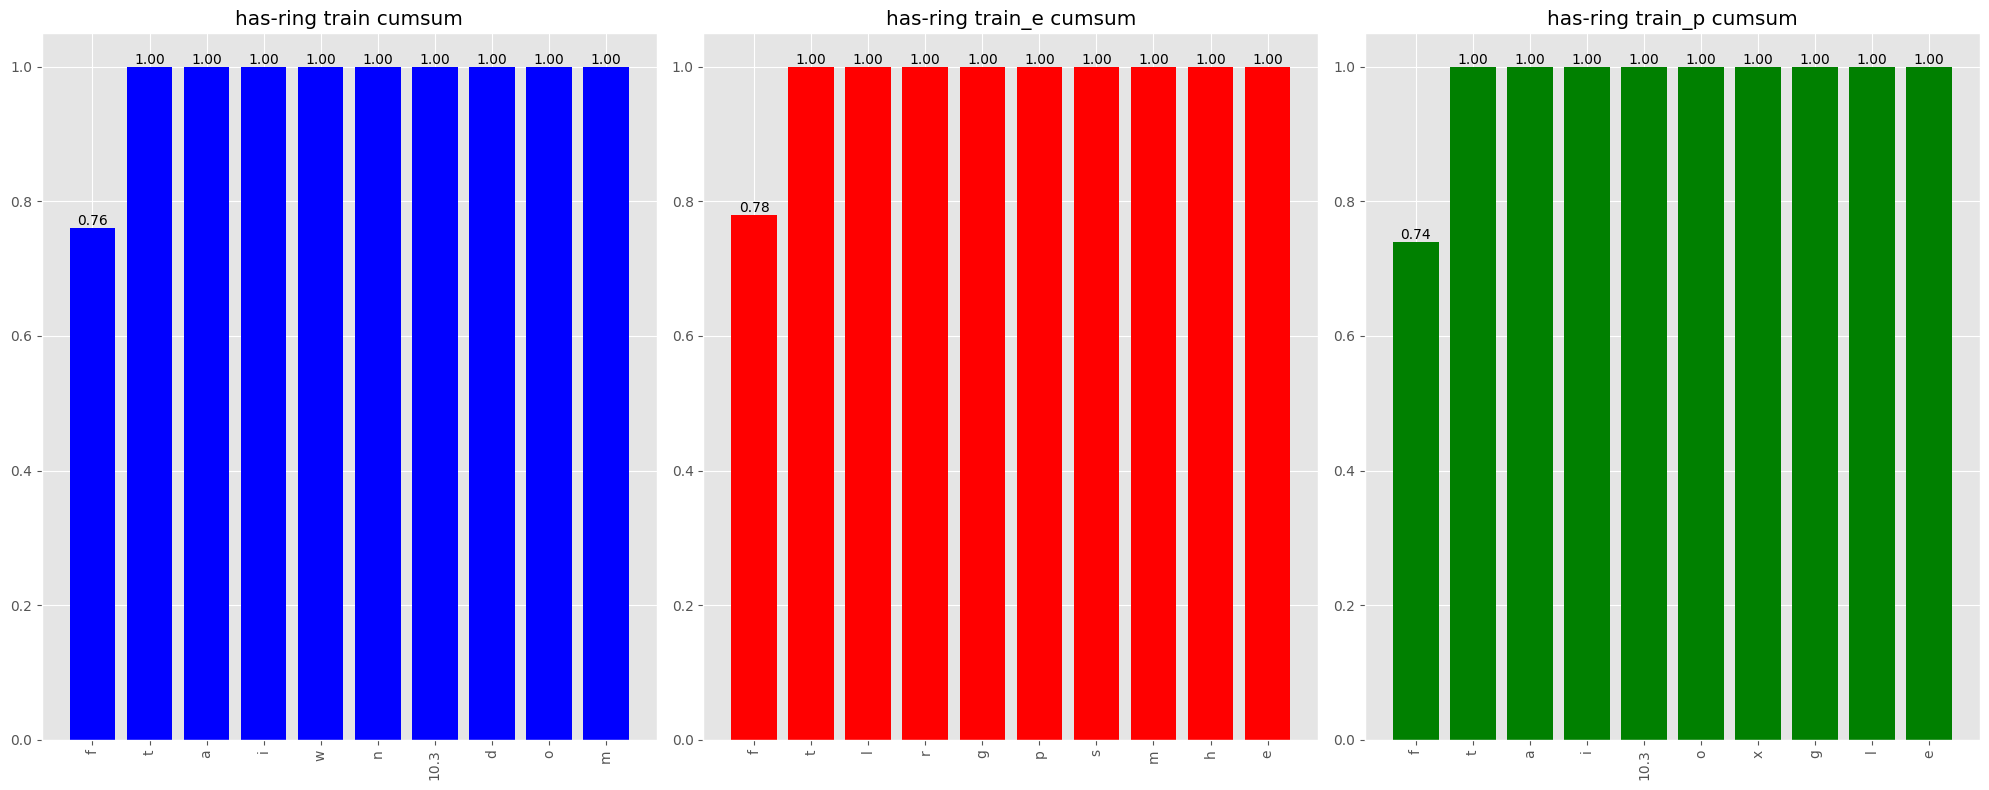

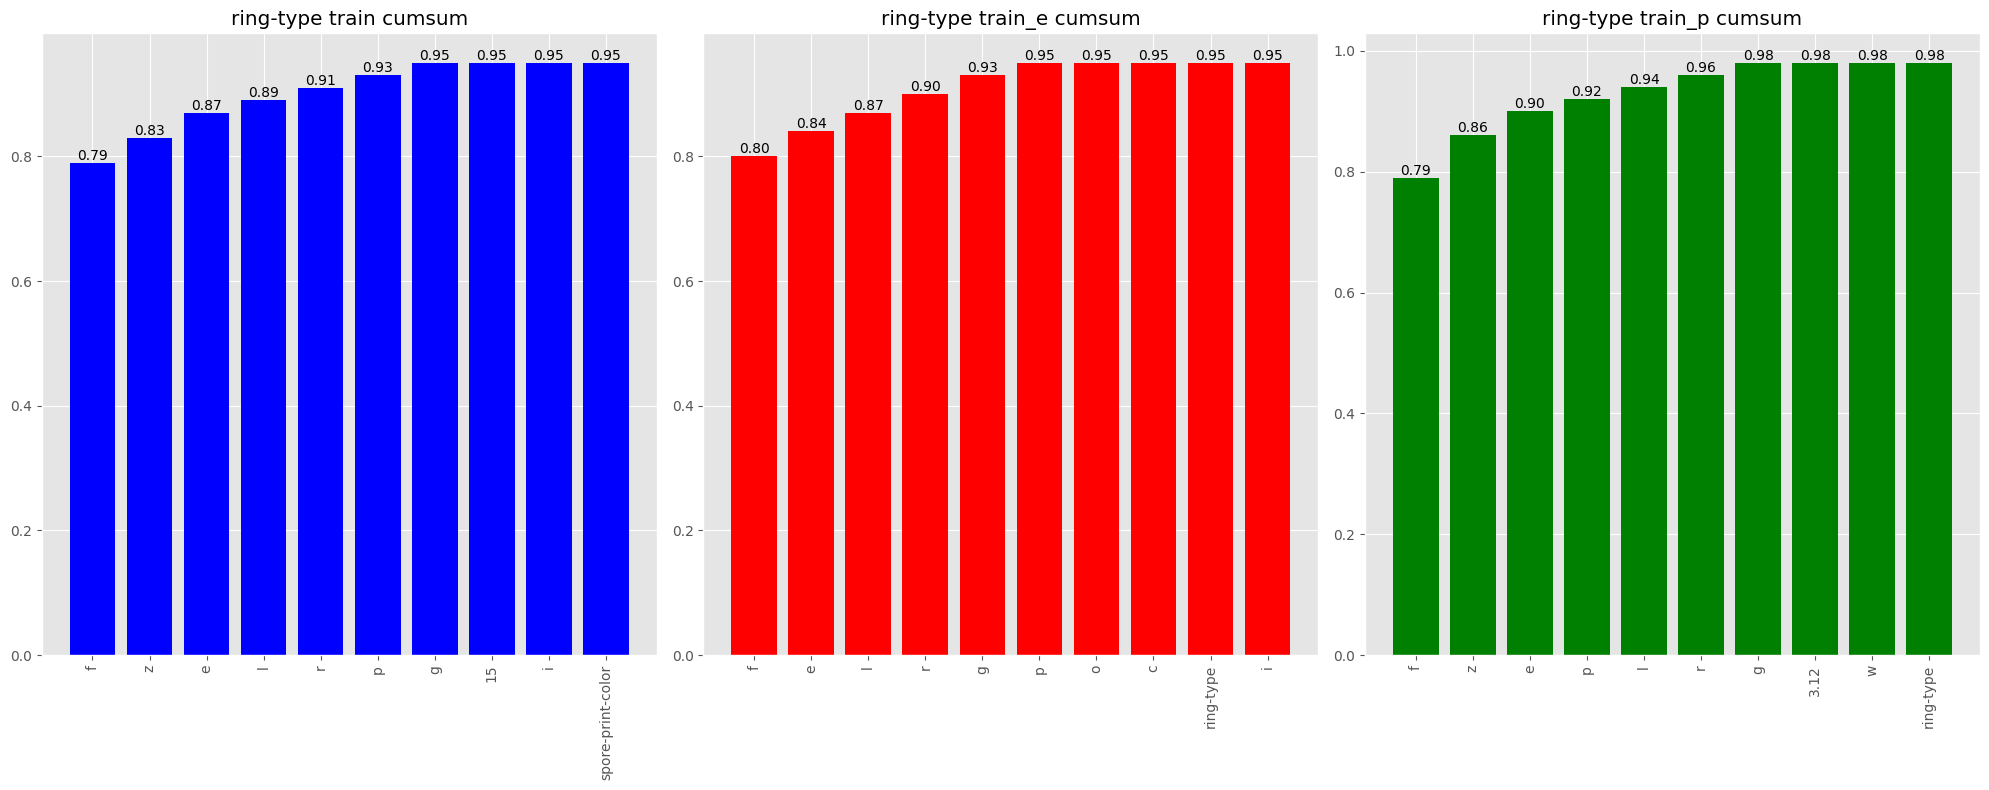

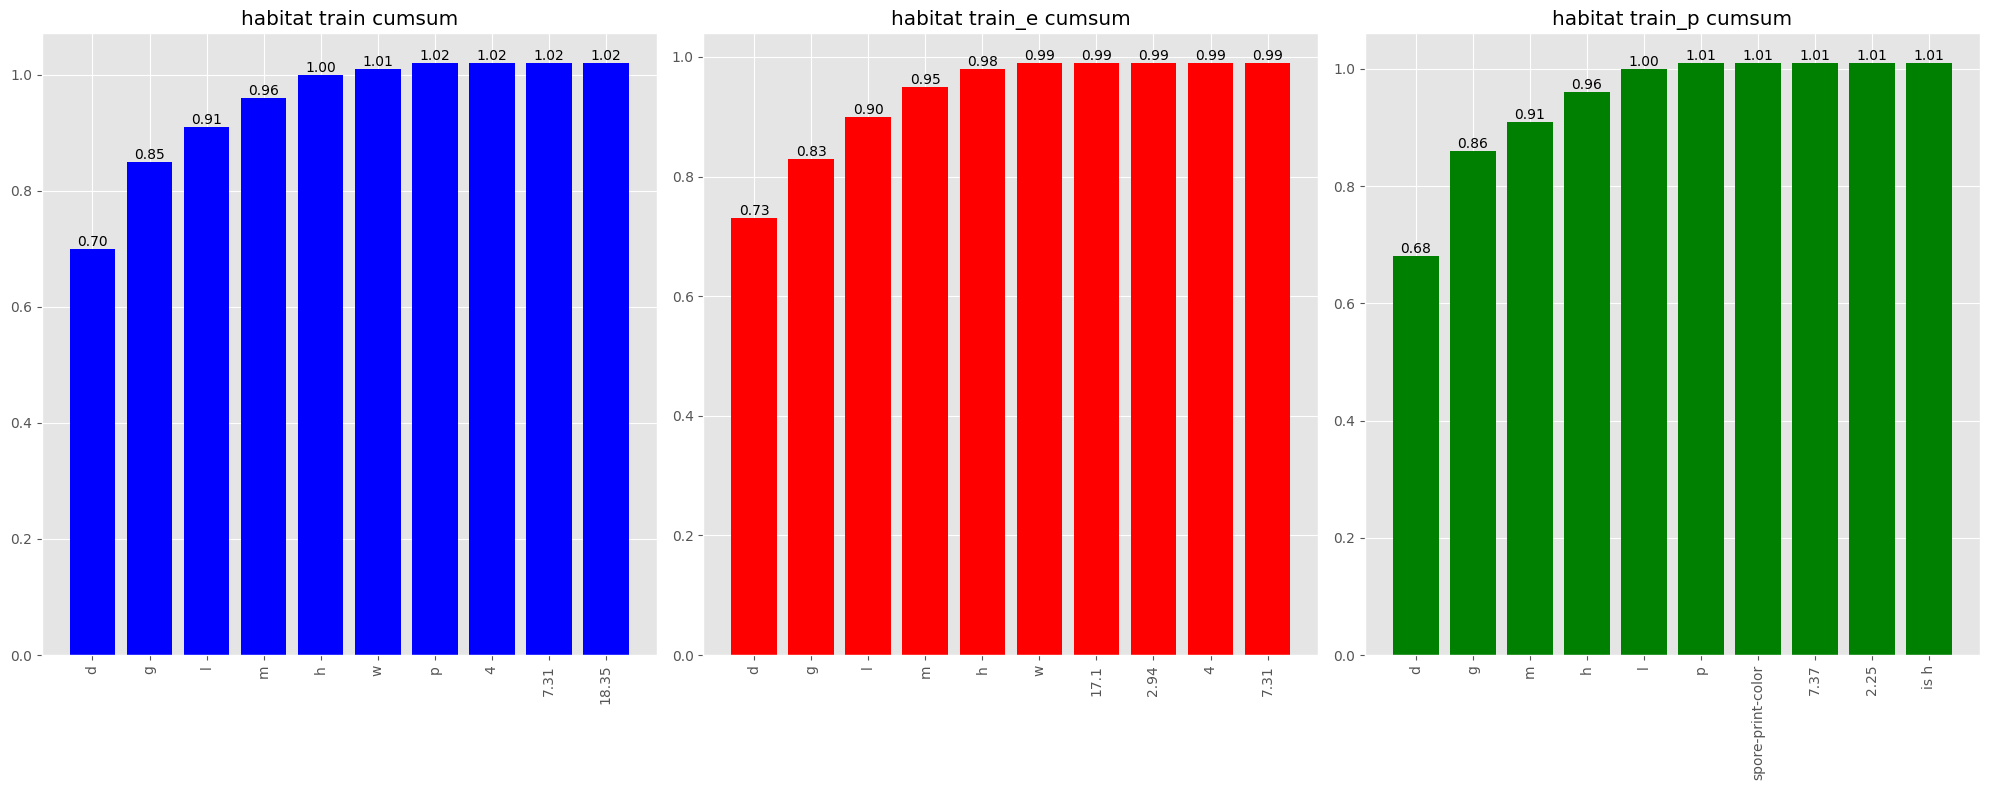

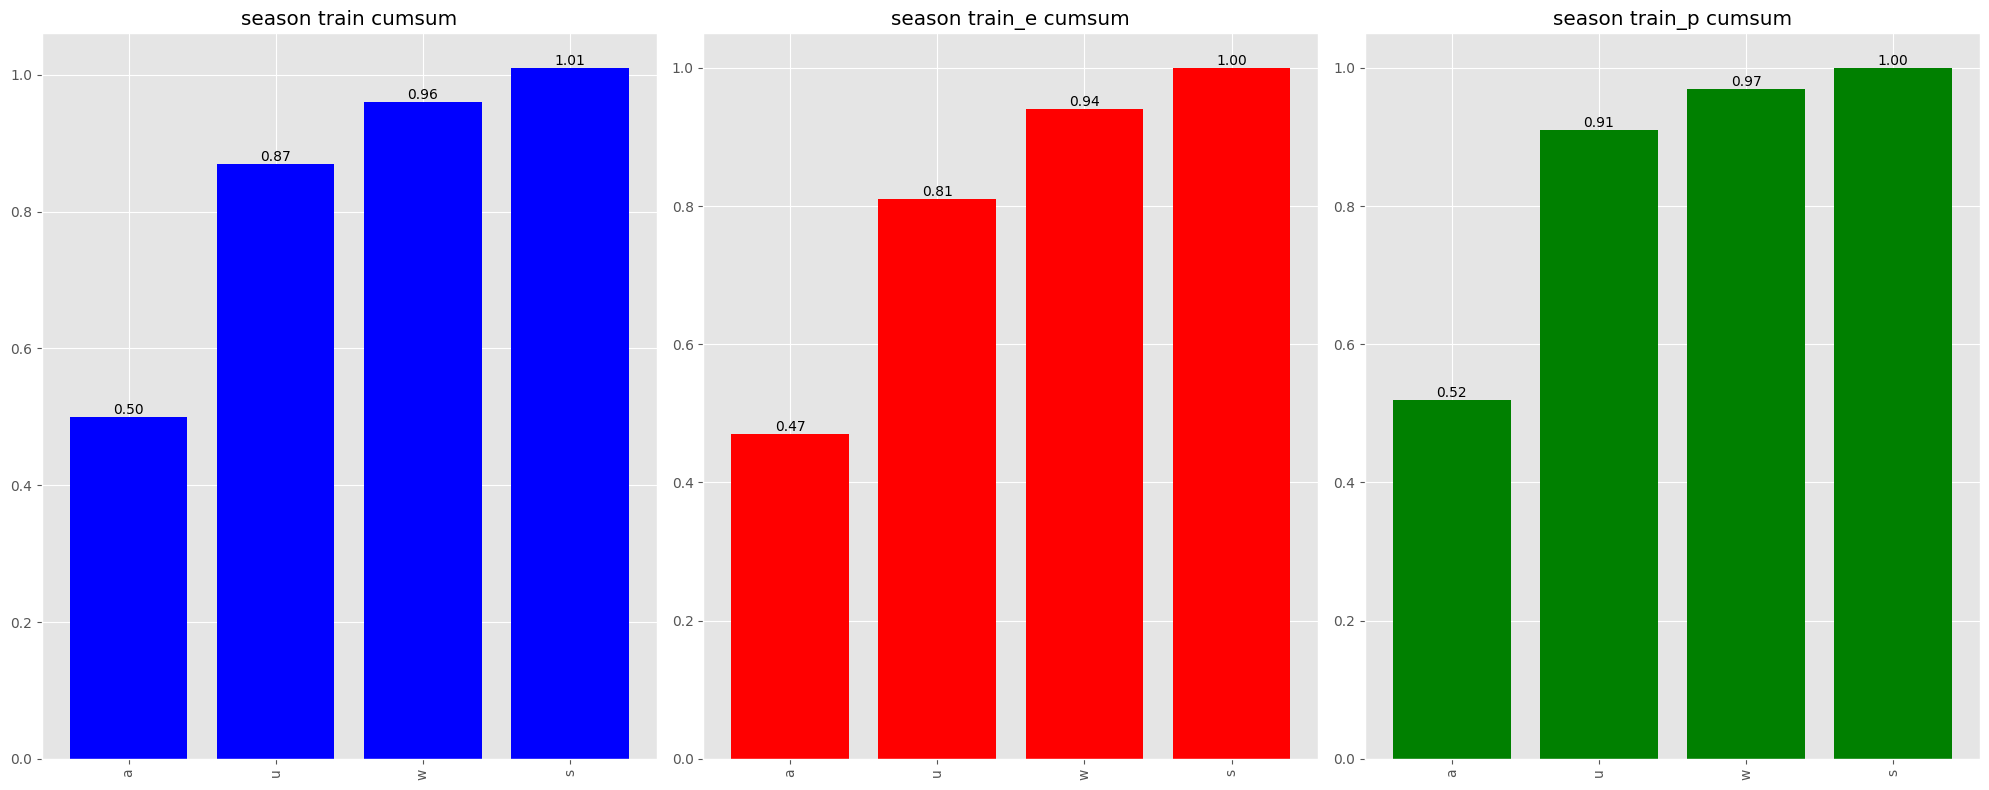

In [ ]:
for col in train.columns:
    if train[col].dtype != "float64":
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))
        train_cumsum = (
            round(train[col].value_counts() / train.shape[0], 2)
            .sort_values(ascending=False)
            .cumsum()
            .head(10)
        )
        train_cumsum_e = (
            round(train_e[col].value_counts() / train_e.shape[0], 2)
            .sort_values(ascending=False)
            .cumsum()
            .head(10)
        )
        train_cumsum_p = (
            round(train_p[col].value_counts() / train_p.shape[0], 2)
            .sort_values(ascending=False)
            .cumsum()
            .head(10)
        )

        axes[0].bar(
            train_cumsum.index, train_cumsum.values, color="blue", label="train"
        )
        axes[0].set_title(f"{col} train cumsum")
        axes[0].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_cumsum.values):
            axes[0].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        axes[1].bar(
            train_cumsum_e.index, train_cumsum_e.values, color="red", label="train_e"
        )
        axes[1].set_title(f"{col} train_e cumsum")
        axes[1].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_cumsum_e.values):
            axes[1].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        axes[2].bar(
            train_cumsum_p.index, train_cumsum_p.values, color="green", label="train_p"
        )
        axes[2].set_title(f"{col} train_p cumsum")
        axes[2].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_cumsum_p.values):
            axes[2].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        plt.tight_layout()
        plt.show()

**Nos proximos gráficos anasalimos a media e mediana nas colunas numericas pelas classes e pelas categorias das colunas categoricas**

In [ ]:
train.groupby(["cap-shape", "class"])[['cap-diameter', 'stem-height', 'stem-width']].agg({
    'cap-diameter': ['mean', 'median','count'],
    'stem-height': ['mean','median', 'count'],
    'stem-width': ['mean', 'median','count']
}).sort_values(by=('cap-diameter', 'count'), ascending=False).head(12)

cap-diameter                stem-height                 \
                        mean median   count        mean median   count   
cap-shape class                                                          
x         p         5.801369   5.09  586048    6.408587   5.77  586048   
          e         6.831617   6.59  562770    6.708666   6.37  562771   
f         p         6.147670   4.86  277200    6.106435   5.47  277201   
          e         7.144165   6.97  263715    6.301611   5.85  263715   
b         p         3.457981   3.15  197019    6.954017   5.92  197019   
s         p         6.960287   6.52  160218    5.075420   4.84  160219   
          e         7.871823   7.50  131848    5.785798   5.86  131848   
o         p         5.761289   4.42   58841    3.591321   3.65   58841   
b         e         3.336758   3.18   57858    5.347697   5.40   57858   
p         e         7.910718   8.18   46277    9.047026   7.89   46277   
c         p         4.309586   4.66   45360    6.126992   6.41   45360   
p         p         5.771435   6.55   39421    9.437283   8.40   39421   

                stem-width                 
                      mean median   count  
cap-shape class                            
x         p      10.310832   7.91  586048  
          e      12.515798  11.91  562771  
f         p       9.844380   6.71  277201  
          e      12.689022  12.30  263715  
b         p       5.248591   3.97  197019  
s         p      11.179819   9.20  160219  
          e      15.078627  16.13  131848  
o         p      17.901514  16.43   58841  
b         e       3.712206   3.08   57858  
p         e      14.484625  14.81   46277  
c         p       7.677243   7.38   45360  
p         p      12.752324  13.07   39421

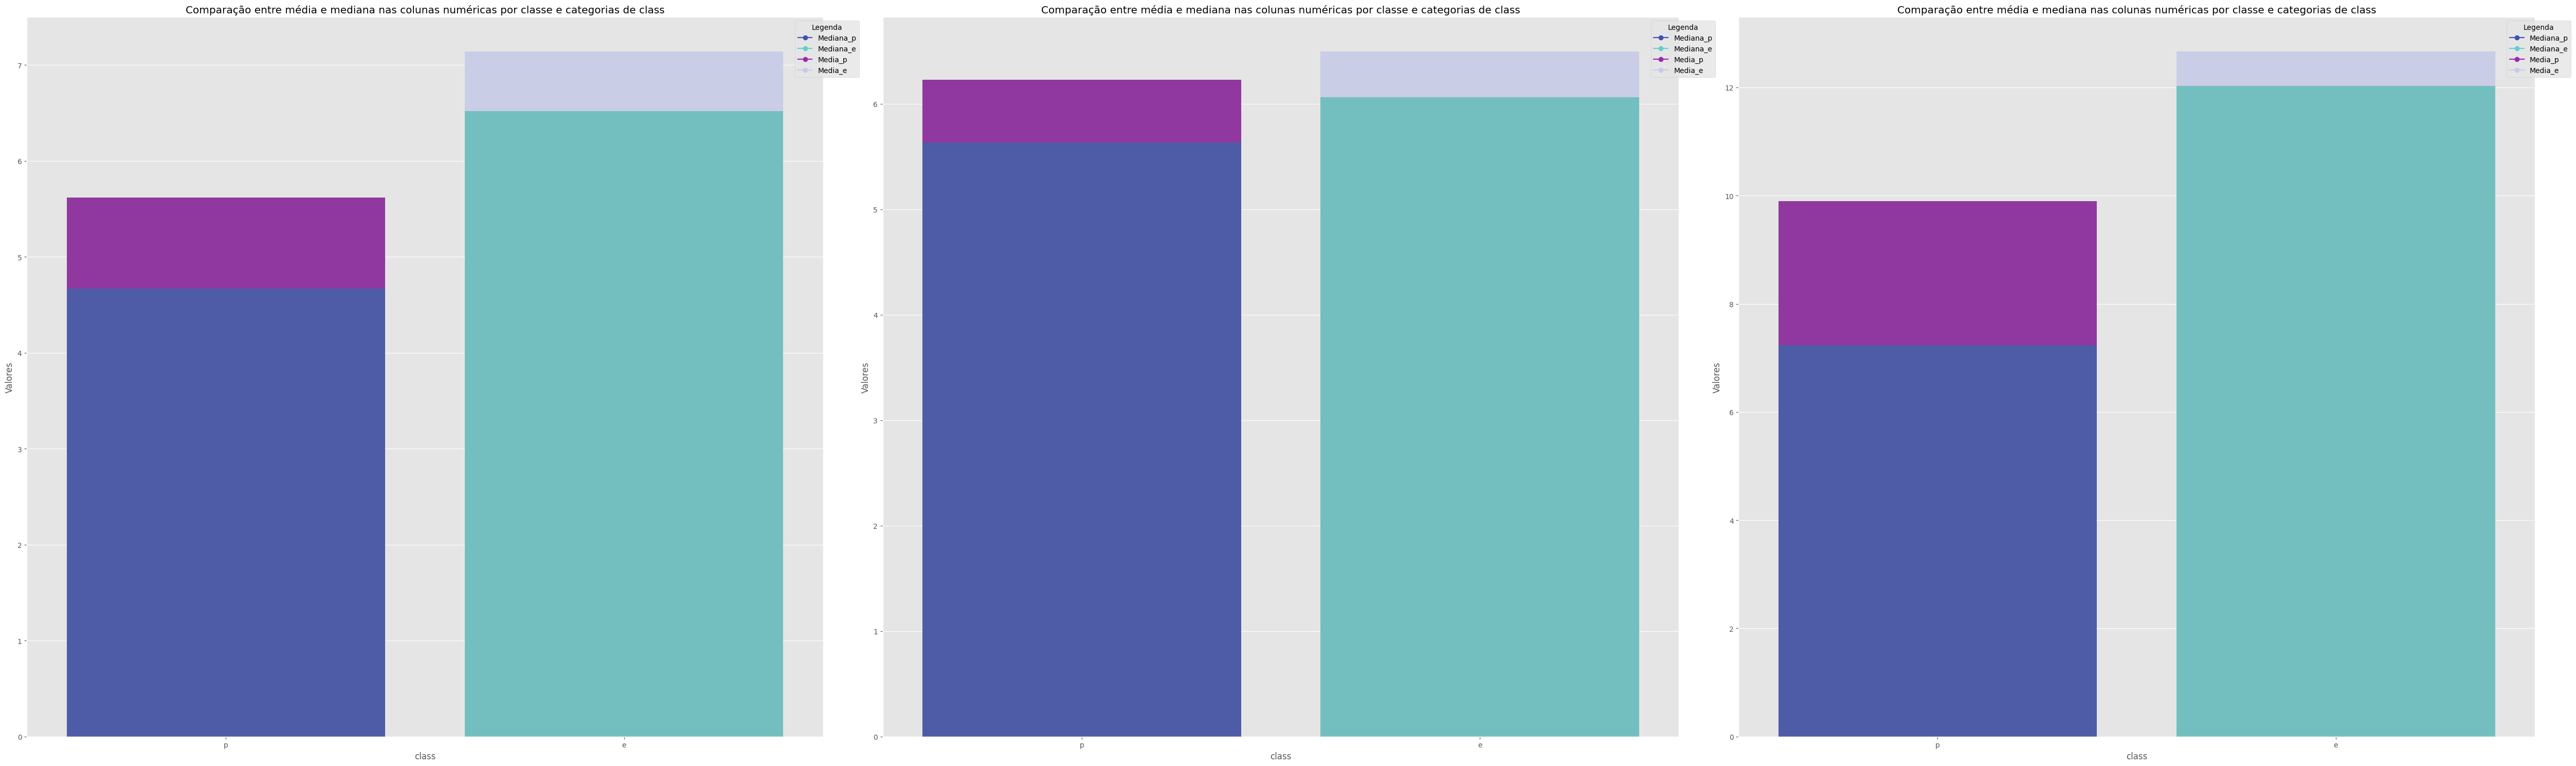

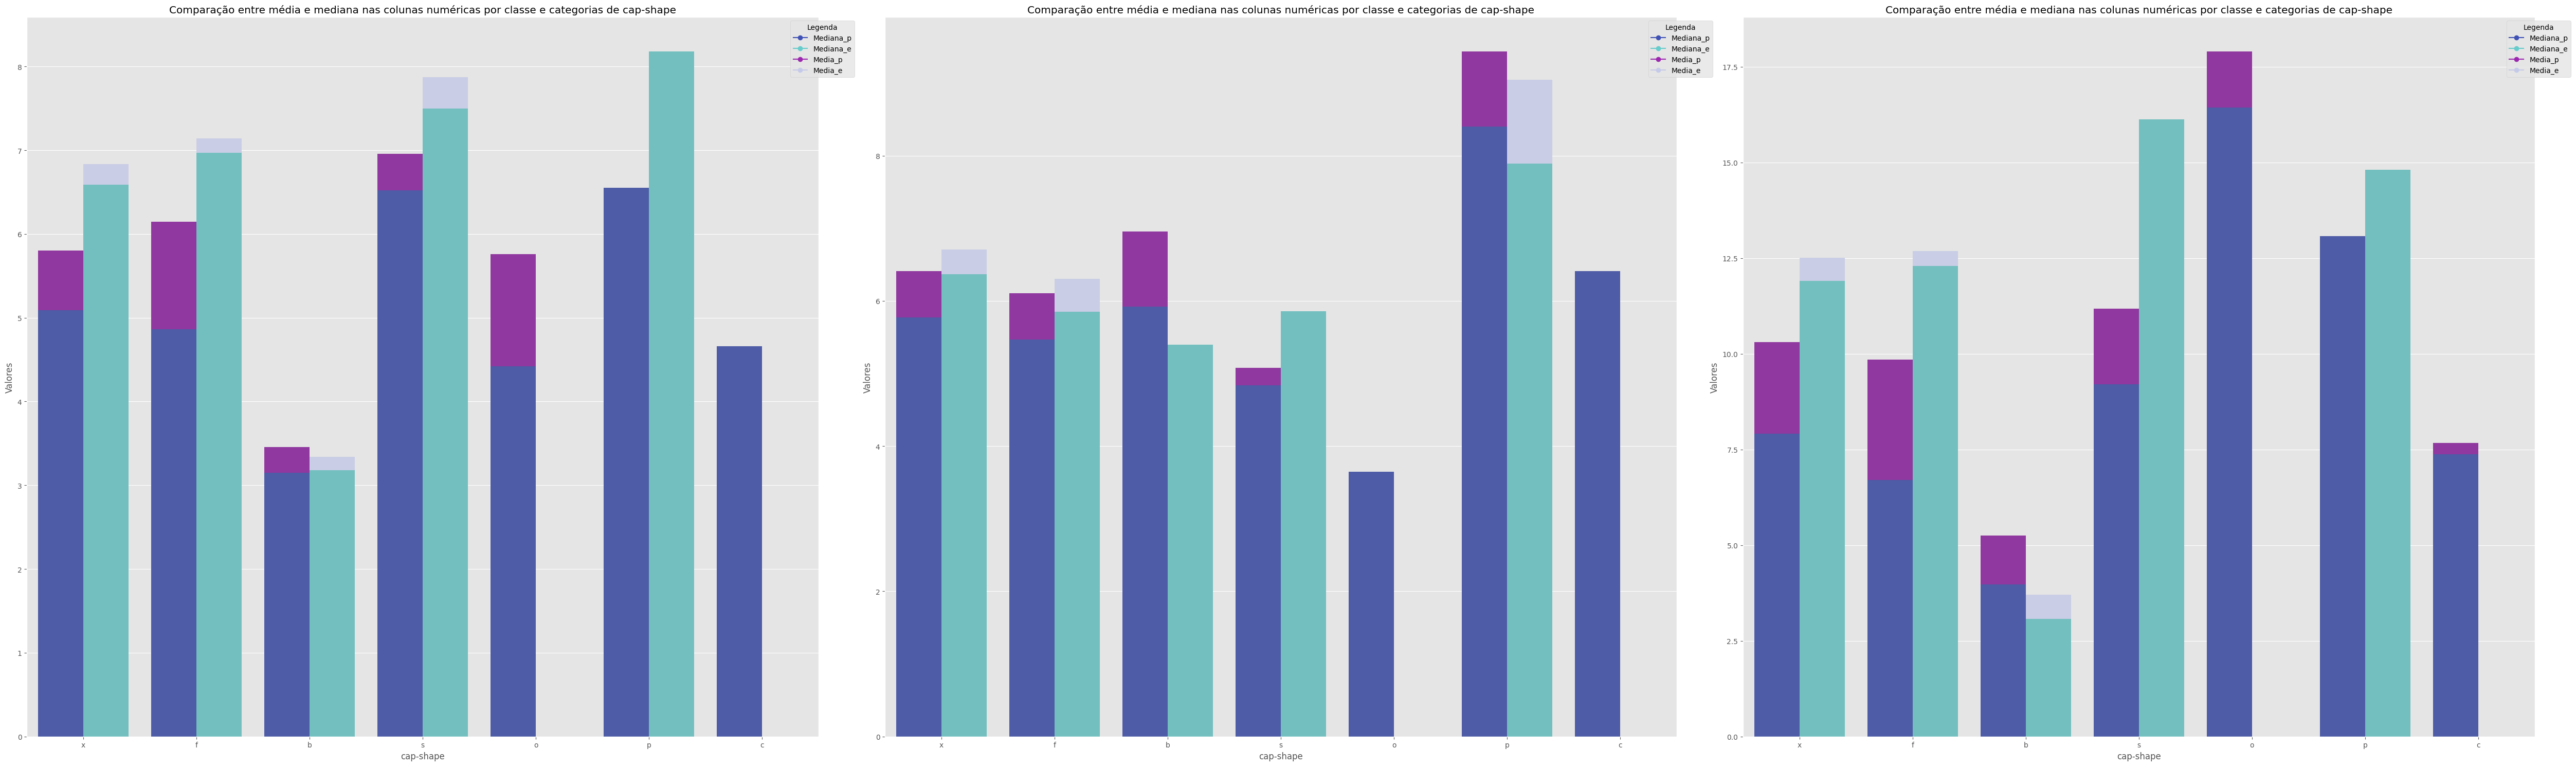

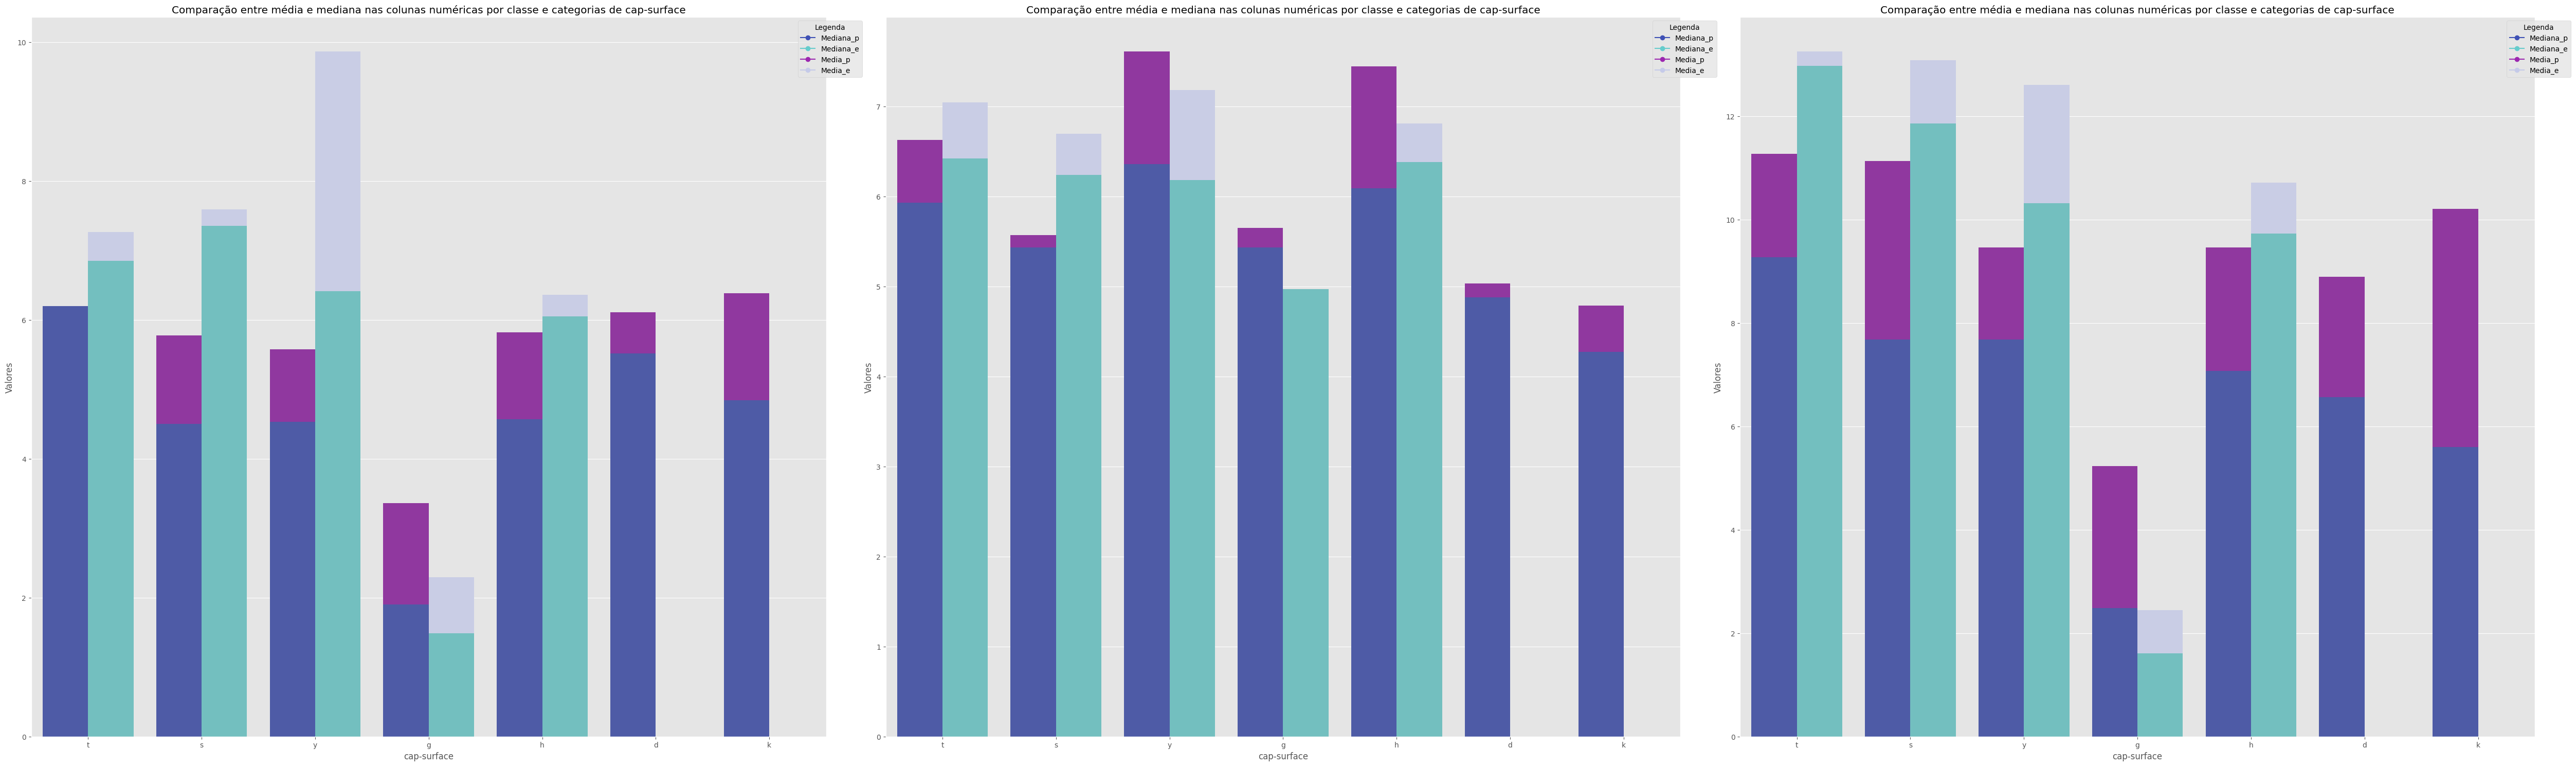

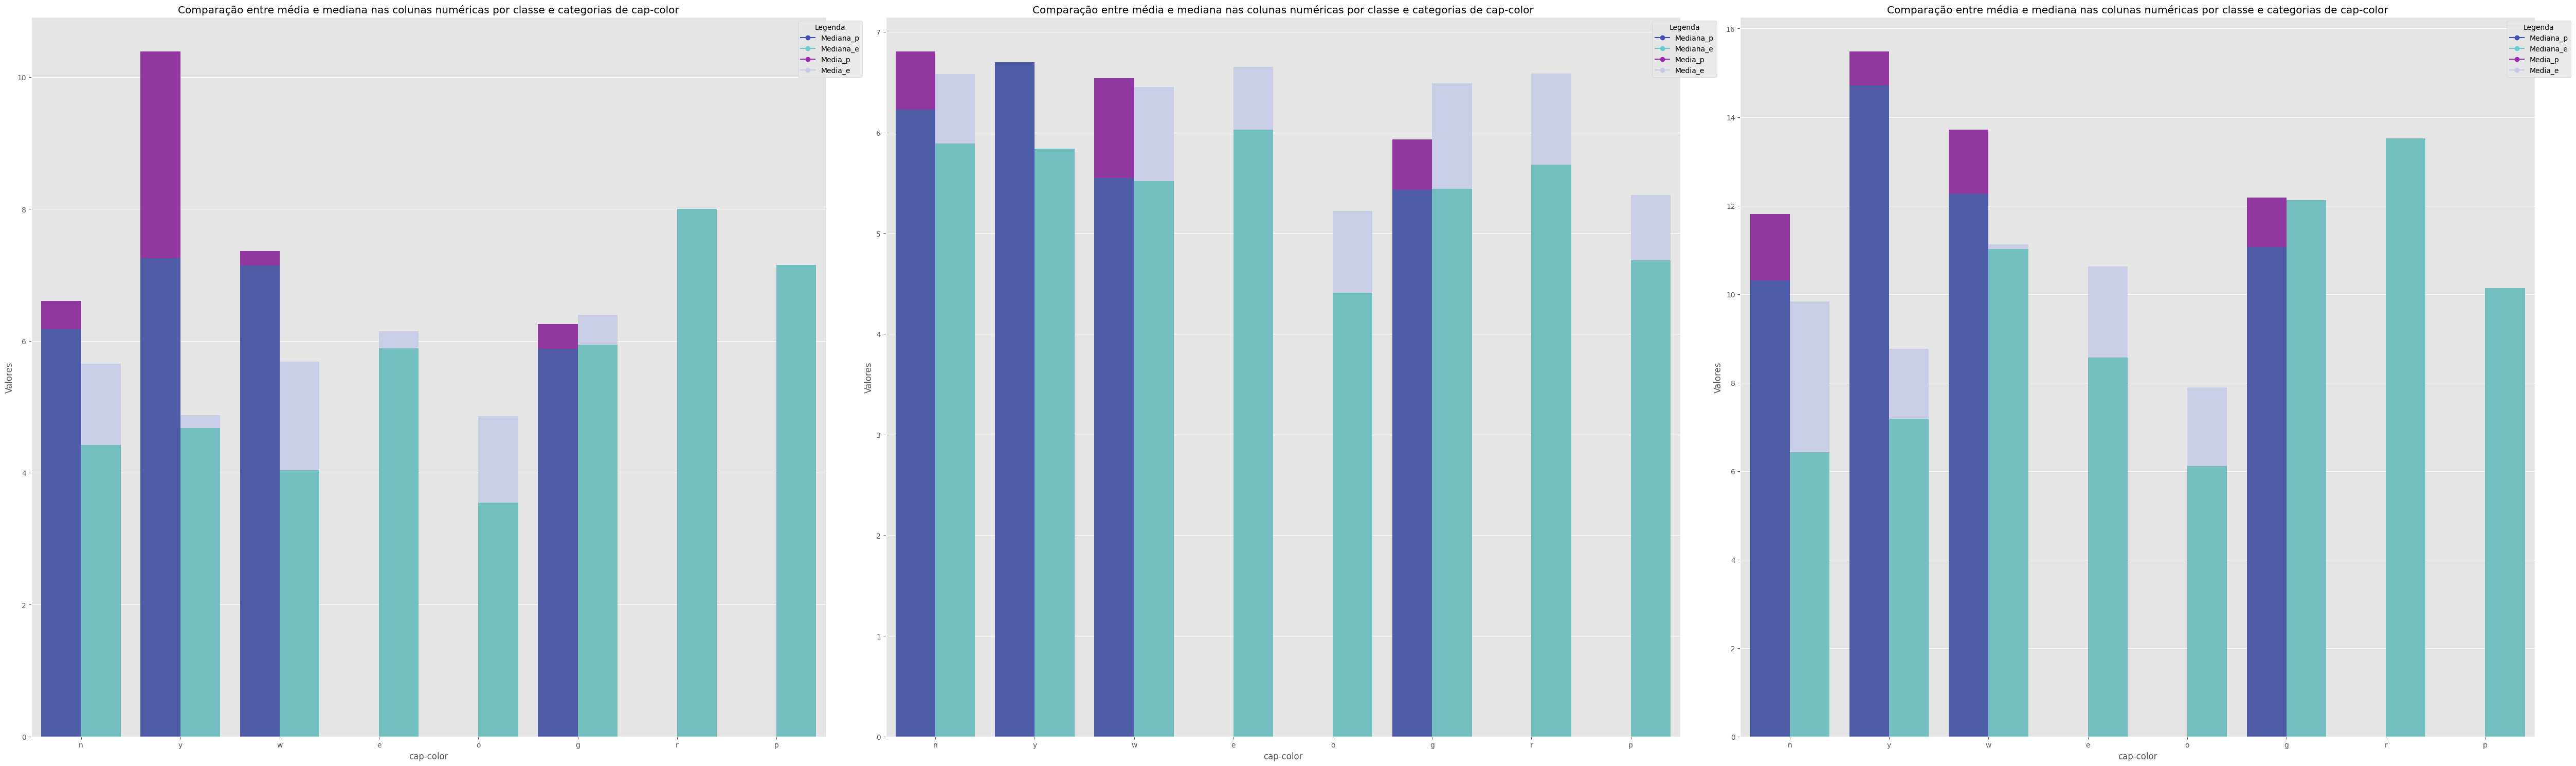

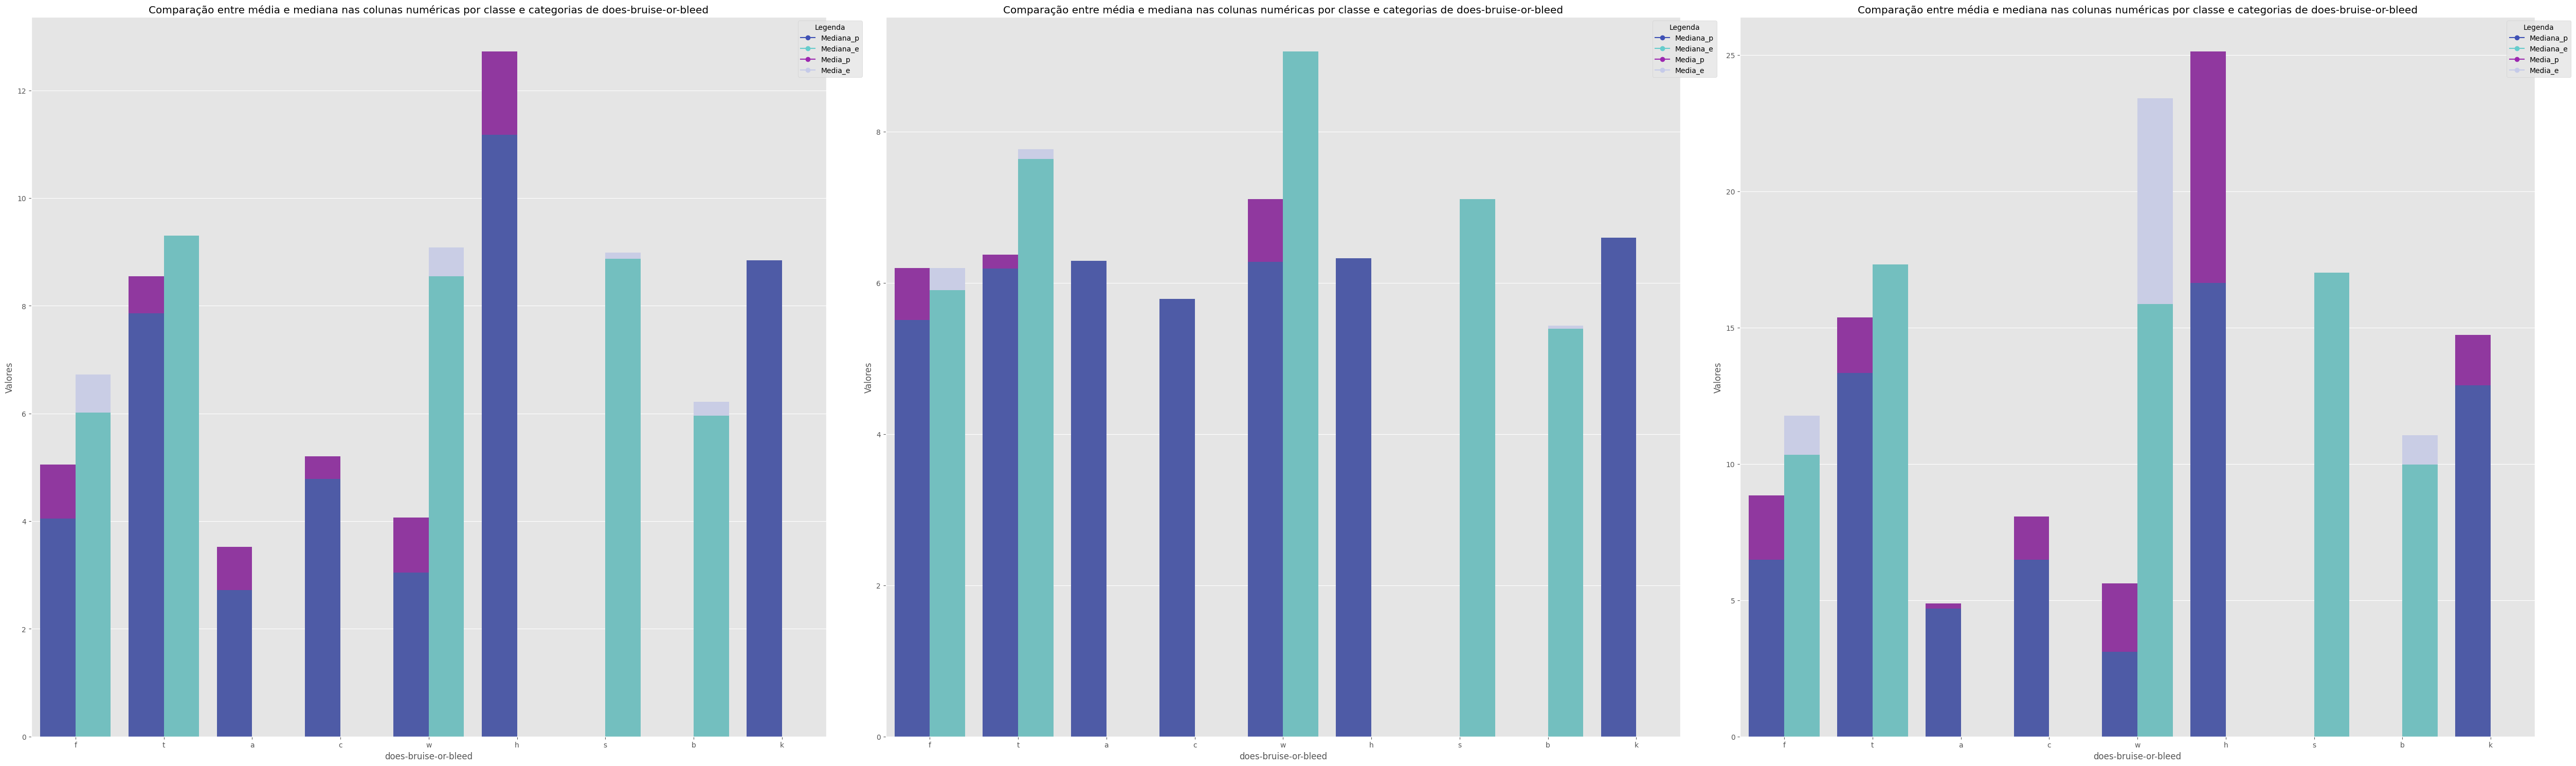

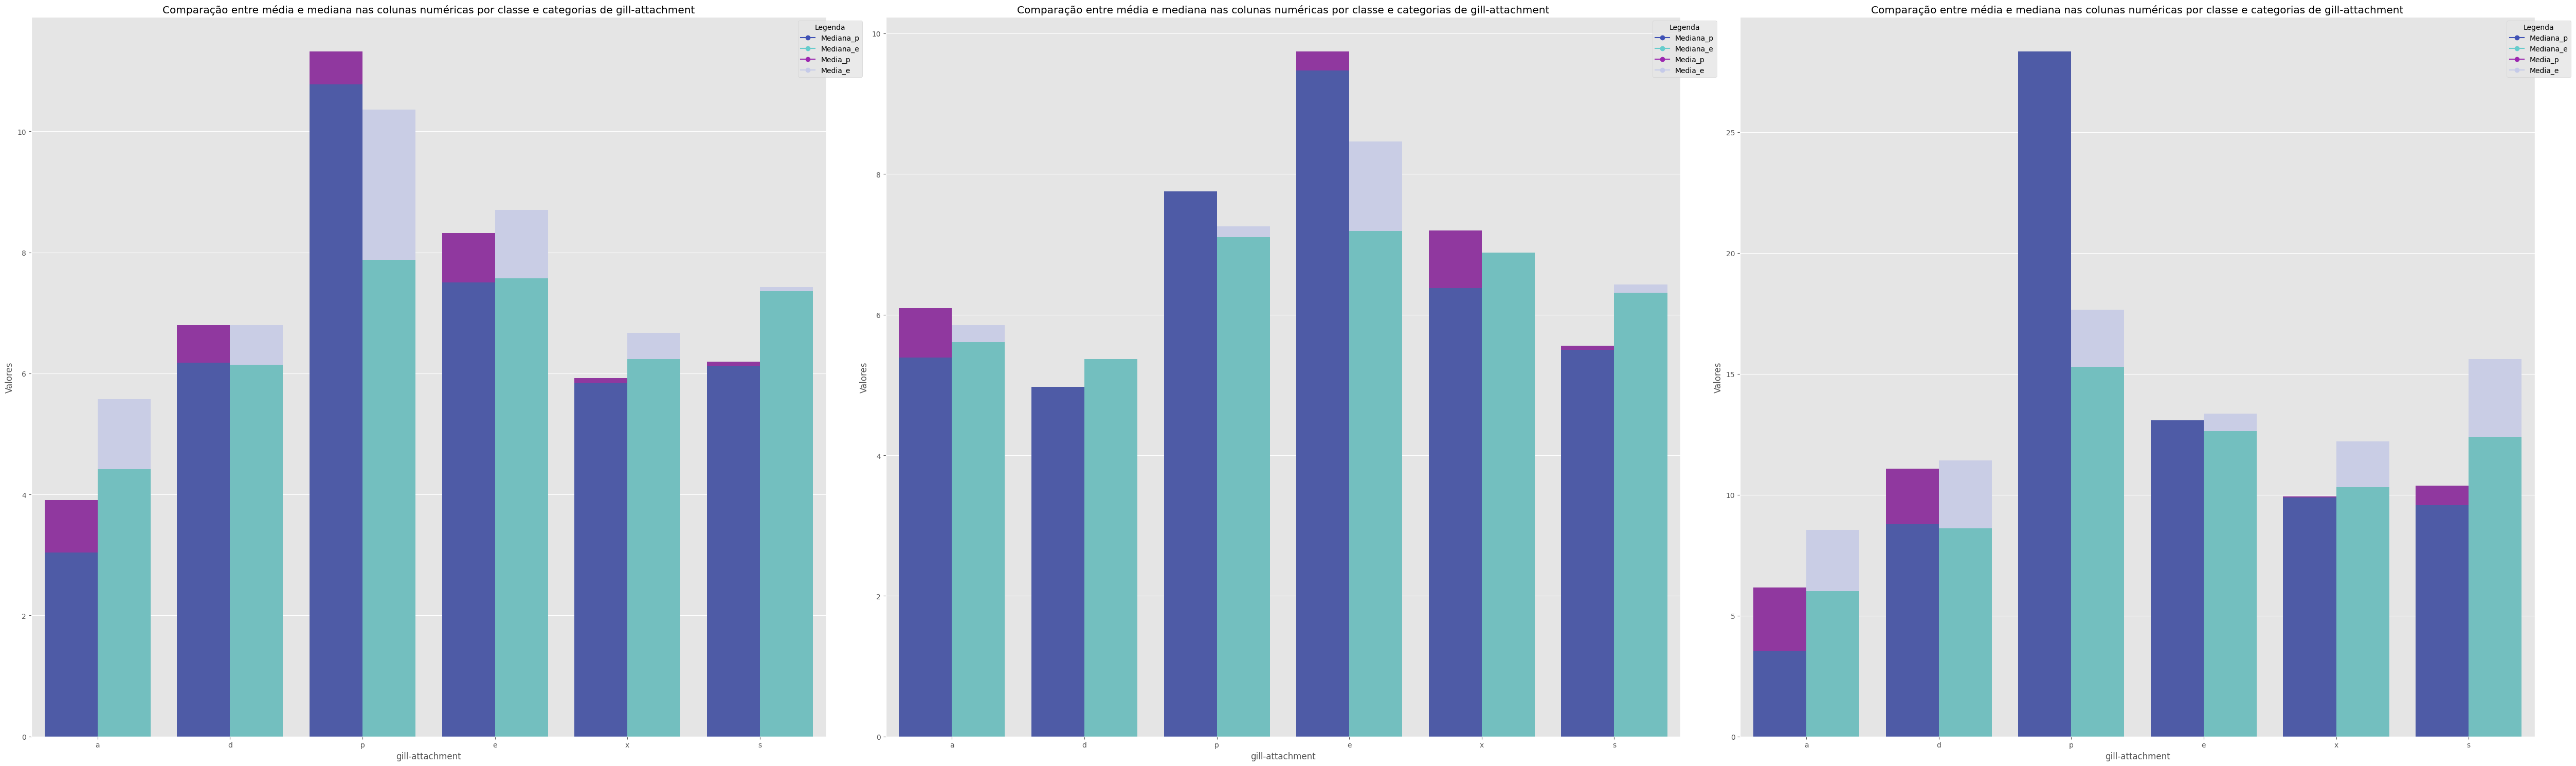

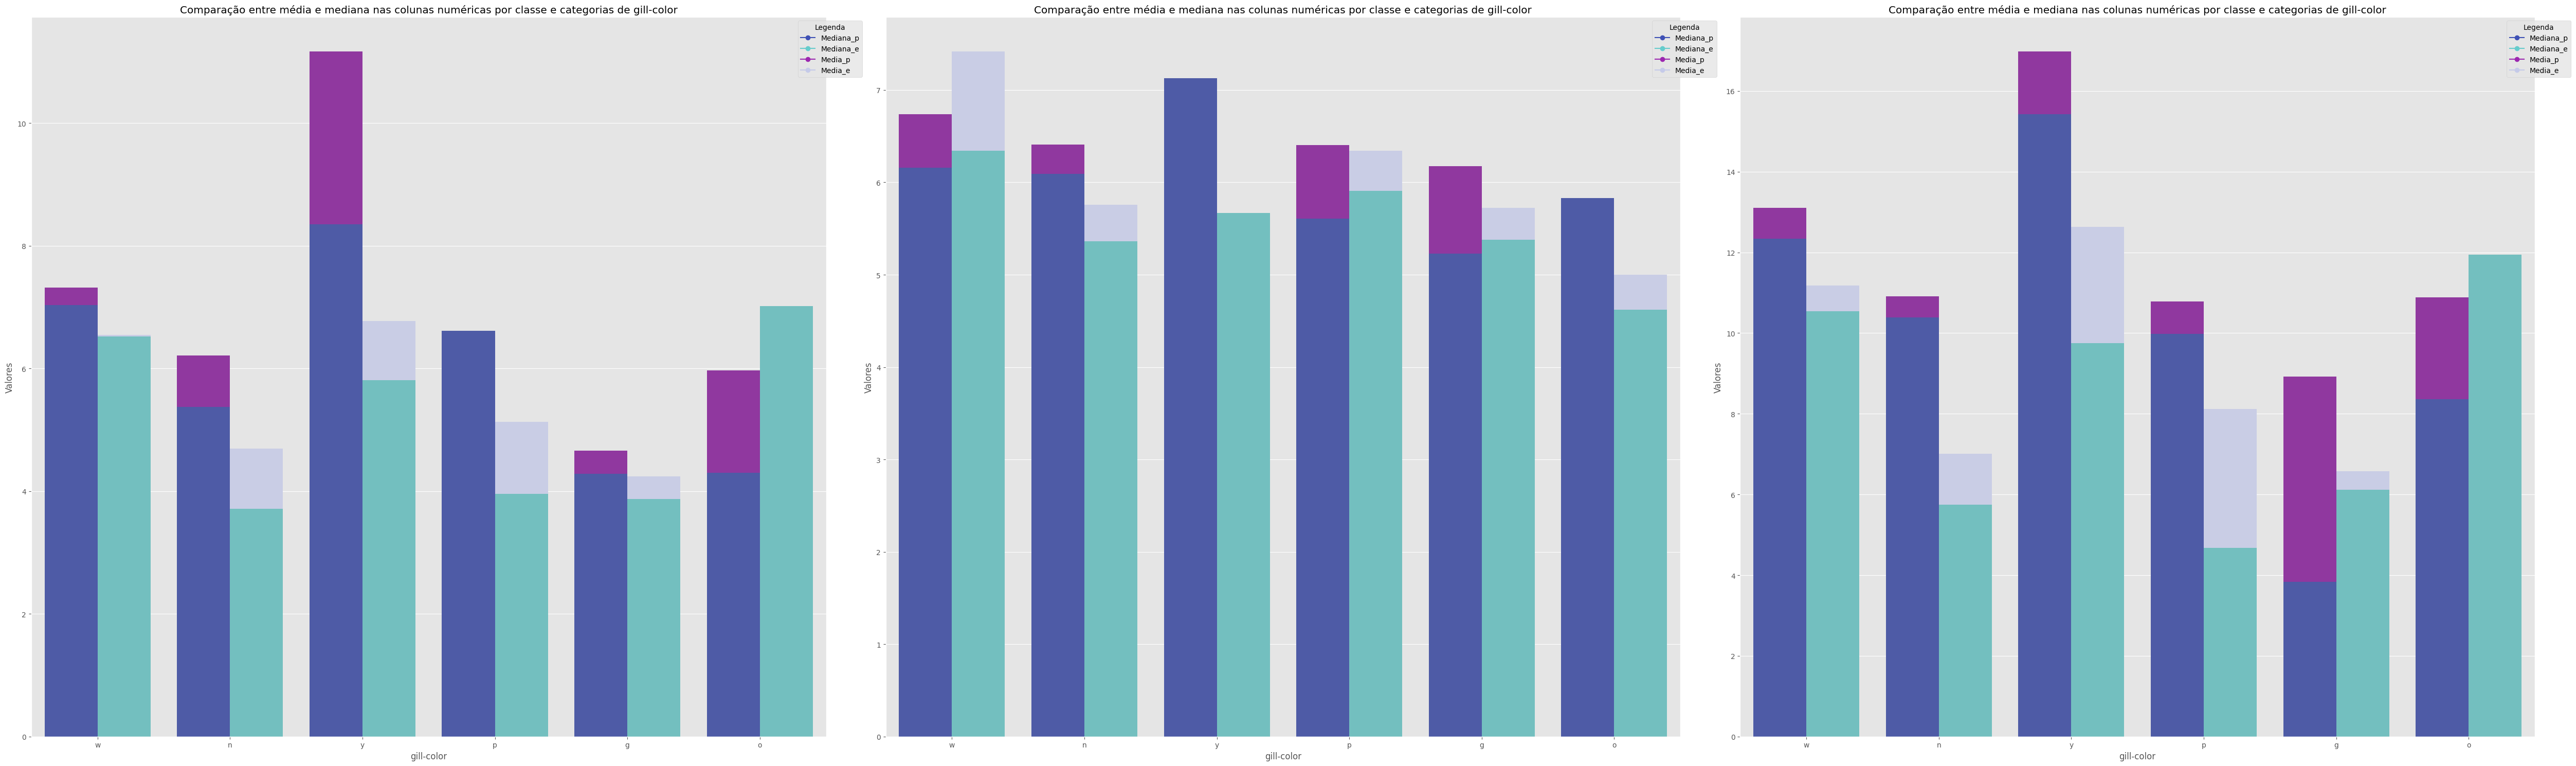

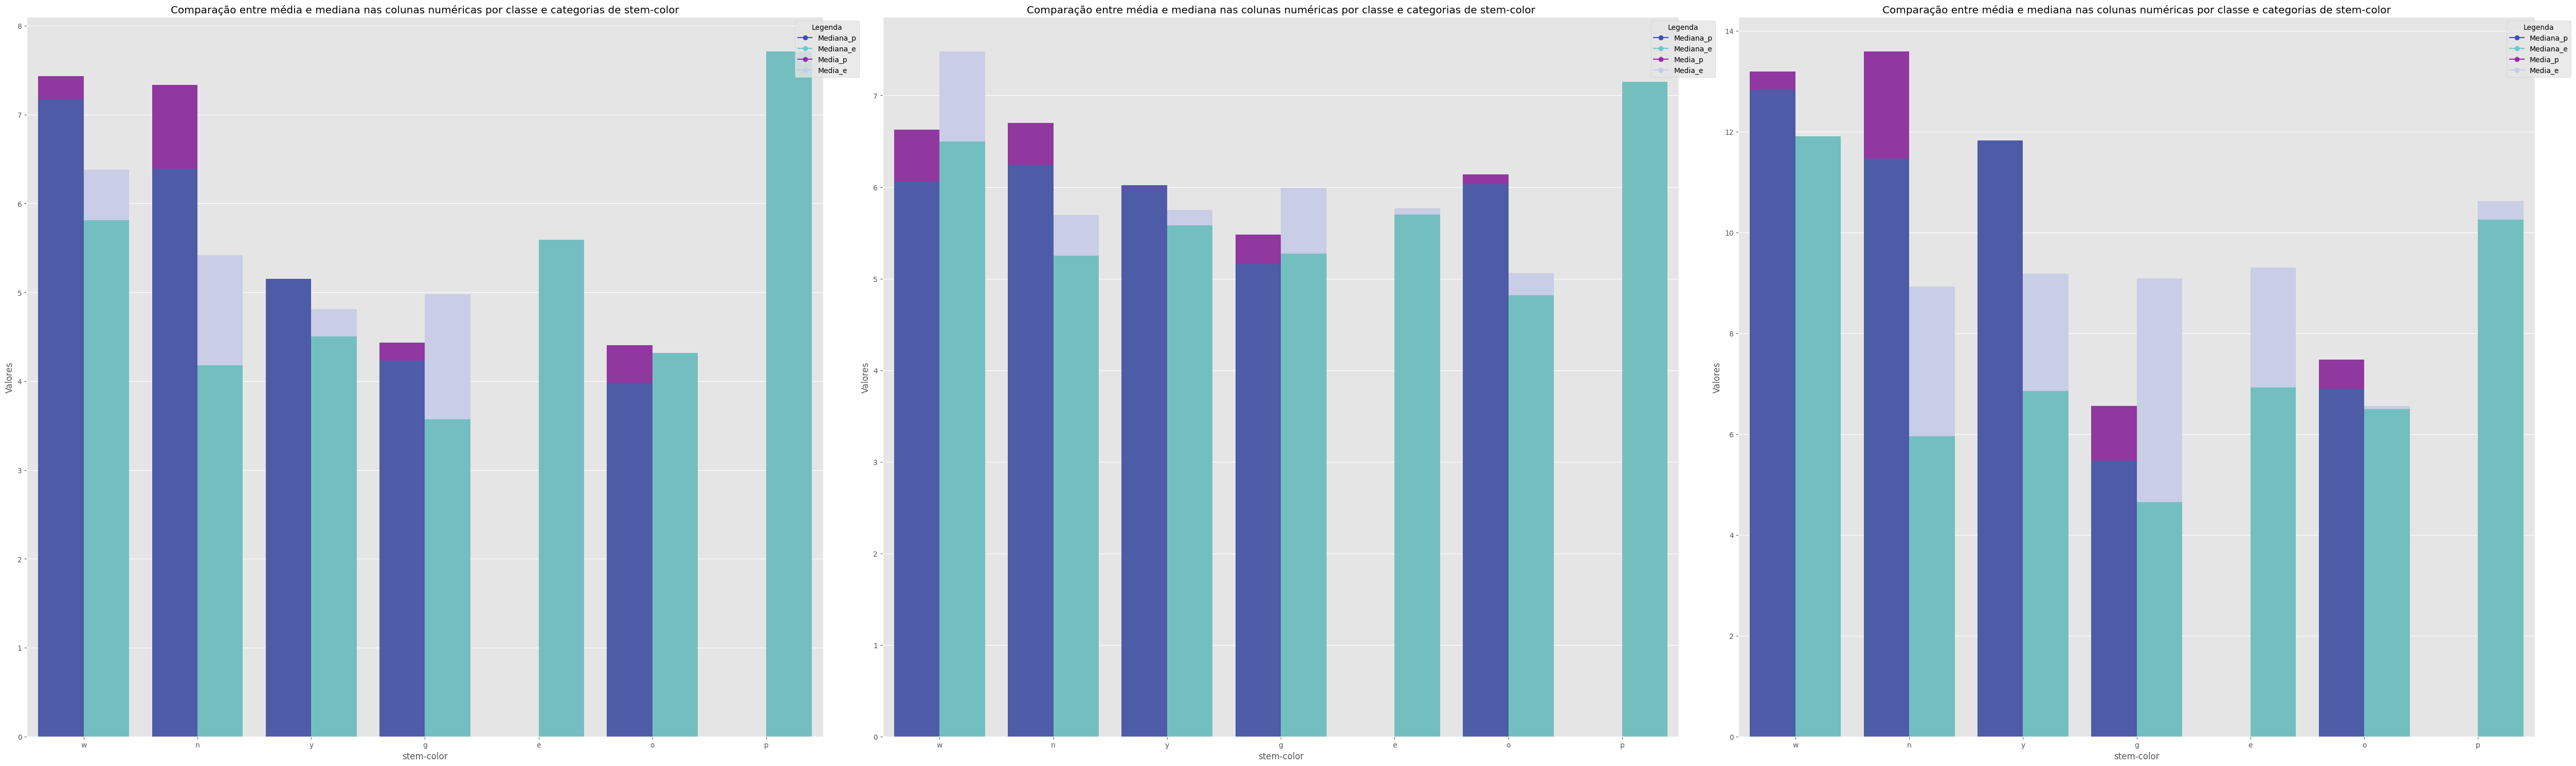

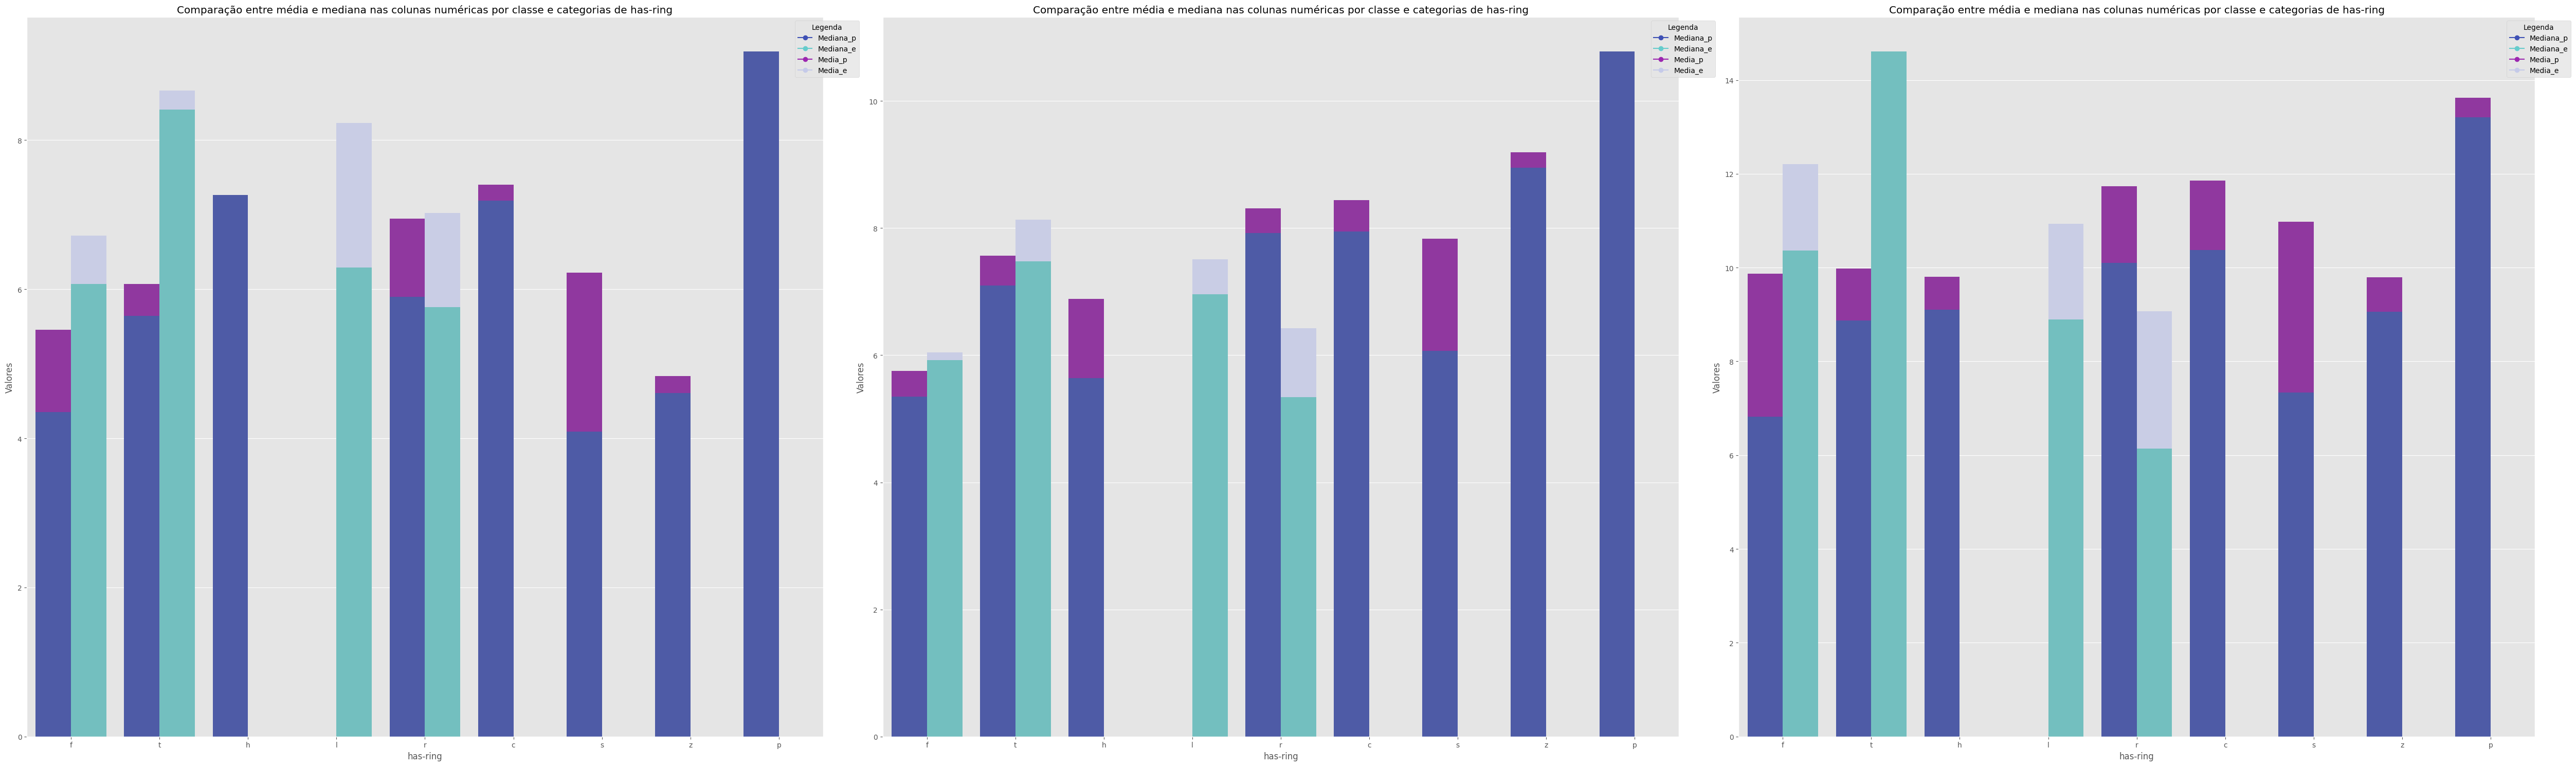

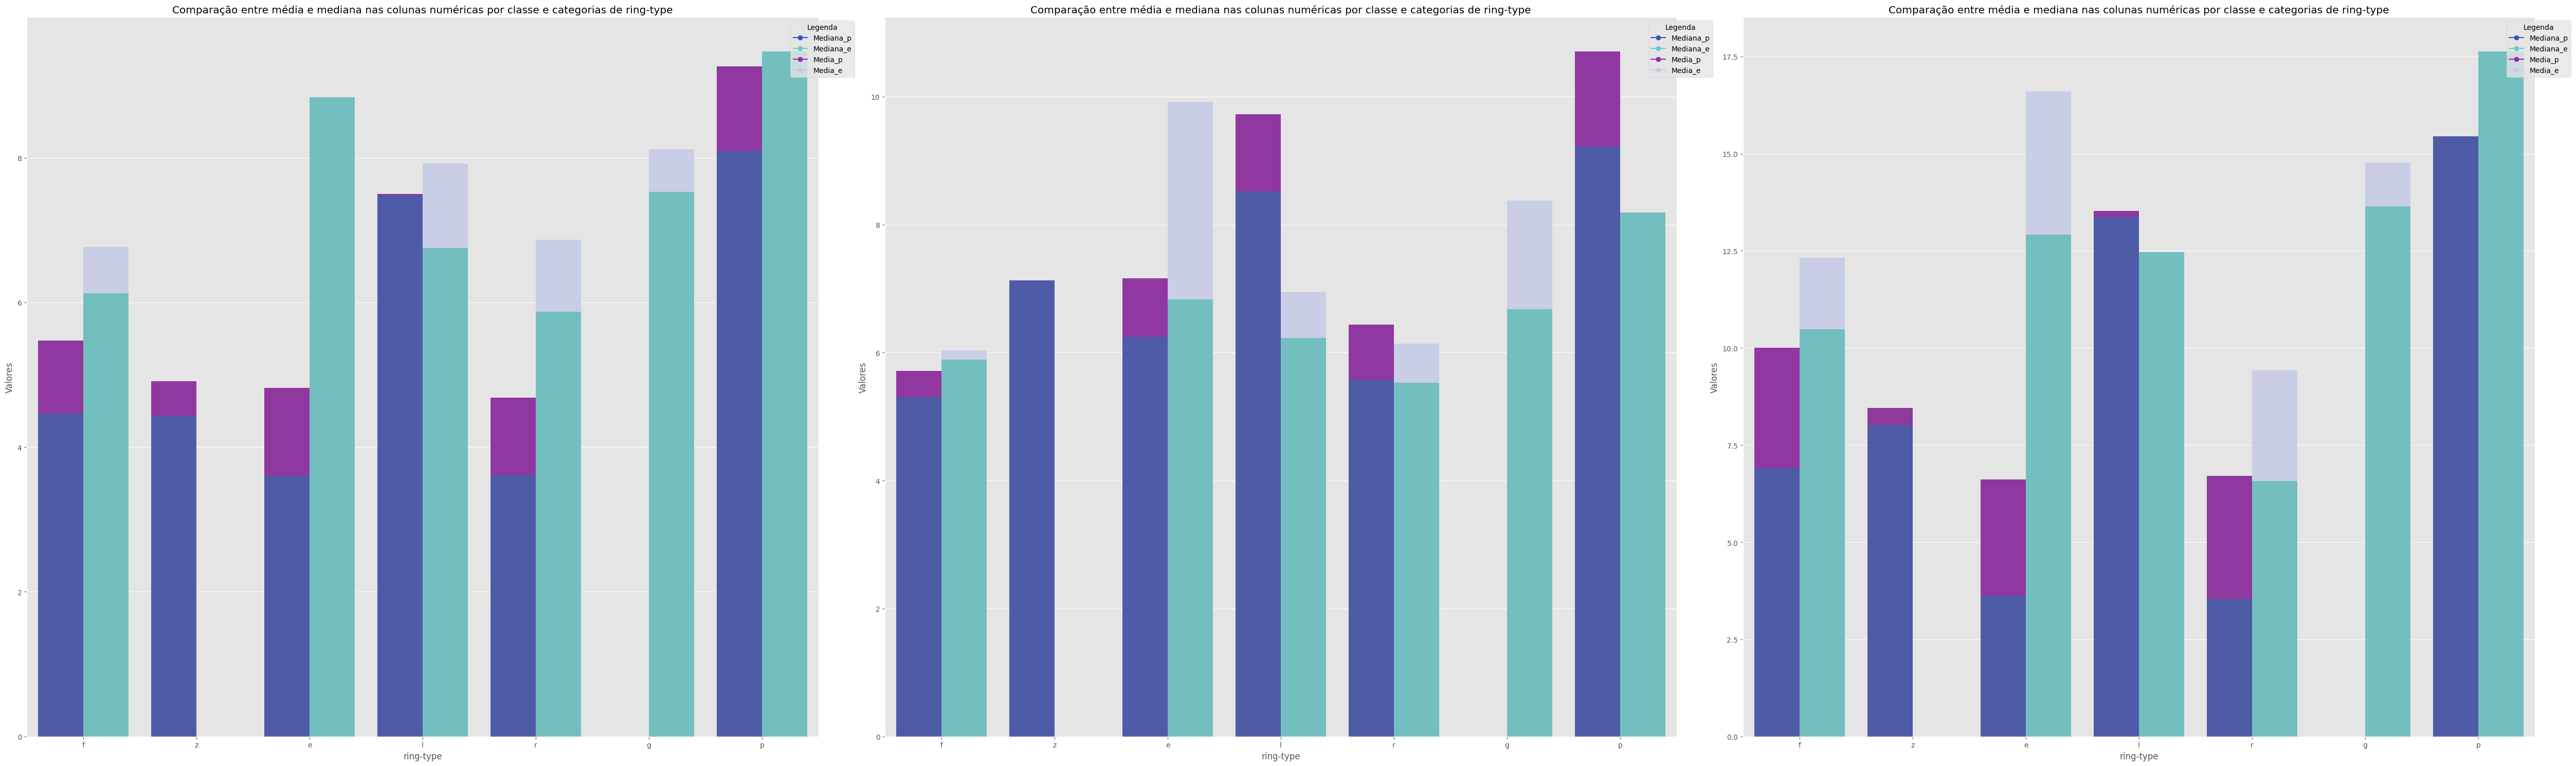

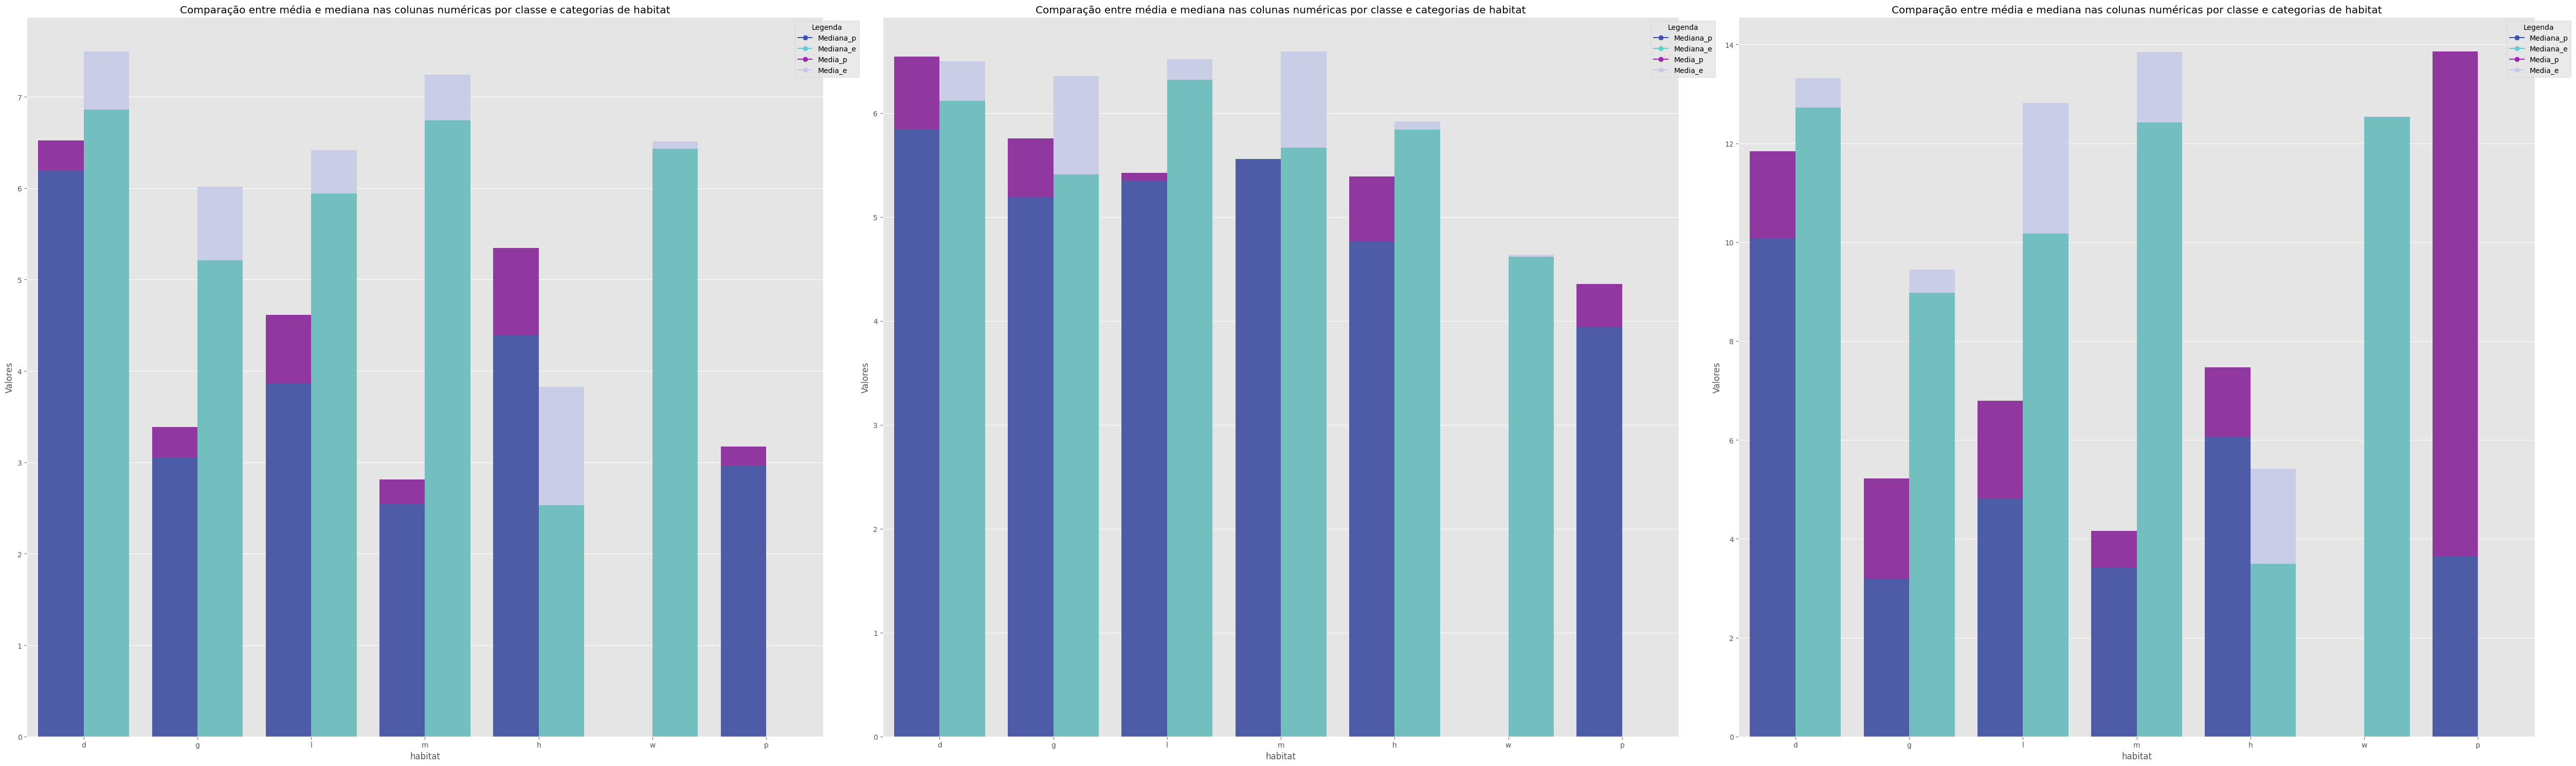

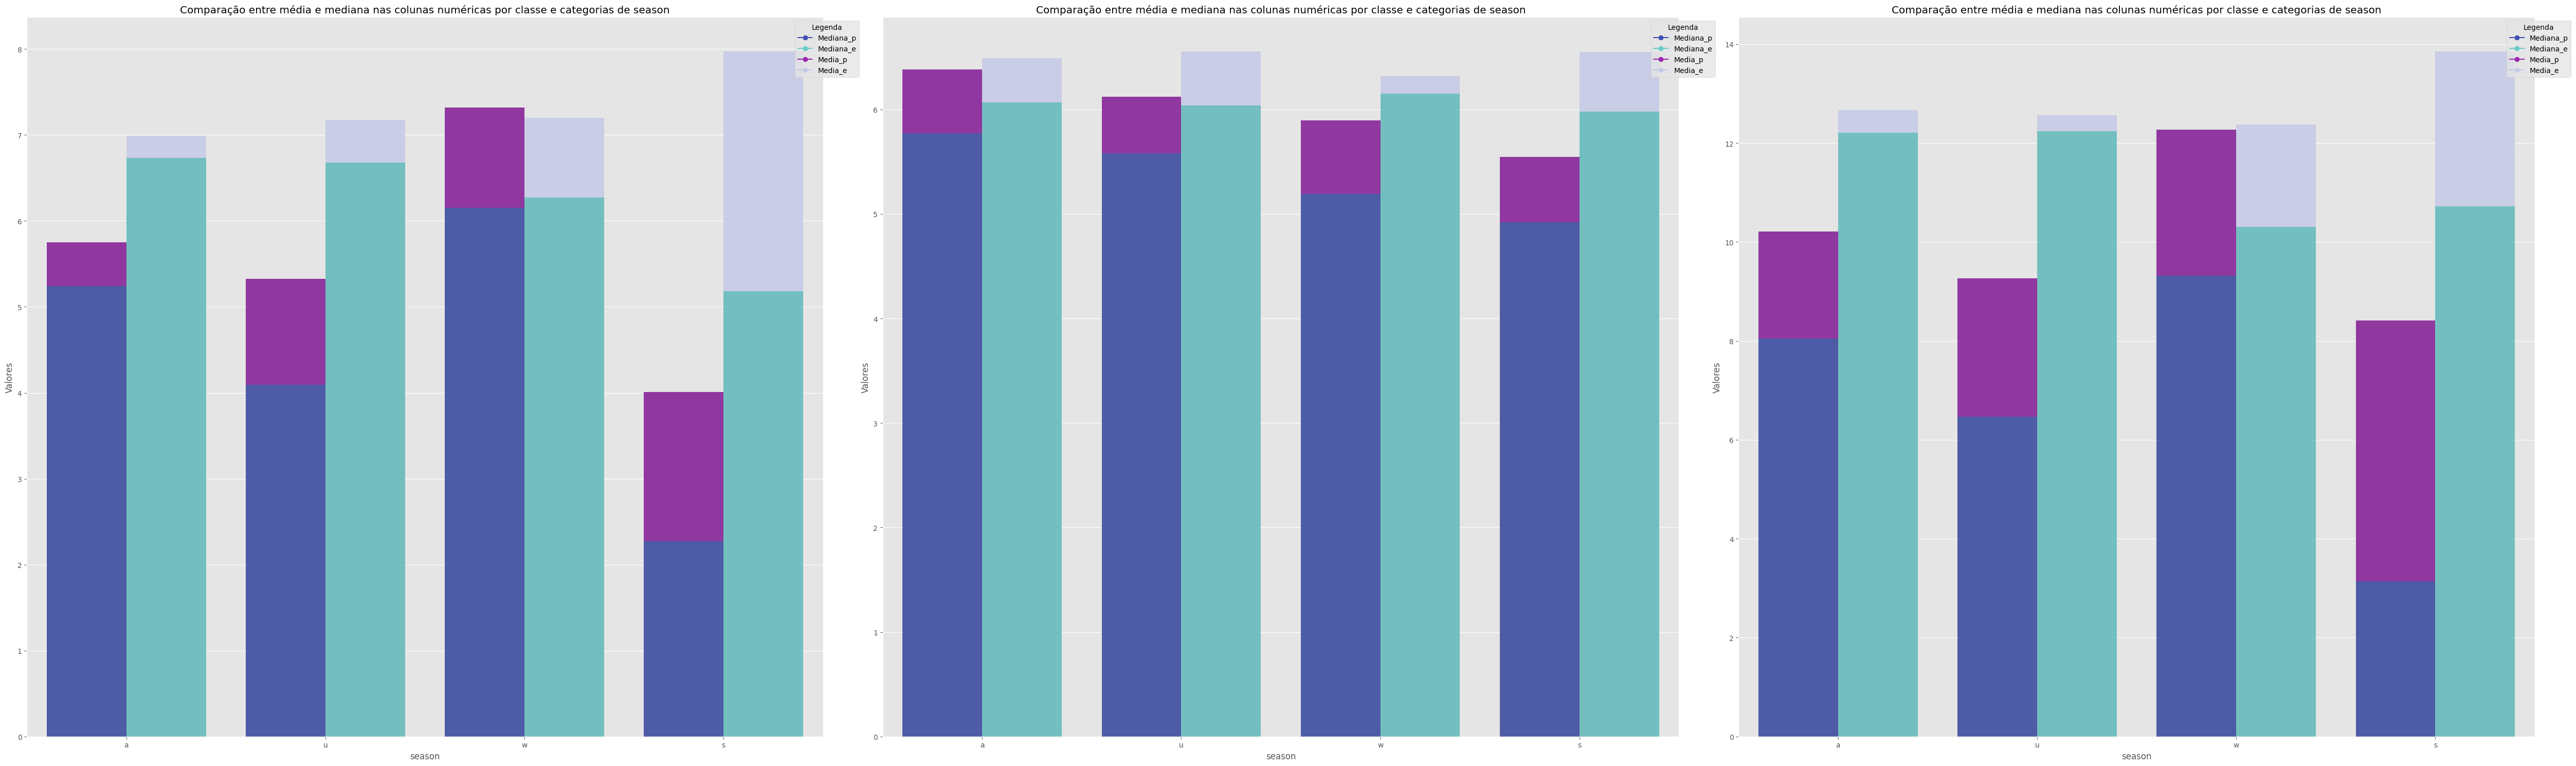

In [ ]:
for col in train.columns:
    if train[col].dtype == 'object':
        dados = train.groupby([col, "class"])[['cap-diameter', 'stem-height', 'stem-width']].agg({
            'cap-diameter': ['mean', 'median','count'],
            'stem-height': ['mean','median', 'count'],
            'stem-width': ['mean', 'median','count']
        }).sort_values(by=('cap-diameter', 'count'), ascending=False).head(12)

        fig, axs = plt.subplots(1,3, figsize=(50, 15))

        # Gráfico de barras para cap-diameter
        sns.barplot(x=dados.index.get_level_values(0), y=dados[('cap-diameter', 'mean')], hue=dados.index.get_level_values(1), ax=axs[0],palette=['#9C27B0', '#C5CAE9'])
        sns.barplot(x=dados.index.get_level_values(0), y=dados[('cap-diameter', 'median')], hue=dados.index.get_level_values(1), ax=axs[0], palette=['#3F51B5', '#66CCCC'])
        handles = [plt.Line2D([], [], marker='o', color='#3F51B5', label='Mediana_p'),
                plt.Line2D([], [], marker='o', color='#66CCCC', label='Mediana_e'),
                plt.Line2D([], [], marker='o', color='#9C27B0', label='Media_p'),
                plt.Line2D([], [], marker='o', color='#C5CAE9', label='Media_e'),]
        axs[0].legend(title='Legenda', loc='upper right', bbox_to_anchor=(1.05, 1), handles=handles)
        axs[0].set_title(f'Comparação entre média e mediana nas colunas numéricas por classe e categorias de {col}')
        axs[0].set_ylabel('Valores')
        axs[0].set_xlabel(col)

        # Gráfico de barras para stem-height
        sns.barplot(x=dados.index.get_level_values(0), y=dados[('stem-height', 'mean')], hue=dados.index.get_level_values(1), ax=axs[1], palette=['#9C27B0', '#C5CAE9'])
        sns.barplot(x=dados.index.get_level_values(0), y=dados[('stem-height', 'median')], hue=dados.index.get_level_values(1), ax=axs[1], palette=['#3F51B5', '#66CCCC'])
        handles = [plt.Line2D([], [], marker='o', color='#3F51B5', label='Mediana_p'),
                plt.Line2D([], [], marker='o', color='#66CCCC', label='Mediana_e'),
                plt.Line2D([], [], marker='o', color='#9C27B0', label='Media_p'),
                plt.Line2D([], [], marker='o', color='#C5CAE9', label='Media_e'),]
        axs[1].legend(title='Legenda', loc='upper right', bbox_to_anchor=(1.05, 1), handles=handles)
        axs[1].set_title(f'Comparação entre média e mediana nas colunas numéricas por classe e categorias de {col}')
        axs[1].set_ylabel('Valores')
        axs[1].set_xlabel(col)

        # Gráfico de barras para stem-width
        sns.barplot(x=dados.index.get_level_values(0), y=dados[('stem-width', 'mean')], hue=dados.index.get_level_values(1), ax=axs[2], palette=['#9C27B0', '#C5CAE9'])
        sns.barplot(x=dados.index.get_level_values(0), y=dados[('stem-width', 'median')], hue=dados.index.get_level_values(1), ax=axs[2], palette=['#3F51B5', '#66CCCC'])
        handles = [plt.Line2D([], [], marker='o', color='#3F51B5', label='Mediana_p'),
                plt.Line2D([], [], marker='o', color='#66CCCC', label='Mediana_e'),
                plt.Line2D([], [], marker='o', color='#9C27B0', label='Media_p'),
                plt.Line2D([], [], marker='o', color='#C5CAE9', label='Media_e'),]
        axs[2].legend(title='Legenda', loc='upper right', bbox_to_anchor=(1.05, 1), handles=handles)
        axs[2].set_title(f'Comparação entre média e mediana nas colunas numéricas por classe e categorias de {col}')
        axs[2].set_ylabel('Valores')
        axs[0].set_xlabel(col)

        # Mostre o gráfico
        plt.tight_layout()
        plt.show()

# 5_Tratamento_Dados

**Foi aplicado os seguintes tratamentos ao conjunto de dados**

1. **Colocando as classes como numéricas**
    - Colocando as classe `e=comestivel` como `1` e a classe `p=venenosa` como `0`.    

2. **Retirando IDs**:
   - Remove a coluna `id` de `train_x` e `test_x`.
  
3. **Dropando colunas**:
   - Remove as seguintes colunas que comtém muitos valores nan: `veil-type`, `spore-print-color`, `stem-root`, `veil-color`, `stem-surface`, `gill-spacing`.
  
4. **Criando colunas de NaN (OneHot)**:
   - Algumas outras colunas tambem tem menos de 20% de nan, mantive elas mas crie colunas onhot para os dados faltantes, criando as seguintes colunas:`cap-surface_nan`, `gill-attachment_nan`, `ring-type_nan`.
  
5. **Imputação de Dados Faltantes Categoricas**:
   - ImputEI valores faltantes nas colunas Categoricas, escolhendo o metodo de imputação a `most_frequent`.

6. **Imputação de Dados Faltantes Numericos**:
   - ImputEI valores faltantes nas colunas Numericas, escolhendo o metodo de imputação a `mediam`.
  
7. **Escalonamento de Dados Numéricos**:
   - Escalona as variáveis numéricas utilizando a técnica de escalonamento `StandardScaler`.
  
8. **OneHot Encoding com Frequência Mínima**:
   - Aplica `OneHotEncoder` com uma frequência mínima de 5%, criando uma coluna `infrequent_if_exist` para categorias com menos de 5%.

Após todo os tratamentos os conjuntos de dados ficaram com os seguintes tamanhos:

- treino: `(2493556, 59)`

- teste: `(623389, 59)`


In [13]:
if IN_COLAB:
    sys.path.append("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados")
    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados")
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados'
else:
    # Adiciona o caminho da pasta 'dados' ao sys.path
    sys.path.append("dados")
    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("dados")
    diretorio = 'dados'

tratar_dados = False

if "dados_tratados.pkl" not in arquivos or tratar_dados == True:
    ## separando as x e y
    train_x = train.drop("class", axis=1)
    train_y = train["class"]

    test_x = test.drop("class", axis=1)
    test_y = test["class"]

    ## colocando as classe e=comestivel como 1 e a classe p=venenosa como 0.

    train_y = np.where(train_y == 'e', 1, 0)
    test_y = np.where(test_y == 'e', 1, 0)


    ## criando tratamento
    trat = Tratamento()

    ## retirando ids
    train_x_sem_id, train_x_id = trat.retirando_ids(train_x)
    test_x_sem_id, test_x_id = trat.retirando_ids(test_x)


    ## Dropando colunas 'veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface', 'gill-spacing'
    columns_drop = [
        "veil-type",
        "spore-print-color",
        "stem-root",
        "veil-color",
        "stem-surface",
        "gill-spacing",
    ]

    train_x_drop = trat.drop_columns_nan(train_x_sem_id, columns_drop)
    test_x_drop = trat.drop_columns_nan(test_x_sem_id, columns_drop)


    ## Criando uma coluna com 1 onde tem nan e 0 onde não tem nan, nas colunas 'cap-surface', 'gill-attachment', 'ring-type'
    colunas_onhot_nan = ['cap-surface', 'gill-attachment', 'ring-type']

    train_x_nan_onhot = trat.criando_onhot_nan(train_x_drop, colunas_onhot_nan)
    test_x_nan_onhot = trat.criando_onhot_nan(test_x_drop, colunas_onhot_nan)


    ## Imputando em valores faltantes nas colunas categoricas

    train_x_imput_categorica, modelo_input_cat = trat.imputar_dados_faltantes_categoricos(train_x_nan_onhot)
    test_x_imput_categorica = trat.imputar_dados_faltantes_categoricos(test_x_nan_onhot,modelo_input_cat)


    ## Imputando em valores faltantes nas colunas numericas

    train_x_imput_numerical, modelo_input_num = trat.imputar_dados_faltantes_numericos(train_x_imput_categorica)
    test_x_imput_numerical = trat.imputar_dados_faltantes_numericos(test_x_imput_categorica,modelo_input_num)


    ## escalonando os dados numericos

    col_numeric = ['cap-diameter', 'stem-height', 'stem-width']

    train_x_stard_numerical, modelo_stard = trat.transformacao_variaveis_numericas(train_x_imput_numerical,col_transformada=col_numeric)
    test_x_stard_numerical = trat.transformacao_variaveis_numericas(test_x_imput_numerical,col_transformada=col_numeric, modelo_imputer=modelo_stard)


    ## Passando OneHotEncoder com os parametros minimo de 5% de frequencia onde sera criada a coluna infrequent_if_exist se nao atingir esse limite, tentando dimunir o numero de categorias para algumas colunas

    col_categorical = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']

    x_train_onehot, model_onehot = trat.criando_onehot(train_x_stard_numerical, col_categorical)

    x_test_onhot = trat.criando_onehot(test_x_stard_numerical, col_categorical, model_onehot=model_onehot)



    print(x_train_onehot.shape, x_test_onhot.shape)
    print('Dados tratados!')

    dados_tratados = {}
    dados_tratados['x_train'] = x_train_onehot
    dados_tratados['x_test'] = x_test_onhot
    dados_tratados['y_train'] = train_y
    dados_tratados['y_test'] = test_y
    dados_tratados['modelo_input_cat'] = modelo_input_cat
    dados_tratados['modelo_input_num'] = modelo_input_num
    dados_tratados['modelo_stard'] = modelo_stard
    dados_tratados['model_onehot'] = model_onehot
    dados_tratados['columns_drop'] = columns_drop
    dados_tratados['colunas_onhot_nan'] = colunas_onhot_nan
    dados_tratados['col_numeric'] = col_numeric
    dados_tratados['col_categorical'] = col_categorical
    with open(diretorio + '/dados_tratados.pkl', 'wb') as f:
        pickle.dump(dados_tratados, f)

else:
    with open(diretorio + '/dados_tratados.pkl', 'rb') as f:
        dados_tratados = pickle.load(f)

    x_train = dados_tratados['x_train']
    x_test = dados_tratados['x_test']
    y_train = dados_tratados['y_train']
    y_test = dados_tratados['y_test']
    modelo_input_cat = dados_tratados['modelo_input_cat']
    modelo_input_num = dados_tratados['modelo_input_num']
    modelo_stard = dados_tratados['modelo_stard']
    model_onehot = dados_tratados['model_onehot']
    columns_drop = dados_tratados['columns_drop']
    colunas_onhot_nan =  dados_tratados['colunas_onhot_nan']
    col_numeric = dados_tratados['col_numeric']
    col_categorical = dados_tratados['col_categorical']


    print('X_treino:',x_train.shape, 'X_teste:',x_test.shape,  'Y_train:',y_train.shape, 'Y_teste:',y_test.shape,)
    print('Dowload dos dados com sucesso!')


X_treino: (2493556, 59) X_teste: (623389, 59) Y_train: (2493556,) Y_teste: (623389,)
Dowload dos dados com sucesso!


In [14]:
x_train_colunas = x_train.copy()
x_test_colunas = x_test.copy()

x_train = x_train.values
x_test = x_test.values

# 6_Treinamento_Dos_Modelos

Primeiramente, utilizei sete algoritmos para o treinamento com seus parâmetros padrão:

- `LogisticRegression()`
- `RandomForestClassifier()`
- `GradientBoostingClassifier()`
- `CatBoostClassifier()`
- `keras.Sequential()`
- `SGDClassifier(loss='log_loss')`
- `GaussianNB()`
--------------------------------------------------------------------------
Os melhores algoritmos com os parâmetros padrão, observando o `MCC`, foram o Random Forest com MCC de 0.87, seguido pelo Cat Boost com 0.58. Utilizando outras métricas, o Random Forest continua sendo o melhor. Sob a ótica da calibração, ele apresenta o menor Log Loss, o menor Brier Loss, e o menor ECE.


| Model                | Log Loss | Brier Loss | ECE  | MCC  |
|----------------------|----------|------------|------|------|
| Random Forest        | 0.35     | 0.098      | 0.005|0.866 |
| Gradient Boost       | 0.50     | 0.17       | 0.005| 0.56 |
| Cat Boost            | 0.52     | 0.16       | 0.02 | 0.58 |
| SGD Classifier       | 1.01     | 0.32       | 0.01 | 0.15 |
| Regressão Logística  | 1.01     | 0.32       | 0.01 | 0.14 |
| Redes Neurais        | 2.50     | 0.38       | 0.03 | 0.19 |
| Naive Bayes          | 4.61     | 0.38       | 0.04 | 0.17 |

-----------------------------------------------------------------------
Em termos de acurácia, o Random Forest obteve 93.4% de acerto, sendo o melhor. O próximo passo será a tunagem dos parâmetros, onde escolherei três algoritmos: Random Forest, Cat Boost, e Redes Neurais.

As tunagens dos parâmetros ocorreram em outros arquivos, com as seguintes configurações selecionadas:

- `CatBoostClassifier({'depth': 9, 'learning_rate': 0.15, 'l2_leaf_reg': 1, 'iterations': 500})`
- `RandomForestClassifier(criterion='entropy', max_depth=90, max_features=8, n_estimators=70)`
- `Redes Neurais`

      | Layer (type)   | Output Shape | Param # |
      |----------------|--------------|---------|
      | dense (Dense)  | (None, 8)    | 480     |
      | dense_1 (Dense)| (None, 8)    | 72      |
      | dense_2 (Dense)| (None, 8)    | 72      |
      | dense_3 (Dense)| (None, 8)    | 72      |
      | dense_4 (Dense)| (None, 8)    | 72      |
      | dense_5 (Dense)| (None, 1)    | 9       |



## Treinando modelos com parametros padrões

In [ ]:
## criar a redes_neural

model_rede = keras.Sequential()
model_rede.add(layers.Dense(units=40,activation='relu',input_shape=(x_train.shape[1],)))
#model.add(layers.Dropout(0.20))
model_rede.add(layers.Dense(units=60,activation='relu'))
#model.add(layers.Dropout(0.20))
model_rede.add(layers.Dense(units=40,activation='relu'))
#model.add(layers.Dropout(0.20))
model_rede.add(layers.Dense(units=1,activation='sigmoid'))
model_rede.summary()
opt = keras.optimizers.SGD(learning_rate=0.01)
model_rede.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy', 'Recall'])
#epochs_hist = model.fit(x_treino, y_treino.values, epochs=100,batch_size=500)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 40)                  │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 60)                  │           2,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │           2,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,341 (28.68 KB)

 Trainable params: 7,341 (28.68 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/modelos'
else:
    diretorio = 'modelos'

modelos = {
    #'logistic_regression': LogisticRegression(),
    #'random_forest': RandomForestClassifier(),
    #'gradient_boost': GradientBoostingClassifier(),
    #'cat_boost': CatBoostClassifier(),
    #'redes_neural': model_rede,
    'sgd_classifier': SGDClassifier(loss='log_loss'),
    'naive_bayes': GaussianNB()
}


for key,model in modelos.items():
    if key == 'redes_neural':
        epochs_hist = model.fit(x_train, y_train, epochs=100,batch_size=500,verbose=0)
        print('O modelo treinado é o:', key)
        with open(diretorio + f'/modelo_base_{key}.pkl', 'wb') as f:
            pickle.dump(model, f)
        print('----------------------------------------------------')
    else:
        model = model
        if key == 'cat_boost':
            model_treinado = model.fit(x_train, y_train,verbose=0)
        else:
            model_treinado = model.fit(x_train, y_train)
        print('O modelo treinado e de:', key)
        with open(diretorio + f'/modelo_base_{key}.pkl', 'wb') as f:
            pickle.dump(model, f)

        print('----------------------------------------------------')

O modelo treinado e de: sgd_classifier
----------------------------------------------------
O modelo treinado e de: naive_bayes
----------------------------------------------------


In [ ]:
if IN_COLAB:
    sys.path.append("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/modelos")
    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/modelos")
    modelos_base = [arquivo for arquivo in arquivos if 'modelo_base' in arquivo]
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/modelos'
else:
    sys.path.append("modelos")
    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("modelos")
    modelos_base = [arquivo for arquivo in arquivos if 'modelo_base' in arquivo]
    diretorio = 'modelos'


dic_modelos_padrao = {}
for index, model in enumerate(modelos_base):
    with open(diretorio+'/'+ model, 'rb') as f:
        dic_modelos_padrao[modelos_base[index].split('.')[0].split('modelo_base_')[1]] = pickle.load(f)

matthews = {}
for key,model in dic_modelos_padrao.items():
    if key == 'redes_neural':
        print('O modelo treinado é o:', key)
        y_pred = model.predict(x_test).squeeze()
        y_pred_redes = (y_pred > 0.5).astype(int)
        matthews[key] = matthews_corrcoef(y_test,y_pred_redes)
        print(classification_report(y_test, y_pred_redes))
        print('----------------------------------------------------')

    else:
        y_pred = model.predict(x_test).squeeze()
        print('O modelo treinado e de:', key)
        print(key, model.score(x_test, y_test))
        print(classification_report(y_test, model.predict(x_test)))
        matthews[key] = matthews_corrcoef(y_test,model.predict(x_test))
        print('----------------------------------------------------')

O modelo treinado e de: logistic_regression
logistic_regression 0.5661841963846009
              precision    recall  f1-score   support

           0       0.56      1.00      0.72    341025
           1       0.93      0.05      0.09    282364

    accuracy                           0.57    623389
   macro avg       0.74      0.52      0.40    623389
weighted avg       0.73      0.57      0.43    623389

----------------------------------------------------
O modelo treinado e de: random_forest
random_forest 0.9336497756617457
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    341025
           1       0.93      0.93      0.93    282364

    accuracy                           0.93    623389
   macro avg       0.93      0.93      0.93    623389
weighted avg       0.93      0.93      0.93    623389

----------------------------------------------------
O modelo treinado e de: gradient_boost
gradient_boost 0.7665181772536891
             

In [ ]:
pd.DataFrame(list(matthews.items()), columns=['Model', 'MCC']).sort_values(by='MCC', ascending=False)

Model       MCC
1        random_forest  0.866100
3            cat_boost  0.583948
2       gradient_boost  0.560476
4         redes_neural  0.187552
6          naive_bayes  0.172149
5       sgd_classifier  0.147736
0  logistic_regression  0.144209

In [ ]:
avali = AvaliacaoModelos()

In [ ]:
results_df, predictions = avali.calibrations_metrics(dic_modelos_padrao, x_test, y_test)

19481/19481 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step


In [ ]:
results_df.sort_values(by='Log Loss')

Model  Log Loss  Brier Loss       ECE
1        random_forest  0.354361    0.098235  0.005220
2       gradient_boost  0.502887    0.165515  0.005129
3            cat_boost  0.518413    0.156549  0.020920
5       sgd_classifier  1.006149    0.320425  0.009015
0  logistic_regression  1.007042    0.320729  0.009224
4         redes_neural  2.496958    0.381925  0.026467
6          naive_bayes  4.601501    0.376481  0.036788

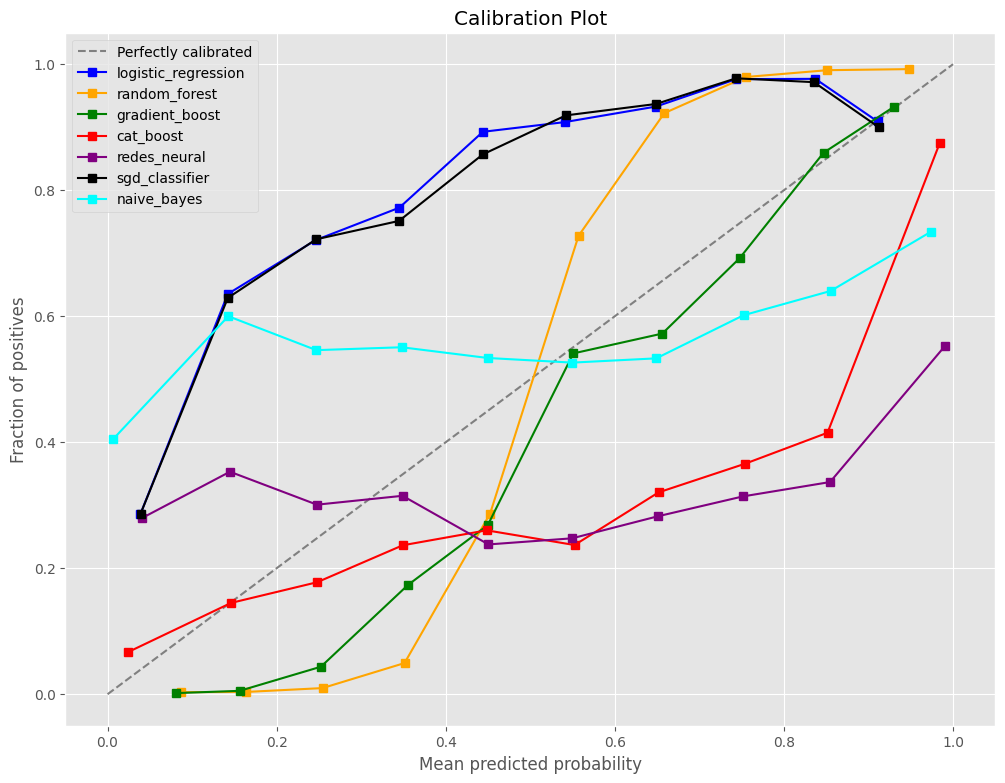

In [ ]:
avali.calibracao_plot(y_test, predictions)

# 7_Calibrando_os_modelos

Nessa parte sera utilizado o algoritimo Venn-ABERS para calibrar os modelos. A calibração Venn-Abers é uma técnica avançada usada para melhorar a confiança das previsões probabilísticas de modelos de classificação. É uma extensão dos métodos de calibração de probabilidade tradicionais, como Platt Scaling e Isotonic Regression. A calibração Venn-Abers é especialmente útil quando se deseja obter intervalos de confiança para as previsões, em vez de apenas uma única probabilidade.

In [ ]:
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/modelos'
else:
    diretorio = 'modelos'


selecionando_modelos = ['modelo_base_random_forest.pkl', 'modelo_base_gradient_boost.pkl', 'modelo_base_cat_boost.pkl', 'modelo_base_redes_neural.pkl', ## Modelos base
                        'modelo_cat_boost.pkl','modelo_random_forest.pkl', 'modelo_redes_neural.h5'] # Modelos tunado

## fazendo dowload dos modelos
dic_modelos = {}
for index, model in enumerate(selecionando_modelos):
    print(selecionando_modelos[index])
    with open(diretorio+'/'+ model, 'rb') as f:
        if '_base_' in selecionando_modelos[index]:
            dic_modelos[selecionando_modelos[index].split('.pkl')[0]] = pickle.load(f)
        else:
            try:
                dic_modelos[selecionando_modelos[index].split('.pkl')[0] + '_tunado'] = pickle.load(f)
            except UnpicklingError:
                dic_modelos[selecionando_modelos[index].split('.h5')[0] + '_tunado'] = keras.models.load_model(diretorio + '/modelo_redes_neural.h5')


modelo_base_random_forest.pkl
modelo_base_gradient_boost.pkl
modelo_base_cat_boost.pkl
modelo_base_redes_neural.pkl
modelo_cat_boost.pkl
modelo_random_forest.pkl
modelo_redes_neural.h5


In [ ]:
##  Venn-ABERS calibration no modelo base random forest
va_random = VennAbersCalibrator(estimator=dic_modelos['modelo_base_random_forest'], inductive=False, n_splits=10)
va_random.fit(x_train, y_train)
with open(diretorio + f'/random_forest_base_ven.pkl', 'wb') as f:
      pickle.dump(va_random, f)

In [ ]:
## Venn-ABERS calibration no  modelo base Cat boost
va_cat = VennAbersCalibrator(estimator=dic_modelos['modelo_base_cat_boost'], inductive=False, n_splits=10)
va_cat.fit(x_train, y_train)
with open(diretorio + f'/cat_boost_base_ven.pkl', 'wb') as f:
      pickle.dump(va_cat, f)

In [ ]:
## Venn-ABERS calibration no  modelo base redes neurais
va_redes = VennAbersCalibrator(estimator=KerasTrainedRegressor(dic_modelos['modelo_base_redes_neural']), inductive=False, n_splits=10)
va_redes.fit(x_train, y_train)
with open(diretorio + f'/redes_neural_base_ven.pkl', 'wb') as f:
      pickle.dump(va_redes, f)

38962/38962 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step
38962/38962 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step
13637/13637 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


In [ ]:
## Venn-ABERS calibration no  modelo base Gradiente Boost
va_grad = VennAbersCalibrator(estimator=dic_modelos['modelo_base_gradient_boost'], inductive=False, n_splits=10)
va_grad.fit(x_train, y_train)
with open(diretorio + f'/gradiente_boost_base_ven.pkl', 'wb') as f:
      pickle.dump(va_grad, f)

In [ ]:
##  Venn-ABERS calibration no modelo tunado random forest
va_random_tunado = VennAbersCalibrator(estimator=dic_modelos['modelo_random_forest_tunado'].best_estimator_, inductive=False, n_splits=10)
va_random_tunado.fit(x_train, y_train)
with open(diretorio + f'/random_forest_tunado_ven.pkl', 'wb') as f:
      pickle.dump(va_random_tunado, f)

In [ ]:
## Venn-ABERS calibration no  modelo base Cat boost
va_cat_tunado = VennAbersCalibrator(estimator=dic_modelos['modelo_cat_boost_tunado'], inductive=False, n_splits=10)
va_cat_tunado.fit(x_train, y_train)
with open(diretorio + f'/cat_boost_tunado_ven.pkl', 'wb') as f:
      pickle.dump(va_cat_tunado, f)

In [ ]:
## Venn-ABERS calibration no  modelo base redes neurais
va_redes = VennAbersCalibrator(estimator=KerasTrainedRegressor(dic_modelos['modelo_redes_neural_tunado']), inductive=False, n_splits=10)
va_redes.fit(x_train, y_train)
with open(diretorio + f'/redes_neural_tunado_ven.pkl', 'wb') as f:
      pickle.dump(va_redes, f)

38962/38962 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step
38962/38962 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step
13637/13637 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step


# 8_Avaliando_os_ modelos

## Análise dos Modelos de Classificação

Com base nos resultados fornecidos para diferentes modelos de classificação, podemos analisar o desempenho de cada um em termos de métricas como **Log Loss**, **Brier Loss**, **ECE (Expected Calibration Error)**, **Accuracy**, **Recall**, **Precision**, **F1 Score**, e **MCC (Matthews Correlation Coefficient)**.

### 1. Melhor Modelo: `modelo_random_forest_tunado`
- **Log Loss**: 0.315282 (baixo, indicando boa confiança nas previsões)
- **Brier Loss**: 0.084112 (baixo, sugerindo boa calibração de probabilidade)
- **ECE**: 0.006145 (baixo, indicando excelente calibração)
- **Accuracy**: 94.44% (alta, indicando bom desempenho geral)
- **F1 Score**: 0.939083 (alto, equilíbrio entre precisão e recall)
- **MCC**: 0.887996 (alto, indicando forte correlação entre previsões e rótulos reais)

**Conclusão:** O modelo Random Forest tunado (`modelo_random_forest_tunado`) se destaca como o melhor modelo em geral, com excelente desempenho em todas as métricas, especialmente em Log Loss, Brier Loss, ECE, e MCC.

### 2. Modelos com Venn-Abers Calibration
- **`random_forest_tunado_ven`**: Um modelo que utiliza calibração Venn-Abers, melhorando a **Log Loss** para 0.236318 e mantendo a **Accuracy** em 93.42%. Embora tenha um **ECE** ligeiramente maior que o modelo base tunado, ainda oferece uma boa calibração com um **F1 Score** de 0.928331.
- **`random_forest_base_ven`**: Com uma **Log Loss** de 0.251590 e **Accuracy** de 92.78%, este modelo mostra melhorias em relação ao modelo base, mas ainda não alcança o desempenho do modelo tunado.

**Conclusão:** A calibração Venn-Abers melhora a confiabilidade das previsões em termos de probabilidade (Log Loss), especialmente no caso do modelo `random_forest_tunado_ven`. No entanto, o modelo base tunado sem a calibração ainda supera em termos de desempenho geral.

### 3. Modelos Base
- **Random Forest (`modelo_base_random_forest`)**: Mostra uma **Log Loss** de 0.354361, **Accuracy** de 93.40% e **MCC** de 0.867110. Embora seja um modelo forte, ele é superado pela versão tunada.
- **CatBoost (`modelo_base_cat_boost`)** e **Gradient Boosting (`modelo_base_gradient_boost`)**: Estes modelos apresentam desempenho inferior com **Log Loss** acima de 0.5 e **MCC** abaixo de 0.6, sugerindo que são menos eficazes para esta tarefa.

**Conclusão:** Entre os modelos base, o Random Forest ainda é o melhor, mas é claramente superado quando tunado.

### 4. Modelos Tunados de CatBoost e Redes Neurais
- **CatBoost Tunado (`modelo_cat_boost_tunado`)** e sua versão calibrada (`cat_boost_tunado_ven`) têm **Log Loss** mais altas (0.381284 e 0.448885, respectivamente) e **MCC** mais baixos, sugerindo que o tuning não foi tão eficaz para este modelo.
- **Redes Neurais** (tanto a base quanto a tunada) apresentam **Log Loss** muito elevadas (>1.2), indicando previsões altamente incertas. Além disso, os valores de **Accuracy** e **MCC** são os mais baixos entre todos os modelos.

**Conclusão:** O tuning não trouxe benefícios significativos para os modelos de CatBoost e Redes Neurais, com ambos apresentando um desempenho inferior quando comparados ao Random Forest.

### Conclusão Geral do melhor modelo `random_forest_tunado_ven`

O **Random Forest Tunado** (`modelo_random_forest_tunado`) destacou-se como o melhor modelo em termos de precisão, calibração e desempenho geral. A calibração Venn-Abers aplicada ao modelo tunado (`random_forest_tunado_ven`) melhorou a confiabilidade das previsões probabilísticas, tornando-as mais calibradas. Embora o `random_forest_tunado_ven` não tenha obtido os melhores resultados em **Accuracy** e **F1 Score**, ele ficou muito próximo do melhor modelo, com apenas 1% de diferença tanto em **Accuracy** quanto em **F1 Score**, e 2% em **MCC**.

Dado que o `random_forest_tunado_ven` apresentou a melhor calibração e ficou próximo dos melhores resultados nas outras métricas, ele foi escolhido como o algoritmo ideal para esta tarefa. Portanto, para essa tarefa específica, o **Random Forest Tunado com Calibração Venn-Abers** (`random_forest_tunado_ven`) foi selecionado como a melhor escolha, equilibrando excelente calibração com um desempenho robusto nas principais métricas.






| Model                           | Log Loss | Brier Loss | ECE    | Accuracy | Recall  | Precision | F1 Score | MCC      |
|---------------------------------|----------|------------|--------|----------|---------|-----------|----------|----------|
| modelo_random_forest_tunado     | 0.315282 | 0.084112   | 0.006145 | 0.944369 | 0.946679 | 0.931607  | 0.939083 | 0.887996 |
| random_forest_tunado_ven        | 0.236318 | 0.062010   | 0.009572 | 0.934279 | 0.939723 | 0.917212  | 0.928331 | 0.867880 |
| modelo_base_random_forest       | 0.354361 | 0.098235   | 0.005220 | 0.934009 | 0.935063 | 0.920503  | 0.927726 | 0.867110 |
| random_forest_base_ven          | 0.251590 | 0.067133   | 0.006276 | 0.927767 | 0.924810 | 0.916478  | 0.920625 | 0.854388 |
| cat_boost_base_ven              | 0.439283 | 0.127614   | 0.022030 | 0.837674 | 0.941788 | 0.758314  | 0.840151 | 0.695645 |
| modelo_cat_boost_tunado         | 0.381284 | 0.118446   | 0.017859 | 0.831715 | 0.938151 | 0.751824  | 0.834716 | 0.684560 |
| cat_boost_tunado_ven            | 0.448885 | 0.135861   | 0.018358 | 0.815796 | 0.944936 | 0.728808  | 0.822918 | 0.661052 |
| modelo_base_cat_boost           | 0.518413 | 0.156549   | 0.020920 | 0.781430 | 0.886668 | 0.706012  | 0.786094 | 0.583948 |
| modelo_base_gradient_boost      | 0.502887 | 0.165515   | 0.005129 | 0.766518 | 0.890432 | 0.686885  | 0.775525 | 0.560476 |
| gradiente_boost_base_ven        | 0.587717 | 0.180181   | 0.018253 | 0.761106 | 0.815826 | 0.703862  | 0.755720 | 0.529928 |
| redes_neural_base_ven           | 1.892259 | 0.378667   | 0.027182 | 0.572719 | 0.814661 | 0.518018  | 0.633324 | 0.205695 |
| modelo_base_redes_neural        | 2.496958 | 0.381925   | 0.026467 | 0.559716 | 0.828601 | 0.508582  | 0.630297 | 0.187552 |
| modelo_redes_neural_tunado      | 1.205225 | 0.328330   | 0.016000 | 0.602014 | 0.421970 | 0.583966  | 0.489924 | 0.183589 |
| redes_neural_tunado_ven         | 1.197619 | 0.341152   | 0.012570 | 0.600280 | 0.430437 | 0.579046  | 0.493803 | 0.180481 |


In [ ]:
##Local do diretorio
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/modelos'
else:
    diretorio = 'modelos'
##Pegando os amodelos salvos
selecionando_modelos = ['modelo_base_random_forest.pkl', 'modelo_base_gradient_boost.pkl', 'modelo_base_cat_boost.pkl', 'modelo_base_redes_neural.pkl', ## Modelos base
                       'random_forest_base_ven.pkl', 'gradiente_boost_base_ven.pkl', 'cat_boost_base_ven.pkl', 'redes_neural_base_ven.pkl', ## Modelos Calibrados com VennAbersCalibrator
                        'modelo_cat_boost.pkl','modelo_random_forest.pkl','modelo_redes_neural.h5',  # Modelos tunado
                        'redes_neural_tunado_ven.pkl', 'random_forest_tunado_ven.pkl', 'cat_boost_tunado_ven.pkl'] # Modelos tunado com VennAbersCalibrator
dic_modelos = {}
for index, model in enumerate(selecionando_modelos):
    with open(diretorio+'/'+ model, 'rb') as f:
        if '_base_' in selecionando_modelos[index]:
            dic_modelos[selecionando_modelos[index].split('.pkl')[0]] = pickle.load(f)
        elif '_ven' in selecionando_modelos[index]:
            dic_modelos[selecionando_modelos[index].split('.pkl')[0]] = pickle.load(f)
        else:
            try:
                dic_modelos[selecionando_modelos[index].split('.pkl')[0] + '_tunado'] = pickle.load(f)
            except UnpicklingError:
                dic_modelos[selecionando_modelos[index].split('.h5')[0] + '_tunado'] = keras.models.load_model(diretorio + '/modelo_redes_neural.h5')
#

In [ ]:
dic_modelos

{'modelo_base_random_forest': RandomForestClassifier(),
 'modelo_base_gradient_boost': GradientBoostingClassifier(),
 'modelo_base_cat_boost': <catboost.core.CatBoostClassifier at 0x7fe98333a710>,
 'modelo_base_redes_neural': <Sequential name=sequential, built=True>,
 'random_forest_base_ven': <venn_abers.venn_abers.VennAbersCalibrator at 0x7fe8c68805e0>,
 'gradiente_boost_base_ven': <venn_abers.venn_abers.VennAbersCalibrator at 0x7fe8c67f9870>,
 'cat_boost_base_ven': <venn_abers.venn_abers.VennAbersCalibrator at 0x7fe8c3ea1690>,
 'redes_neural_base_ven': <venn_abers.venn_abers.VennAbersCalibrator at 0x7fe8c3eb0070>,
 'modelo_cat_boost_tunado': <catboost.core.CatBoostClassifier at 0x7fe8c3f22500>,
 'modelo_random_forest_tunado': RandomizedSearchCV(estimator=RandomForestClassifier(),
                    param_distributions={'criterion': ['gini', 'entropy'],
                                         'max_depth': [1, 2, 60, 70, 80, 90,
                                                      

In [ ]:
avali = AvaliacaoModelos()

In [ ]:
results_df, predictions = avali.calibrations_metrics(dic_modelos, x_test, y_test)

19481/19481 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step
19481/19481 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step
19481/19481 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step
19481/19481 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step


In [ ]:
results_df.sort_values(by='MCC', ascending=False)

Model  Log Loss  Brier Loss       ECE  Accuracy  \
9   modelo_random_forest_tunado  0.315282    0.084112  0.006145  0.944369   
12     random_forest_tunado_ven  0.236318    0.062010  0.009572  0.934279   
0     modelo_base_random_forest  0.354361    0.098235  0.005220  0.934009   
4        random_forest_base_ven  0.251590    0.067133  0.006276  0.927767   
6            cat_boost_base_ven  0.439283    0.127614  0.022030  0.837674   
8       modelo_cat_boost_tunado  0.381284    0.118446  0.017859  0.831715   
13         cat_boost_tunado_ven  0.448885    0.135861  0.018358  0.815796   
2         modelo_base_cat_boost  0.518413    0.156549  0.020920  0.781430   
1    modelo_base_gradient_boost  0.502887    0.165515  0.005129  0.766518   
5      gradiente_boost_base_ven  0.587717    0.180181  0.018253  0.761106   
7         redes_neural_base_ven  1.892259    0.378667  0.027182  0.572719   
3      modelo_base_redes_neural  2.496958    0.381925  0.026467  0.559716   
10   modelo_redes_neural_tunado  1.205225    0.328330  0.016000  0.602014   
11      redes_neural_tunado_ven  1.197619    0.341152  0.012570  0.600280   

      Recall  Precision  F1 Score       MCC  
9   0.946679   0.931607  0.939083  0.887996  
12  0.939723   0.917212  0.928331  0.867880  
0   0.935063   0.920503  0.927726  0.867110  
4   0.924810   0.916478  0.920625  0.854388  
6   0.941788   0.758314  0.840151  0.695645  
8   0.938151   0.751824  0.834716  0.684560  
13  0.944936   0.728808  0.822918  0.661052  
2   0.886668   0.706012  0.786094  0.583948  
1   0.890432   0.686885  0.775525  0.560476  
5   0.815826   0.703862  0.755720  0.529928  
7   0.814661   0.518018  0.633324  0.205695  
3   0.828601   0.508582  0.630297  0.187552  
10  0.421970   0.583966  0.489924  0.183589  
11  0.430437   0.579046  0.493803  0.180481

In [ ]:
for kay, y_proba in predictions.items():
    y_pred = (y_proba > 0.5).astype(int).squeeze()
    print('O modelo treinado é o:',key.replace('_', ' ').title())
    print(classification_report(y_test, y_pred))
    print('----------------------------------------------------')


O modelo treinado é o: Cat Boost Tunado Ven
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    341025
           1       0.93      0.93      0.93    282364

    accuracy                           0.93    623389
   macro avg       0.93      0.93      0.93    623389
weighted avg       0.93      0.93      0.93    623389

----------------------------------------------------
O modelo treinado é o: Cat Boost Tunado Ven
              precision    recall  f1-score   support

           0       0.88      0.66      0.76    341025
           1       0.69      0.89      0.78    282364

    accuracy                           0.77    623389
   macro avg       0.78      0.78      0.77    623389
weighted avg       0.79      0.77      0.77    623389

----------------------------------------------------
O modelo treinado é o: Cat Boost Tunado Ven
              precision    recall  f1-score   support

           0       0.88      0.69      0.78    341025

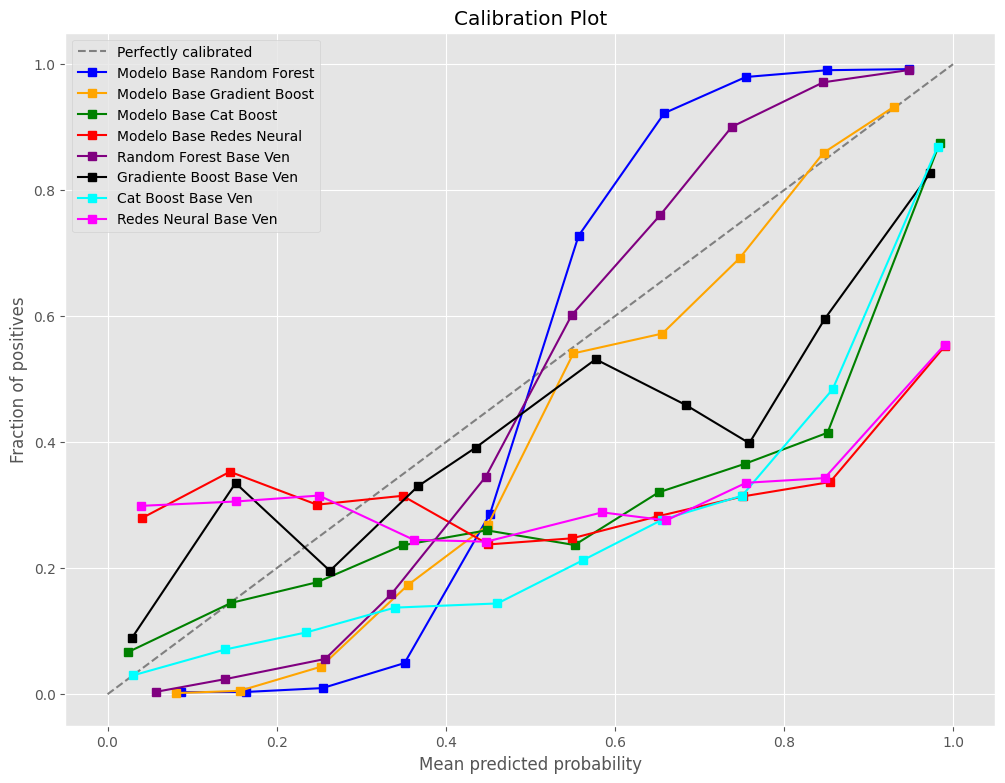

In [ ]:
avali.calibracao_plot(y_test, predictions)


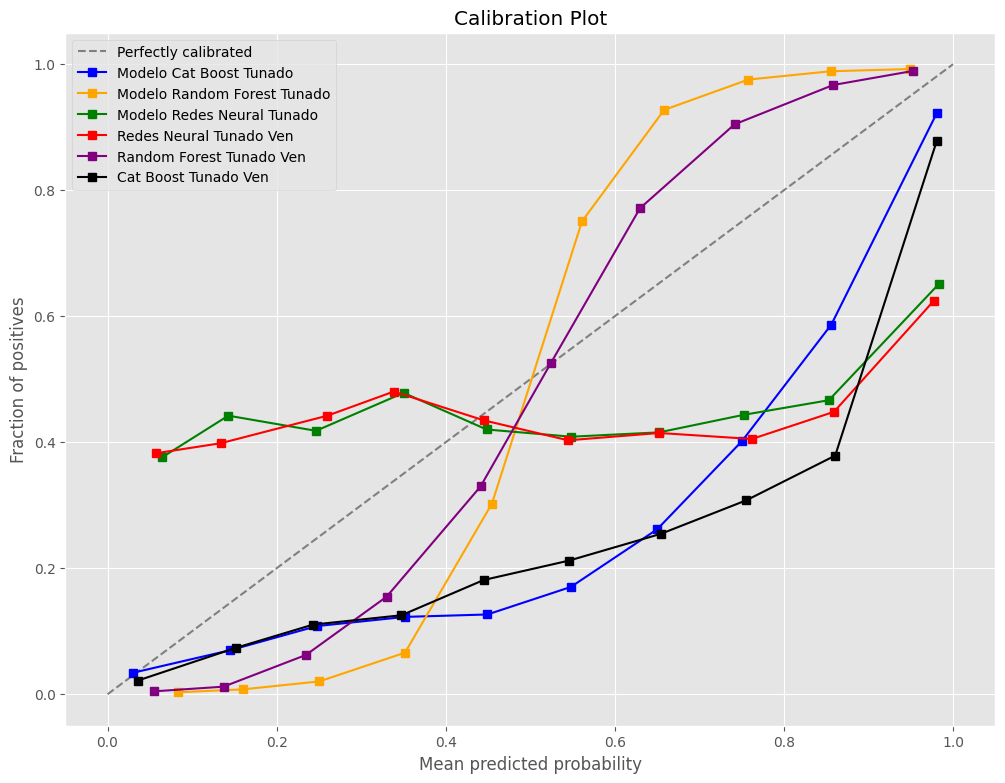

In [ ]:
ultimos_arrays = dict(list(predictions.items())[8:])
avali.calibracao_plot(y_test,ultimos_arrays)

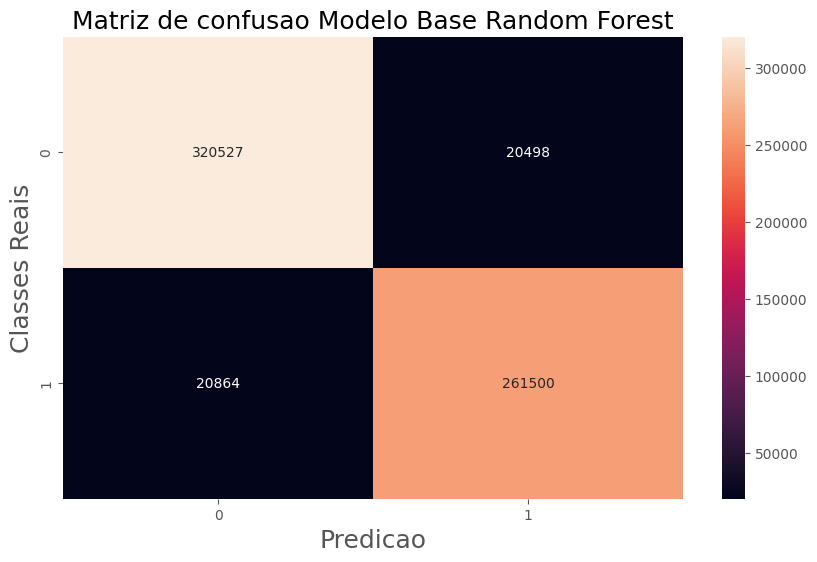

-----------------------------------------------------------------


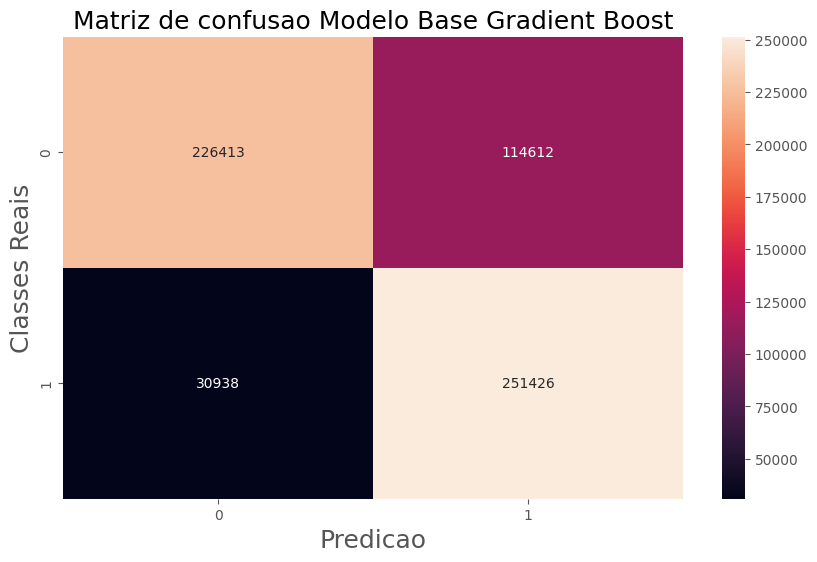

-----------------------------------------------------------------


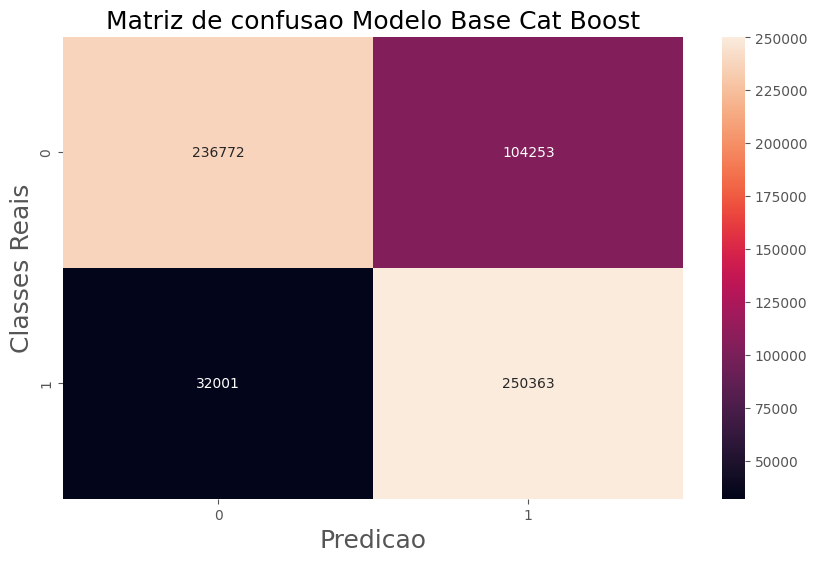

-----------------------------------------------------------------


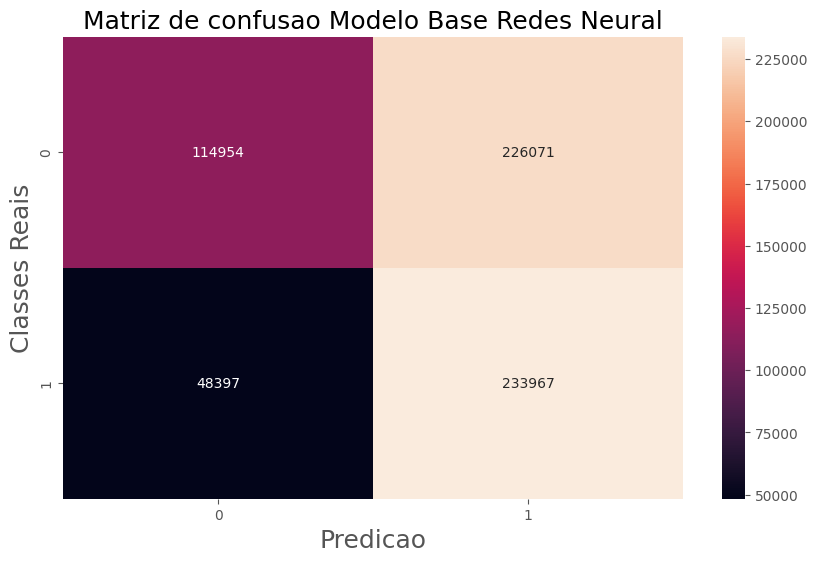

-----------------------------------------------------------------


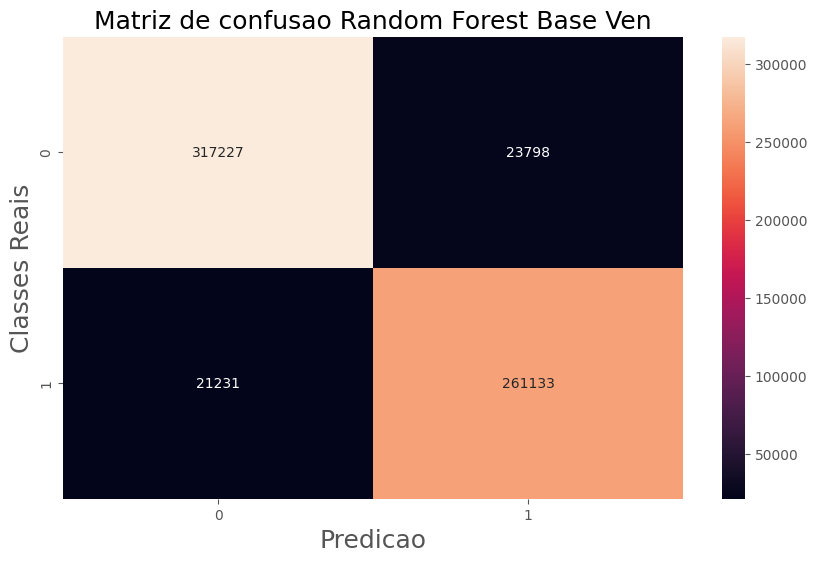

-----------------------------------------------------------------


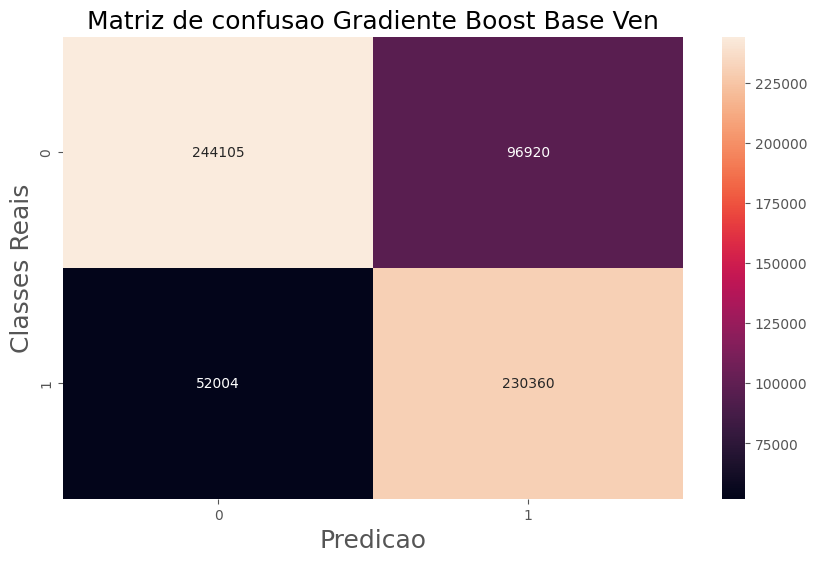

-----------------------------------------------------------------


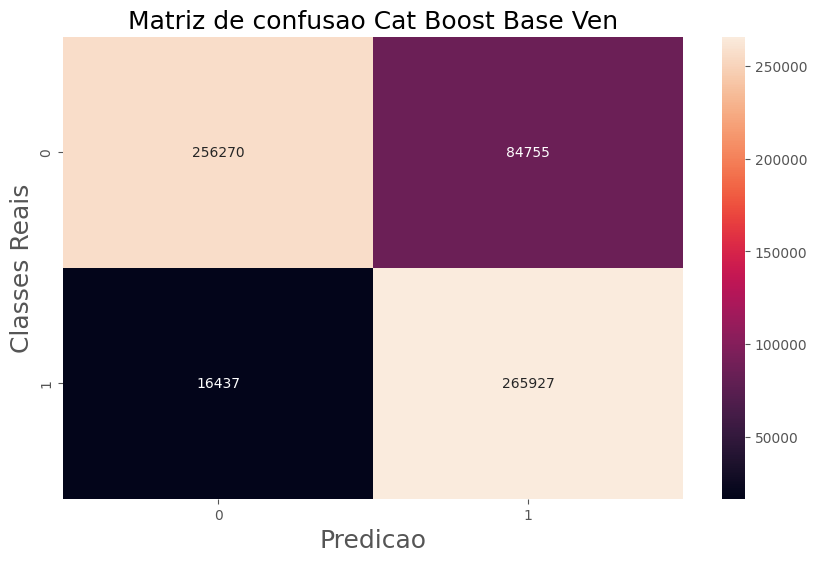

-----------------------------------------------------------------


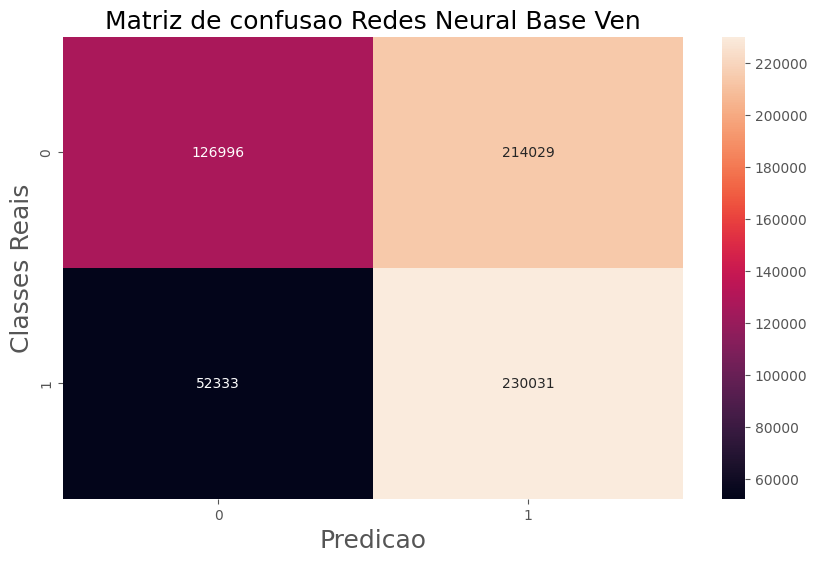

-----------------------------------------------------------------


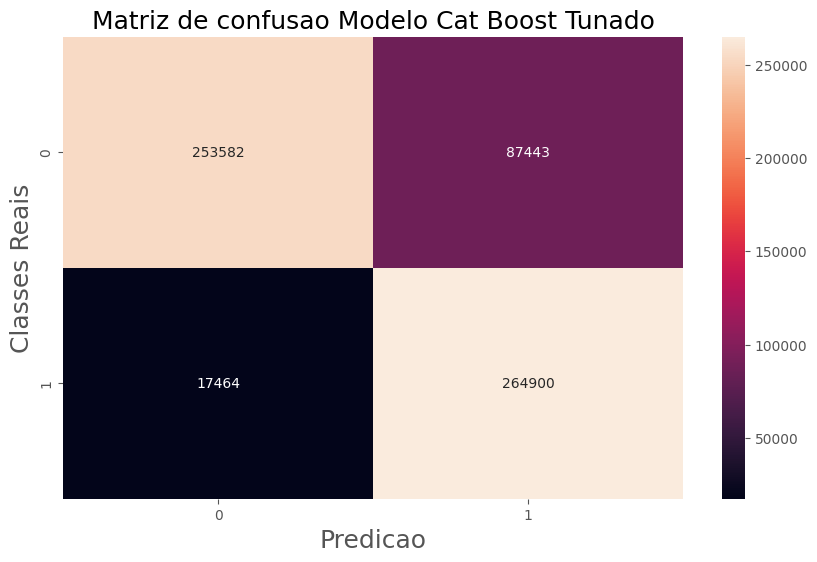

-----------------------------------------------------------------


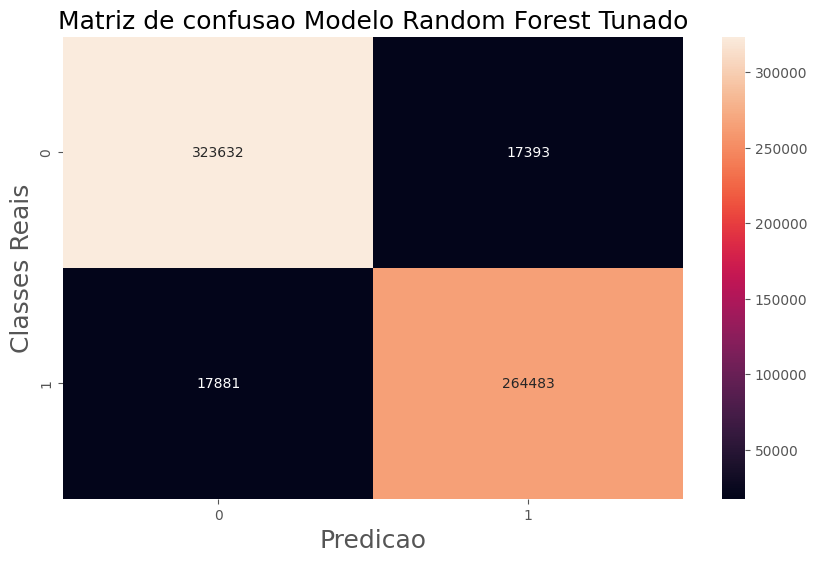

-----------------------------------------------------------------


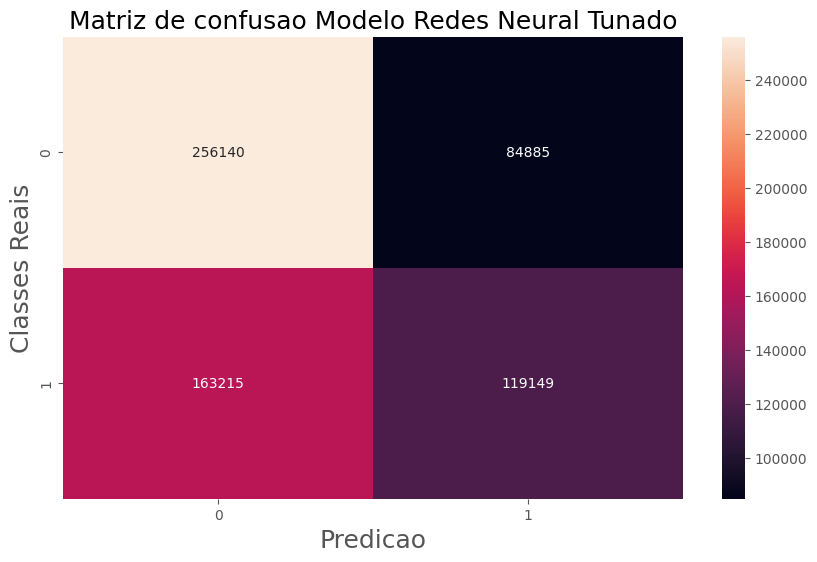

-----------------------------------------------------------------


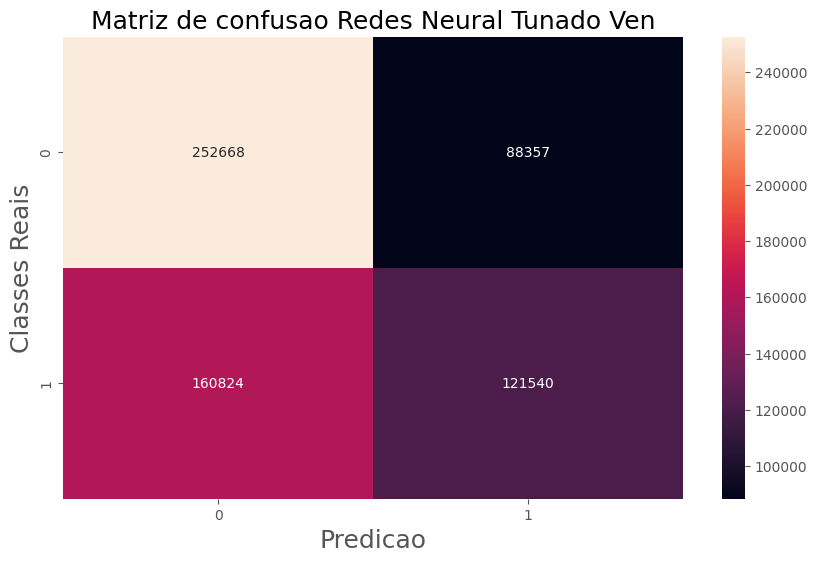

-----------------------------------------------------------------


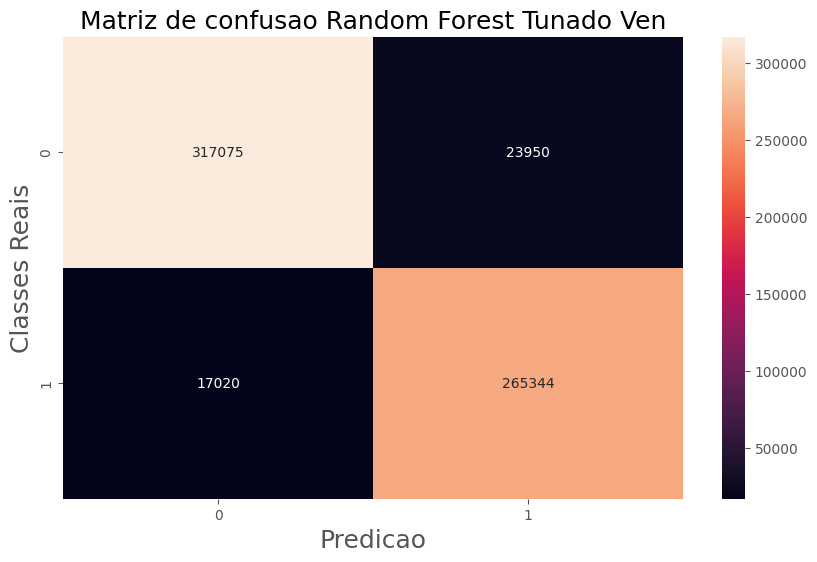

-----------------------------------------------------------------


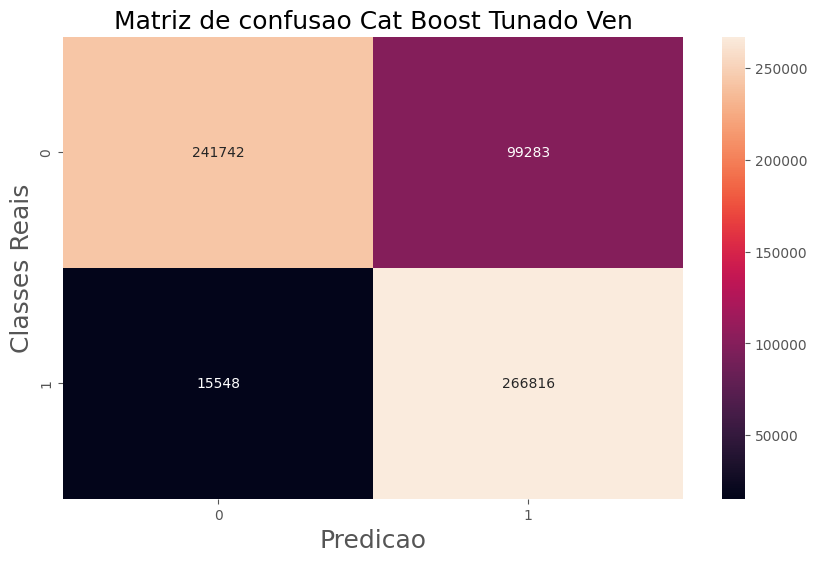

-----------------------------------------------------------------


In [ ]:
avali.matriz_confusao_matplotlib(predictions,y_test)

# 9_Submissao

In [15]:
## Tratando os dados para predicao

if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados'
else:
    diretorio = 'dados'

predict = pd.read_csv(diretorio + "/test.csv")

trat = Tratamento()

## retirando ids
predict_sem_id, predict_id = trat.retirando_ids(predict)

## Dropando colunas 'veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface', 'gill-spacing'
columns_drop = [
        "veil-type",
        "spore-print-color",
        "stem-root",
        "veil-color",
        "stem-surface",
        "gill-spacing",
    ]
predict_drop = trat.drop_columns_nan(predict_sem_id, columns_drop)

## Criando uma coluna com 1 onde tem nan e 0 onde não tem nan, nas colunas 'cap-surface', 'gill-attachment', 'ring-type'
colunas_onhot_nan = ['cap-surface', 'gill-attachment', 'ring-type']

predict_nan_onhot = trat.criando_onhot_nan(predict_drop, colunas_onhot_nan)

## Imputando em valores faltantes nas colunas categoricas

predict_imput_categorica = trat.imputar_dados_faltantes_categoricos(predict_nan_onhot,modelo_input_cat)

## Imputando em valores faltantes nas colunas numericas

predict_imput_numerical = trat.imputar_dados_faltantes_numericos(predict_imput_categorica,modelo_input_num)

## escalonando os dados numericos
col_numeric = ['cap-diameter', 'stem-height', 'stem-width']

predict_stard_numerical = trat.transformacao_variaveis_numericas(predict_imput_numerical,col_transformada=col_numeric, modelo_imputer=modelo_stard)

## Passando OneHotEncoder com os parametros minimo de 5% de frequencia onde sera criada a coluna infrequent_if_exist se nao atingir esse limite, tentando dimunir o numero de categorias para algumas colunas

col_categorical = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']

predict_onhot = trat.criando_onehot(predict_stard_numerical, col_categorical, model_onehot=model_onehot)

dados_predict = predict_onhot.values

predict_onhot.head()

cap-diameter  stem-height  stem-width  cap-surface_nan  \
0      0.500963        11.13       17.12              1.0   
1      0.127288         1.27       10.75              0.0   
2     -0.925016         6.18        3.14              0.0   
3     -0.609325         4.98        8.51              0.0   
4     -0.029484         6.73       13.70              0.0   

   gill-attachment_nan  ring-type_nan  cap-shape_b  cap-shape_f  cap-shape_s  \
0                  1.0            0.0          0.0          0.0          0.0   
1                  1.0            0.0          0.0          0.0          0.0   
2                  1.0            0.0          1.0          0.0          0.0   
3                  0.0            0.0          0.0          0.0          0.0   
4                  0.0            1.0          0.0          0.0          0.0   

   cap-shape_x  ...  ring-type_f  ring-type_infrequent_sklearn  habitat_d  \
0          1.0  ...          0.0                           1.0        1.0   
1          0.0  ...          1.0                           0.0        1.0   
2          0.0  ...          1.0                           0.0        1.0   
3          1.0  ...          0.0                           1.0        1.0   
4          1.0  ...          1.0                           0.0        1.0   

   habitat_g  habitat_l  habitat_infrequent_sklearn  season_a  season_u  \
0        0.0        0.0                         0.0       1.0       0.0   
1        0.0        0.0                         0.0       1.0       0.0   
2        0.0        0.0                         0.0       0.0       0.0   
3        0.0        0.0                         0.0       0.0       1.0   
4        0.0        0.0                         0.0       0.0       1.0   

   season_w  season_infrequent_sklearn  
0       0.0                        0.0  
1       0.0                        0.0  
2       0.0                        1.0  
3       0.0                        0.0  
4       0.0                        0.0  

[5 rows x 59 columns]

In [ ]:
## Modelo  random_forest_tunado_ven
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/modelos'
else:
    diretorio = 'modelos'

with open(diretorio + '/random_forest_tunado_ven.pkl', 'rb') as f:
    model = pickle.load(f)


In [ ]:
# fazendo a predicao
resultado_predict = (model.predict(dados_predict)[:, 1] > 0.5).astype(int)

In [ ]:
predict_id = pd.DataFrame(predict_id)

In [ ]:
predict_id['class'] = np.where(resultado_predict == 1, 'e', 'p')

In [ ]:
predict_id.head()

id class
0  3116945     e
1  3116946     p
2  3116947     p
3  3116948     p
4  3116949     e

In [ ]:
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados/'
else:
    diretorio = 'dados'
predict_id.to_csv(diretorio + 'submission.csv', index=False)

In [18]:
## Modelo  random_forest_tunado_ven
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/modelos'
else:
    diretorio = 'modelos'

with open(diretorio + '/modelo_random_forest.pkl', 'rb') as f:
    model = pickle.load(f)

# fazendo a predicao
resultado_predict = (model.predict(dados_predict) > 0.5).astype(int)
predict_id = pd.DataFrame(predict_id)
predict_id['class'] = np.where(resultado_predict == 1, 'e', 'p')

if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados/'
else:
    diretorio = 'dados'
predict_id.to_csv(diretorio + 'submission_2.csv', index=False)

In [19]:
predict_id

id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     e
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]